# Data Challenge : Challenge Large Scale Machine Learning

##### Hugo Michel, Février 2022

### Data Challenge Description : Face Recognition

In recent years, face recognition systems have achieved extremely high levels of performance, opening the door to a wider range of applications where reliability levels were previously prohibitive to consider automation. This is mainly due to the adoption of deep learning techniques in computer vision. The most widely adopted paradigm is to train a $f: \mathcal{X} \rightarrow \mathbb{R}^d$ which, from a given image $im \in \mathcal{X}$, extracts a feature vector $z \in \mathbb{R}^d$ which synthesizes the relevant features of $im$. 

The recognition phase then consists, from two images $im_1, im_2$, in predicting whether or not they correspond to the same identity. This is done from the extracted features $z_1, z_2$.

### Goal

In this data challenge, the goal is to train a machine learning model that, given a vector $[z_1, z_2]$ consisting of the concatenation of two patterns $z_1$ and $z_2$, predicts whether or not these two images match the same identity.

### Training Data

The train set consists of two files ``train_data.npy`` and ```train_labels.txt```


The ```train_data.npy``` file contains one observation per line, which consists of the concatenation of two templates, each of **dimension 48**
    
The file ```train_labels.npy``` contains two classes labeled per line that indicate whether the image pair matches the same identity: 
    
- ```1``` => image pairs belonging to the same identity
- ```0``` => image pairs not belonging to the same identity

### Performance

For the evaluation of the performance of the models, the idea is to minimize the sum of the rate of **false positives rate** ```FPR``` and the rate of **false negatives rate** ```FNR```. The performance score of the model is calculated using the following equation.

$score = 1 - (FPR + FNR)$

## -------- Import libs --------

In [1]:
### Install requirements ###
#!pip install featurewiz
#!pip install scikit_optimize
#!pip3 install catboost

### Data transformation libs ###
import numpy as np
import pandas as pd

### Viz libs ###
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

### Features selection libs ###
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from itertools import product
from featurewiz import featurewiz

### Models selection libs ###
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

### Metrics Evaluation libs ###
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve
from sklearn.metrics import make_scorer

### ML libs ###
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

### Deep Learning libs ###
import tensorflow as tf
from tensorflow import keras

### options ###
np.random.seed(seed=42)
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

Imported featurewiz. Version = 0.1.04. nrows=None uses all rows. Set nrows=1000 to randomly sample 1000 rows.
outputs = featurewiz(dataname, target, corr_limit=0.70, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


## -------- Import data --------

In [2]:
def extract_labels(txt_file):
    """
    Extraction des labels from a text file
    ---- PARAMETERS ----
    Input : text file (.txt)
    Return : labels as numpy format
    """
    with open(txt_file) as file:
        lines = file.readlines()
    y = []
    for elem in lines:
        label = int(elem[0])
        y.append(label)
    y = np.array(y)
    return y

### Read ```train_data``` and ```train_labels```

In [3]:
X, y = np.load("train_data.npy"), extract_labels("train_labels.txt")

### Convert ```train_data``` to dataframe

In [4]:
X_copied = X.copy()
X_dataframe = pd.DataFrame(X_copied)

### Convert ```train_labels``` to dataframe

In [5]:
y_copied = y.copy()
y_dataframe = pd.DataFrame(y_copied)

## -------- Exploratory Data Analysis --------

### Data Analysis for ```train_data```

#### Visualisation of ```train_data```

In [10]:
X_dataframe.head(10)

0      1    2      3       4       5      6       7    8      9    10  \
0  236.031  1.000  0.0  0.000  -2.134  -3.195  1.100  23.831  1.0  0.001  1.0   
1  228.040  1.000  0.0  0.000  -0.860 -15.950 -1.410  58.040  0.0  1.000  1.0   
2  158.310  1.000  0.0  0.000  -2.290  -7.680  0.120  22.770  1.0  0.000  1.0   
3  165.464  0.284  0.0  0.716  38.303 -16.267 -9.469  45.229  1.0  0.003  1.0   
4  153.727  1.000  0.0  0.000   0.780  -5.169 -0.291  27.574  0.0  0.001  1.0   
5  198.550  1.000  0.0  0.000   0.180 -12.890  0.850  18.080  0.0  0.000  1.0   
6  304.509  1.000  0.0  0.000   3.026  -2.632  0.003  35.525  0.0  0.001  1.0   
7  122.628  1.000  0.0  0.000  10.941 -16.446 -1.253  57.604  1.0  0.996  1.0   
8  126.430  1.000  0.0  0.000  -0.230   1.370 -0.260  20.150  0.0  0.000  1.0   
9  191.150  1.000  0.0  0.000   1.670  -3.510 -0.280  30.840  0.0  0.000  1.0   

    11   12   13     14     15     16     17     18     19     20     21  \
0  1.0  0.0  0.0  0.000  255.0  255.0  193.0  255.0  160.0    0.0  217.0   
1  1.0  0.0  0.0  0.000  255.0  255.0  255.0  212.0  255.0  255.0  213.0   
2  1.0  0.0  0.0  0.000  255.0  201.0  255.0  248.0    0.0  255.0  220.0   
3  1.0  0.0  0.0  0.001  255.0  150.0   93.0  169.0   32.0    0.0  110.0   
4  1.0  0.0  0.0  0.001  255.0  255.0  218.0  247.0  255.0    0.0  154.0   
5  1.0  0.0  0.0  0.000  255.0  255.0  255.0  224.0  255.0  255.0  216.0   
6  1.0  0.0  0.0  0.001  255.0  255.0  255.0  255.0  255.0    0.0  187.0   
7  0.0  1.0  0.0  0.991  255.0  255.0  255.0  218.0  238.0    0.0  124.0   
8  1.0  0.0  0.0  0.000  255.0  255.0  255.0  239.0  235.0  255.0  219.0   
9  1.0  0.0  0.0  0.000  255.0  255.0  255.0  219.0  255.0  255.0  220.0   

      22     23     24     25     26     27     28     29      30     31  \
0   79.0  175.0  194.0  221.0  254.0  255.0  254.0  245.0   7.806  4.148   
1   96.0  172.0  188.0  226.0  254.0  196.0  225.0  210.0   2.570  1.130   
2  236.0  175.0  194.0  202.0  254.0  255.0  254.0  247.0   5.660  1.540   
3    0.0  175.0  171.0  130.0   11.0  221.0  225.0  137.0 -10.177  2.300   
4   72.0  175.0  140.0  199.0  171.0  255.0  254.0  145.0   3.239  2.047   
5    0.0  175.0  194.0  222.0  254.0  255.0  254.0  247.0  10.940  1.140   
6    0.0  175.0  194.0  222.0    0.0  255.0  254.0  243.0   5.499  2.014   
7    0.0  175.0    0.0  228.0  246.0  255.0  255.0  230.0  -0.166  1.945   
8    0.0  175.0  194.0  214.0  253.0  255.0  254.0  225.0  11.190  1.340   
9  115.0  175.0  194.0  226.0  254.0  255.0  254.0  249.0   6.200  1.060   

       32     33     34     35        36        37        38        39  \
0  -0.411  2.673  1.451   84.0  0.945000  0.986000  0.621000  0.993000   
1  -2.610 -4.070 -2.220  121.0  0.823407  0.993560  0.918158  0.858533   
2  -1.620 -0.060 -0.750   63.0  0.616242  0.985232  0.961017  0.995382   
3  57.818  1.508  1.880   56.0  0.897000  0.992000  0.500000  0.826000   
4   0.166  1.760  1.430   88.0  0.545000  0.628000  0.876000  0.999000   
5   0.610  6.330  2.310  115.0  0.885903  0.988705  0.903482  0.805560   
6   3.763 -4.611  0.782   94.0  0.930000  0.976000  0.794000  0.986000   
7   7.398  5.916  0.739   88.0  0.847000  0.981000  0.417000  0.972000   
8  -0.500  2.580 -2.720   94.0  0.966919  0.994114  0.914191  0.949576   
9   1.670 -3.400 -0.220  126.0  0.930284  0.999320  0.897267  0.856447   

         40        41        42        43   44        45   46   47       48  \
0  0.686000  0.375000  0.998000  0.801000  0.0  3.021000  0.0  0.0  238.253   
1  0.932080  0.649915  0.902721  0.869304  0.0  2.331588  1.0  0.0  107.160   
2  0.696401  0.768143  0.993044  0.860056  0.0  2.580157  0.0  0.0  214.620   
3  0.993000  0.853000  0.990000  0.865000  0.0 -0.883000  0.0  0.0  173.099   
4  0.639000  0.440000  1.002000  0.733000  0.0  0.575000  0.0  0.0  201.940   
5  0.985948  0.597785  0.990743  0.880715  0.0  2.743334  0.0  0.0  199.580   
6  0.953000  0.439000  0.990000  0.867000  0.0 -3.368000  0.0  0.0  327.37

By visualizing the dataframe we realize that most of the features seem to be quantitative while some features seem to be binary such as ```col_8```, ```col_94``` or ```col_95```.

Moreover some features seem to be between ```0``` and ```1```.

However, these hypotheses must be verified by a data mining analysis.

#### Rename columns

In [11]:
columns_list = list()
for i in range(X_dataframe.shape[1]):
    name_col = "col_"+str(i)
    columns_list.append(name_col)

X_dataframe.columns = columns_list
    
X_dataframe

col_0  col_1  col_2  col_3   col_4   col_5   col_6   col_7  col_8  \
0       236.031  1.000  0.000  0.000  -2.134  -3.195   1.100  23.831    1.0   
1       228.040  1.000  0.000  0.000  -0.860 -15.950  -1.410  58.040    0.0   
2       158.310  1.000  0.000  0.000  -2.290  -7.680   0.120  22.770    1.0   
3       165.464  0.284  0.000  0.716  38.303 -16.267  -9.469  45.229    1.0   
4       153.727  1.000  0.000  0.000   0.780  -5.169  -0.291  27.574    0.0   
...         ...    ...    ...    ...     ...     ...     ...     ...    ...   
297227   77.865  0.989  0.006  0.004  27.117 -25.148 -19.818  26.619    0.0   
297228  147.250  1.000  0.000  0.000   3.040  -9.620  -2.790  36.990    0.0   
297229  219.495  1.000  0.000  0.000 -31.372  -2.752  -2.153  33.358    1.0   
297230  111.054  1.000  0.000  0.000 -13.329  -5.626   3.282  34.638    0.0   
297231  221.947  1.000  0.000  0.000 -34.777 -15.352   8.289  27.163    1.0   

        col_9  col_10  col_11  col_12  col_13  col_14  col_15  col_16  col_17  \
0       0.001     1.0     1.0     0.0     0.0   0.000   255.0   255.0   193.0   
1       1.000     1.0     1.0     0.0     0.0   0.000   255.0   255.0   255.0   
2       0.000     1.0     1.0     0.0     0.0   0.000   255.0   201.0   255.0   
3       0.003     1.0     1.0     0.0     0.0   0.001   255.0   150.0    93.0   
4       0.001     1.0     1.0     0.0     0.0   0.001   255.0   255.0   218.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
297227  0.002     1.0     1.0     0.0     0.0   0.001   255.0   255.0   195.0   
297228  0.000     1.0     1.0     0.0     0.0   0.000   255.0   255.0   255.0   
297229  0.001     1.0     0.0     0.0     1.0   0.001   255.0   255.0   255.0   
297230  0.001     1.0     1.0     0.0     0.0   0.000   255.0   255.0   179.0   
297231  0.001     1.0     0.0     0.0     1.0   0.001   255.0   255.0   173.0   

        col_18  col_19  col_20  col_21  col_22  col_23  col_24  col_25  \
0        255.0   160.0     0.0   217.0    79.0   175.0   194.0   221.0   
1        212.0   255.0   255.0   213.0    96.0   172.0   188.0   226.0   
2        248.0     0.0   255.0   220.0   236.0   175.0   194.0   202.0   
3        169.0    32.0     0.0   110.0     0.0   175.0   171.0   130.0   
4        247.0   255.0     0.0   154.0    72.0   175.0   140.0   199.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
297227   255.0   171.0     0.0   118.0     0.0   175.0   194.0   220.0   
297228   206.0   255.0   255.0   189.0   168.0   175.0   194.0   227.0   
297229   255.0   255.0     0.0   110.0   232.0   175.0   177.0   130.0   
297230   253.0   103.0     0.0   112.0     0.0   175.0   194.0   152.0   
297231   145.0   255.0     0.0   124.0     0.0   175.0   186.0   133.0   

        col_26  col_27  col_28  col_29  col_30  col_31  col_32  col_33  \
0        254.0   255.0   254.0   245.0   7.806   4.148  -0.411   2.673   
1        254.0   196.0   225.0   210.0   2.570   1.130  -2.610  -4.070   
2        254.0   255.0   254.0   247.0   5.660   1.540  -1.620  -0.060   
3         11.0   221.0   225.0   137.0 -10.177   2.300  57.818   1.508   
4        171.0   255.0   254.0   145.0   3.239   2.047   0.166   1.760   
...        ...     ...     ...     ...     ...     ...     ...     ...   
297227   162.0   255.0   254.0     0.0  -1.256   2.123  26.403 -30.177   
297228   254.0   255.0   254.0   242.0  -0.810   1.100   5.540  -5.670   
297229   165.0   255.0   254.0   153.0  -8.352   1.735 -34.138   2.945   
297230   253.0   255.0   254.0   210.0  -7.390   1.947 -14.144  -1.181   
297231   217.0   255.0   254.0     0.0  -6.255   2.125 -35.505  -2.704   

        col_34  col_35    col_36    col_37    col_38    col_39    col_40  \
0        1.451    84.0  0.945000  0.986000  0.621000  0.993000  0.686000   
1       -2.220   121.0  0.823407  0.993560  0.918158  0.858533  0.932080   
2       -0.750    63.0  0.616242  0.985232  0.961017  0.995382  0.696401   
3     

#### ```train_dataframe``` description

In [12]:
print("#### X_dataframe Description #### \n")

print("DIMENSION")
print("- " + str(X_dataframe.shape[1]) + ' features\n' + "- " + str(X_dataframe.shape[0]) + ' observations\n')

print("COLUMNS TYPES")
print(X_dataframe.dtypes)

print("\nMISSING VALUES")
print('- ' + str(X_dataframe.isna().sum().sum()) + ' missing values\n')

print("BINARY VARIABLES")
for i in range(X_dataframe.shape[1]):
    X_unique = X_dataframe["col_"+str(i)].unique().tolist()
    if len(X_unique) == 2:
        print("- col_" + str(i) + " is a binary variables : ",  X_unique)

#### X_dataframe Description #### 

DIMENSION
- 96 features
- 297232 observations

COLUMNS TYPES
col_0     float64
col_1     float64
col_2     float64
col_3     float64
col_4     float64
col_5     float64
col_6     float64
col_7     float64
col_8     float64
col_9     float64
col_10    float64
col_11    float64
col_12    float64
col_13    float64
col_14    float64
col_15    float64
col_16    float64
col_17    float64
col_18    float64
col_19    float64
col_20    float64
col_21    float64
col_22    float64
col_23    float64
col_24    float64
col_25    float64
col_26    float64
col_27    float64
col_28    float64
col_29    float64
col_30    float64
col_31    float64
col_32    float64
col_33    float64
col_34    float64
col_35    float64
col_36    float64
col_37    float64
col_38    float64
col_39    float64
col_40    float64
col_41    float64
col_42    float64
col_43    float64
col_44    float64
col_45    float64
col_46    float64
col_47    float64
col_48    float64
col_49    float64
col

We notice that all the columns are of type float.

The dataset is composed of **96 features** for a total of **297 232 observations**.

We notice that the number of features is very important close to (**100 features**). We can easily suppose that all these features will not be relevant for the training part of a machine learning model. 
Indeed, since machine learning has no understanding of causality, the models try to map any feature included in their dataset to the target variable, even if there is no causal relationship. This can lead to inaccurate and erroneous models. In fact having too many features can confuse certain machine learning algorithms such as clustering algorithms. 
To do so, it will be necessary to apply dimensionality reduction tools to reduce the cost of training the model and to solve complex problems with simple models.

Moreover the dataset does not contain any missing values (```NaN``` values)

Finally, we notice that the **20th column** and the **68th column** of the dataset are binary variables with the value **{0.0, 255.0}**. 

#### Re-ecoding of binary variable as ```1``` or ```0```
- 0 if x = 0.0
- 1 if x = 255.0

In [13]:
X_dataframe.loc[X_dataframe['col_20'] == 0.0, 'col_20'] = 0
X_dataframe.loc[X_dataframe['col_20'] == 255.0, 'col_20'] = 1
X_dataframe['col_20'] = X_dataframe['col_20'].astype(int)

X_dataframe.loc[X_dataframe['col_68'] == 0.0, 'col_68'] = 0
X_dataframe.loc[X_dataframe['col_68'] == 255.0, 'col_68'] = 1
X_dataframe['col_68'] = X_dataframe['col_68'].astype(int)

### Analysis of the two templates 

#### Visualization of the first and last columns of two templates

In [14]:
X_data = pd.DataFrame(X_dataframe[["col_0", "col_48","col_47", "col_95"]])
X_data

col_0   col_48  col_47  col_95
0       236.031  238.253     0.0     0.0
1       228.040  107.160     0.0     0.0
2       158.310  214.620     0.0     0.0
3       165.464  173.099     0.0     0.0
4       153.727  201.940     0.0     0.0
...         ...      ...     ...     ...
297227   77.865   97.226     0.0     0.0
297228  147.250  153.420     0.0     0.0
297229  219.495  193.696     0.0     0.0
297230  111.054   63.577     0.0     0.0
297231  221.947  250.406     0.0     0.0

[297232 rows x 4 columns]

As indicated in the statement of the data challenge, the dataframe is constituted by the concatenation of templates each of which has a dimension of **48**. 

By visualizing the first and the last column of each template we notice that the order of magnitude between the 2 templates seem to be verified.

The 1st template is a concatenation of the columns ```col_0``` to ```col_47```. 

The 2nd template corresponds to the concatenation of the columns ```col_48``` to ```col_95```.

**So the dataframe is compliant to the data challenge description**

#### Split the dataframe as two template

In [15]:
X_template_1 = X_dataframe.iloc[:,0:48]
X_template_2 = X_dataframe.iloc[:,48:96]

#### Description of ```template_1```

In [16]:
print("--------------- TEMPLATE 1 DESCRIPTION ---------------\n")
round(X_template_1.describe(),2)

--------------- TEMPLATE 1 DESCRIPTION ---------------



col_0      col_1      col_2      col_3      col_4      col_5  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean      170.77       0.99       0.00       0.00      -0.18      -4.89   
std        50.11       0.06       0.04       0.04      10.67       8.36   
min      -244.76       0.00       0.00       0.00     -58.52     -49.55   
25%       137.73       1.00       0.00       0.00      -2.26     -11.27   
50%       173.17       1.00       0.00       0.00      -0.01      -3.53   
75%       205.99       1.00       0.00       0.00       2.11       1.38   
max       411.36       1.00       1.00       1.00      60.44      24.78   

           col_6      col_7      col_8      col_9     col_10     col_11  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean       -0.14      35.22       0.48       0.06       1.00       0.84   
std         2.88      14.85       0.50       0.23       0.01       0.36   
min       -39.96       4.96       0.00       0.00       0.00       0.00   
25%        -1.41      23.65       0.00       0.00       1.00       1.00   
50%        -0.18      31.82       0.00       0.00       1.00       1.00   
75%         1.04      46.38       1.00       0.00       1.00       1.00   
max        28.20      88.78       1.00       1.00       1.00       1.00   

          col_12     col_13     col_14     col_15     col_16     col_17  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean        0.04       0.13       0.02     252.82     250.83     225.47   
std         0.18       0.32       0.12      15.01      17.99      38.04   
min         0.00       0.00       0.00       0.00       0.00       0.00   
25%         0.00       0.00       0.00     255.00     255.00     192.00   
50%         0.00       0.00       0.00     255.00     255.00     255.00   
75%         0.00       0.00       0.00     255.00     255.00     255.00   
max         1.00       1.00       1.00     255.00     255.00     255.00   

          col_18     col_19    col_20     col_21     col_22     col_23  \
count  297232.00  297232.00  297232.0  297232.00  297232.00  297232.00   
mean      236.86     224.14       0.5     180.60      94.56     171.47   
std        22.12      62.20       0.5      43.84      89.23      16.20   
min         0.00       0.00       0.0     110.00       0.00      51.00   
25%       226.00     227.00       0.0     134.00       0.00     175.00   
50%       245.00     255.00       0.0     206.00      84.00     175.00   
75%       255.00     255.00       1.0     220.00     173.00     175.00   
max       255.00     255.00       1.0     220.00     255.00     175.00   

          col_24     col_25     col_26     col_27     col_28     col_29  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean      174.52     199.69     185.53     253.72     250.93     208.66   
std        48.59      29.80     106.03       9.32      17.81      49.37   
min         0.00       0.00       0.00       0.00       0.00       0.00   
25%       189.00     185.00      83.00     255.00     254.00     189.00   
50%       194.00     212.00     254.00     255.00     254.00     226.00   
75%       194.00     222.00     254.00     255.00     254.00     242.00   
max       194.00     230.00     255.00     255.00     255.00     254.00   

          col_30     col_31     col_32     col_33     col_34     col_35  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean        2.20       1.69      -0.03       2.53       0.25     100.07   
std         6.13       0.79      12.37       7.72       3.14      19.18   
min       -22.39       1.01     -84.40     -83.92     -51.95      24.00   
25%        -1.73       1.09      -2.98      -2.14      -1.13      85.00   
50%         2.98       1.40       0.23       1.63       0.26      94.00   
75%         6.73       2.04       3.32       6.28       1.59     117.00   
max        20.64       7.00      79.53  

#### Description of ```template_2```

In [17]:
print("--------------- TEMPLATE 2 DESCRIPTION ---------------\n")
round(X_template_2.describe(),2)

--------------- TEMPLATE 2 DESCRIPTION ---------------



col_48     col_49     col_50     col_51     col_52     col_53  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean      159.04       0.99       0.01       0.01       0.27      -5.97   
std        56.51       0.08       0.06       0.05      11.55       9.65   
min      -274.97       0.00       0.00       0.00     -81.81     -59.69   
25%       126.87       1.00       0.00       0.00      -3.34     -13.66   
50%       161.87       1.00       0.00       0.00       0.29      -5.20   
75%       194.94       1.00       0.00       0.00       4.45       1.67   
max       452.42       1.00       1.00       1.00      74.49      37.22   

          col_54     col_55     col_56     col_57     col_58     col_59  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean       -0.36      36.53       0.49       0.10       1.00       0.81   
std         3.57      14.66       0.50       0.29       0.06       0.38   
min       -51.77       3.78       0.00       0.00       0.00       0.00   
25%        -1.97      25.22       0.00       0.00       1.00       1.00   
50%        -0.29      32.99       0.00       0.00       1.00       1.00   
75%         1.28      47.56       1.00       0.00       1.00       1.00   
max        41.84      88.86       1.00       1.00       1.00       1.00   

          col_60     col_61     col_62     col_63     col_64     col_65  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean        0.04       0.15       0.04     232.36     183.15     132.86   
std         0.18       0.35       0.18      49.43      73.69      89.55   
min         0.00       0.00       0.00       0.00       0.00       0.00   
25%         0.00       0.00       0.00     255.00      91.00       4.00   
50%         0.00       0.00       0.00     255.00     178.00     169.00   
75%         0.00       0.00       0.00     255.00     255.00     194.00   
max         1.00       1.00       1.00     255.00     255.00     255.00   

          col_66     col_67     col_68     col_69     col_70     col_71  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean      229.39     138.81       0.41     164.84     114.15     172.05   
std        28.66     111.45       0.49      40.80      96.12      15.21   
min         0.00       0.00       0.00     110.00       0.00      51.00   
25%       213.00       0.00       0.00     121.00       0.00     175.00   
50%       239.00     171.00       0.00     164.00     124.00     175.00   
75%       255.00     255.00       1.00     208.00     205.00     175.00   
max       255.00     255.00       1.00     220.00     255.00     175.00   

          col_72     col_73     col_74     col_75     col_76     col_77  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean      166.59     192.99     173.56     252.79     248.51     199.71   
std        56.83      30.46     108.45      12.85      24.83      49.75   
min         0.00       0.00       0.00       0.00       0.00       0.00   
25%       177.00     173.00      29.00     255.00     254.00     178.00   
50%       193.00     203.00     250.00     255.00     254.00     213.00   
75%       194.00     218.00     254.00     255.00     254.00     235.00   
max       194.00     230.00     254.00     255.00     255.00     254.00   

          col_78     col_79     col_80     col_81     col_82     col_83  \
count  297232.00  297232.00  297232.00  297232.00  297232.00  297232.00   
mean        0.16       1.94       0.53       2.11       0.12      76.61   
std         6.37       0.71      13.26       9.27       4.51      17.38   
min       -22.30       1.02     -81.87     -70.99    -142.70       1.00   
25%        -4.06       1.52      -4.13      -3.67      -1.60      59.00   
50%         0.80       1.85       0.74       0.99       0.26      82.00   
75%         4.86       2.12       6.04       6.81       2.00      88.00   
max        20.01       7.00   

Overall, the features seem to be quite clearly heterogeneous. Indeed, the scales of the quantitative features seem to vary from one variable to another. This can be observed by observing the variations of the value of the standard deviation for each features. This trend can be observed both for the dataframe of  ```template_1``` and for the dataframe of  ```template_2```. For example, the  ```template_1``` variable, ```col_0``` has a standard deviation of **50.11** while the ```template_1``` variables ```col_2``` and ```col_7``` have a standard deviation of **0.04** and **14.85** respectively. Therefore, the variable ```col_0``` has a much higher value than the other features of the dataset. However, we notice that globally for most of the variables, the standard deviation fluctuates around **0**. 

Furthemore, the description of the dataset of the 2 **templates** seems to present a rather clear homogeneity. By comparing side by side, the values of the standard deviation and the average we notice that they are quite close. In any case at least the mathematical order of magnitude and the amplitude seems to be confirmed. 

As a comparison, to take only these two variables the variable ```col_7``` of ```template_1``` and the variable ```col_55``` of ```template_2``` have respectively a standard deviation and a mean very close: 

- Mean comparison : 35.22 (```template_1```) and 36.56 (```template_2```) => (1.34 difference)

- Standard deviation comparison : 14.85 (```template_1```) and 14.66 (```template_2```) => (0.19 difference)

We can also note that some variables have rather high amplitudes of values with a standard deviation higher than 100 as it is the case for the variables ```col_15``` to ```col_19``` for ```template_1``` and ```col_63``` to ```col_67```. This again legitimates a possible standardization of the features before their use for machine learning purposes.

To sum up, overall, there are clear quantitative aspects to these characteristics, but it is difficult to draw an intuitive interpretation. As it is, given that the scales of the variables are very disparate, there is no doubt that it is necessary to rescale so that the variables can be compared on a common scale. Before applying a machine learning algorithm it will be necessary to normalize the variables.

### Data Analysis for train labels dataset

#### Visualization of labels

In [18]:
y_dataframe.head(10)

0
0  1
1  0
2  0
3  1
4  0
5  1
6  1
7  0
8  0
9  1

At first sight we notice that the labels seem to be binary. Indeed, the values taken by the target variable are ```1``` or ```0```. Now the next step is to confirm that by carrying out a description of the train labels dataset.

#### Rename columns

In [19]:
columns_list_labels = list()
for i in range(y_dataframe.shape[1]):
    name_col_label = "label_"+str(i)
    columns_list_labels.append(name_col_label)

y_dataframe.columns = columns_list_labels
    
y_dataframe

label_0
0             1
1             0
2             0
3             1
4             0
...         ...
297227        0
297228        0
297229        1
297230        0
297231        1

[297232 rows x 1 columns]

#### Train labels dataframe description

In [20]:
print("#### y_dataframe Description #### \n")

print("DIMENSION")
print("- " + str(y_dataframe.shape[1]) + ' features\n' + "- " + str(y_dataframe.shape[0]) + ' observations\n')

print("COLUMNS TYPES")
print(X_dataframe.dtypes)

print("\nMISSING VALUES")
print('- ' + str(y_dataframe.isna().sum().sum()) + ' missing values\n')

print("BINARY VARIABLES")
for i in range(y_dataframe.shape[1]):
    y_unique = y_dataframe["label_"+str(i)].unique().tolist()
    if len(y_unique) == 2:
        print("- label_" + str(i) + " is a binary variables : ",  y_unique)

#### y_dataframe Description #### 

DIMENSION
- 1 features
- 297232 observations

COLUMNS TYPES
col_0     float64
col_1     float64
col_2     float64
col_3     float64
col_4     float64
col_5     float64
col_6     float64
col_7     float64
col_8     float64
col_9     float64
col_10    float64
col_11    float64
col_12    float64
col_13    float64
col_14    float64
col_15    float64
col_16    float64
col_17    float64
col_18    float64
col_19    float64
col_20      int32
col_21    float64
col_22    float64
col_23    float64
col_24    float64
col_25    float64
col_26    float64
col_27    float64
col_28    float64
col_29    float64
col_30    float64
col_31    float64
col_32    float64
col_33    float64
col_34    float64
col_35    float64
col_36    float64
col_37    float64
col_38    float64
col_39    float64
col_40    float64
col_41    float64
col_42    float64
col_43    float64
col_44    float64
col_45    float64
col_46    float64
col_47    float64
col_48    float64
col_49    float64
col_

The training labels dataset is composed of a single feature that corresponds to the target variable, (i.e. the variable that the machine learning model will try to predict). 

We also notice that the ```train_labels``` datasets has the same number of rows (**297232 rows**). If this had not been the case, part of the training set data could not have been used to train the machine learning models.

Moreover ```train_labels``` do not have any missing values (i.e. ```NaN``` values). 

Finally we can now confirm that the target variable is a binary variable composed of two classes **{0, 1}**. The values are of type python ```float64```, thus it is necessary to convert them into integer (i.e. python ```int64```).

#### Convert ```train_labels``` from ```float``` to ```int ```

In [21]:
y_dataframe['label_0'] = y_dataframe['label_0'].astype(int)

#### ```train_labels``` distribution analysis

1    148616
0    148616
Name: label_0, dtype: int64


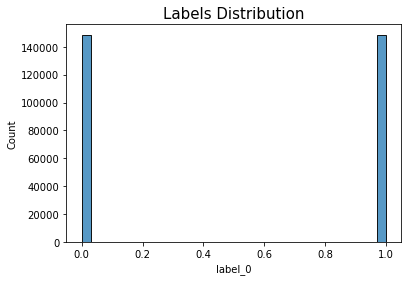

In [22]:
bar_plot = sns.histplot(data=y_dataframe, x="label_0").set_title('Labels Distribution', fontsize = 15)
counter_values = y_dataframe['label_0'].value_counts()
print(counter_values)

Concerning the distribution of the train labels we notice that the distribution is perfectly balanced.
This is a good point because we will not need to use resampling techniques such as ``SMOTE`` to work with a balanced dataset

### Split the train set and train labels set into train set and validation set 

- ```train``` sample dataset contrains **90%** of ```train``` dataset
- ```validation``` sample dataset contains **10%** ```train``` dataset

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X_dataframe, y_dataframe, test_size=0.1)

### Correlation analysis

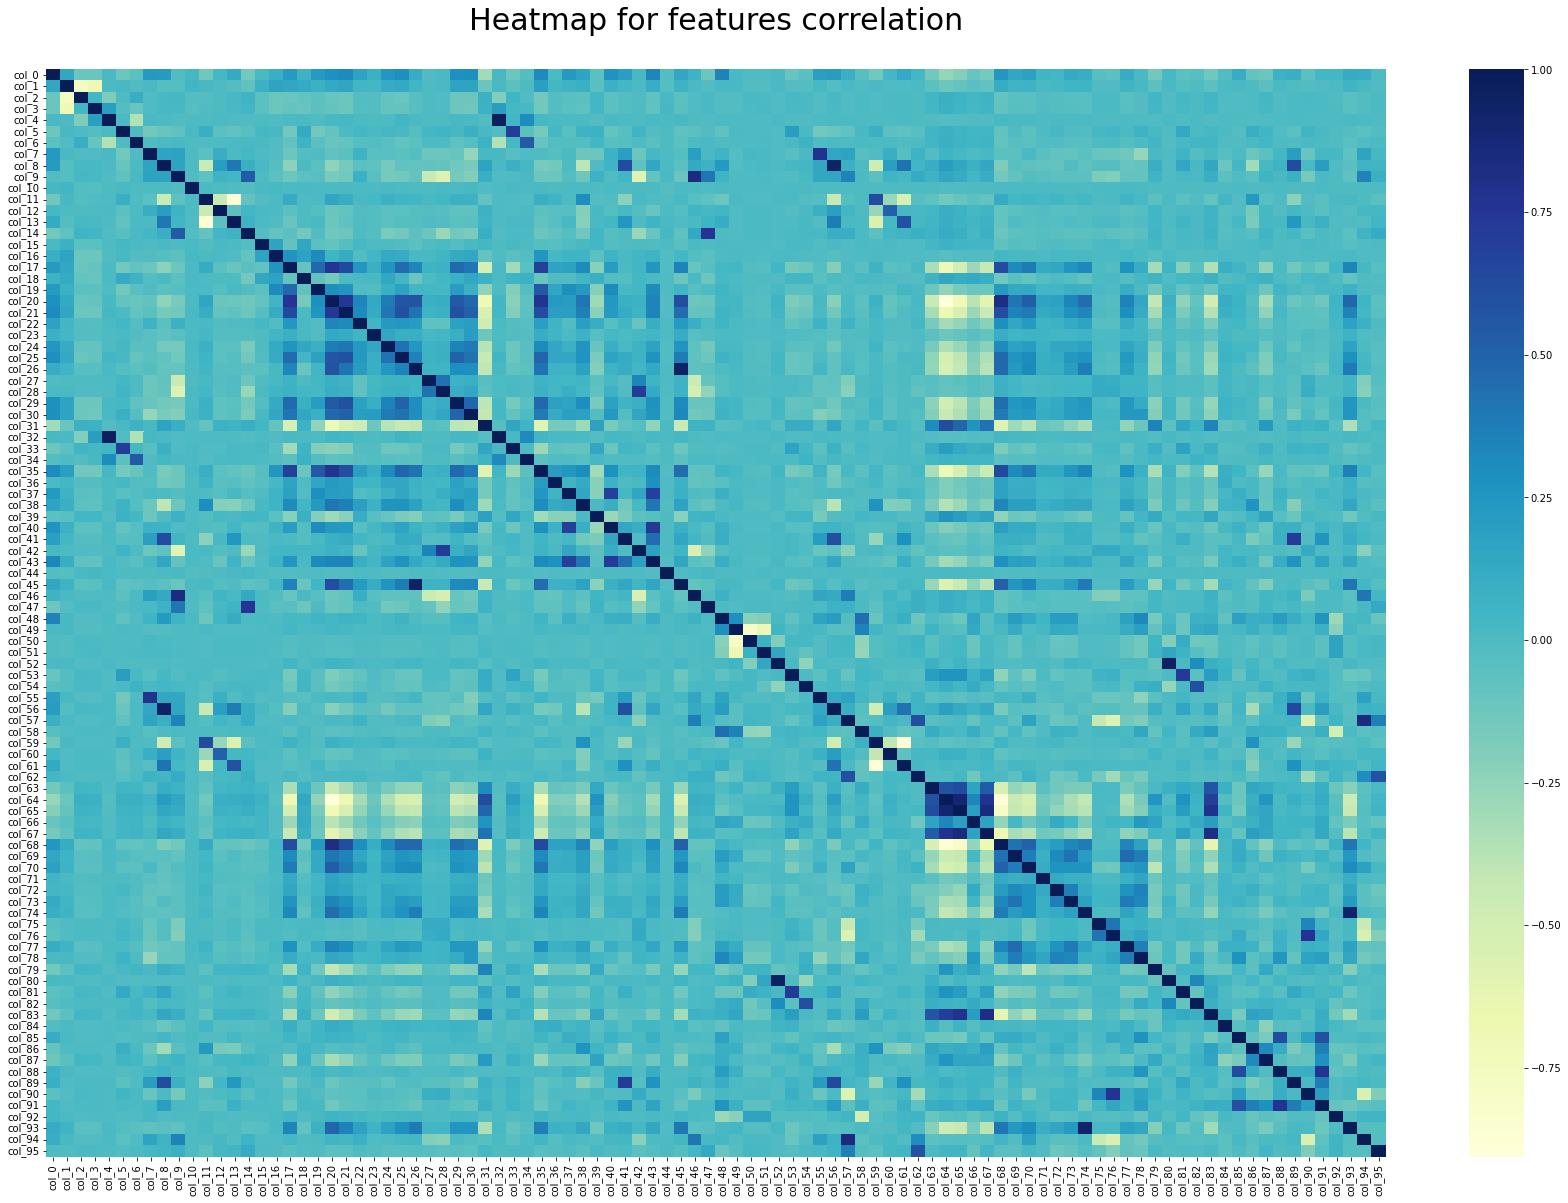

In [24]:
correlations = X_train.corr()
fig_1 = plt.figure(figsize=(30, 20))
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, 
            cmap='YlGnBu')
plt.title('Heatmap for features correlation\n', fontsize=30)
plt.show()

This heatmap allows to visualize the covariance of the different features of the dataset. If two features are strongly correlated to each other, they will have a similar effect on the target variable. Therefore it will not be necessary to include the two strongly correlated features durint the training phase of a machine learning model. Thus it is appropriate to remove one of them without having a negative impact on the accuracy of the model predictions 

Given the number of features in our dataset, it is difficult to visually determine each of the correlated variables. 
However, we can clearly distinguish 2 phenomena that emerge from the heatmap. Indeed, this heatmap reveals two striking phenomena. 

First, we notice that some features are positively correlated and others are negatively correlated.

Secondly, we can see that the features specific to each template seem to be more positively correlated between them. On the other hand, when we cross the 48 features of ```template_1``` with the 48 features of ```template_2``` we notice that they tend to be more negatively correlated. 

It is now necessary to verify these hypotheses by visualizing more closely the correlation.

#### Heatmap correlation for ```template_1```

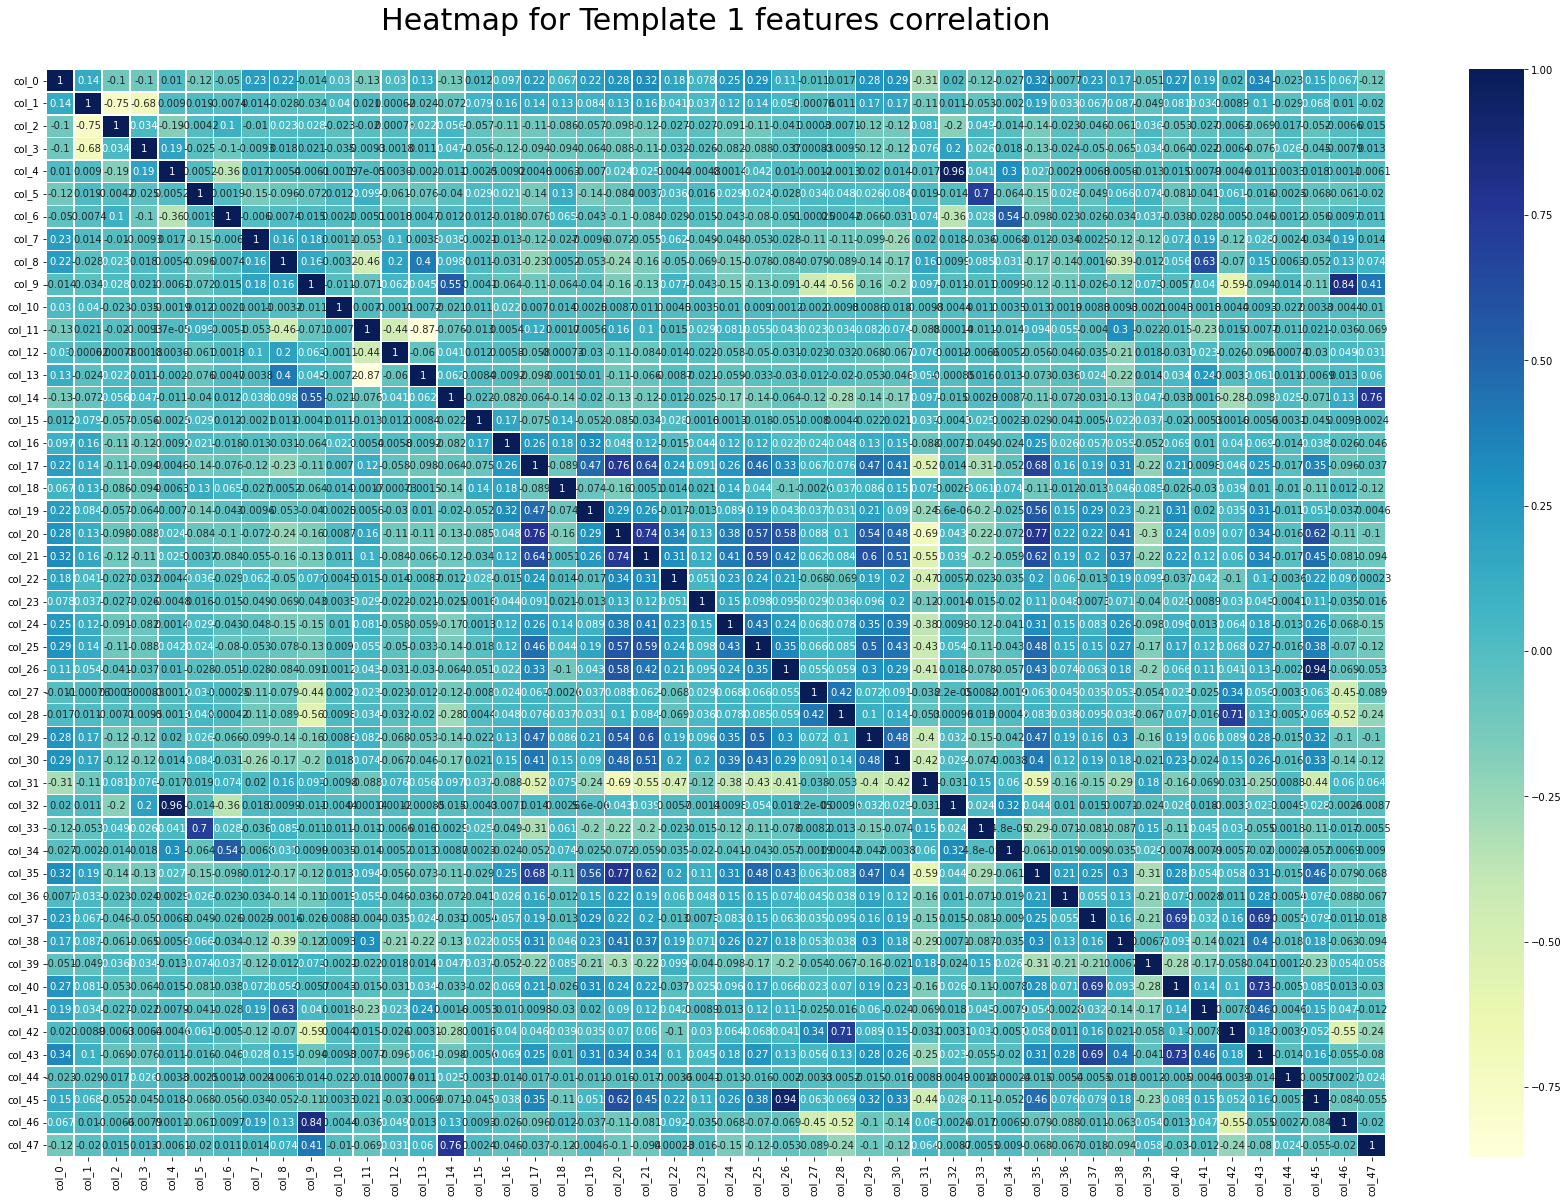

In [25]:
correlations_temp1 = X_train.iloc[:,0:48].corr()
fig_1 = plt.figure(figsize=(30, 20))
sns.heatmap(correlations_temp1, xticklabels=correlations_temp1.columns, yticklabels=correlations_temp1.columns, 
            cmap='YlGnBu', annot=True, linewidths=.5)
plt.title('Heatmap for Template 1 features correlation\n', fontsize=30)
plt.show()

Through this heatmap we are better able to analyze with finer granularity, the features correlation of ```template_1```. 

By focusing our analysis on the 48 features of ```template_1``` we can show the value of the correlation between each feature (outside the diagonal).

Through the observation of this heatmap, the first hypothesis that we previously stated seems to be confirmed . Indeed, we can see that the features are more positively correlated between them. For example the features ``{col_17, col_20}`` with a correlation coefficient of **0.76** are strongly positively correlated. 

Moreover, we also observe that some features are strongly negatively correlated even though this phenomenon occurs less frequently. For example the features ```{col_2, col_1}``` and ```{col_3, col_1}``` with respectively a correlation coefficient of **-0.75** and **-0.68** are strongly negatively correlated. 

#### Heatmap correlation for ```template_2```

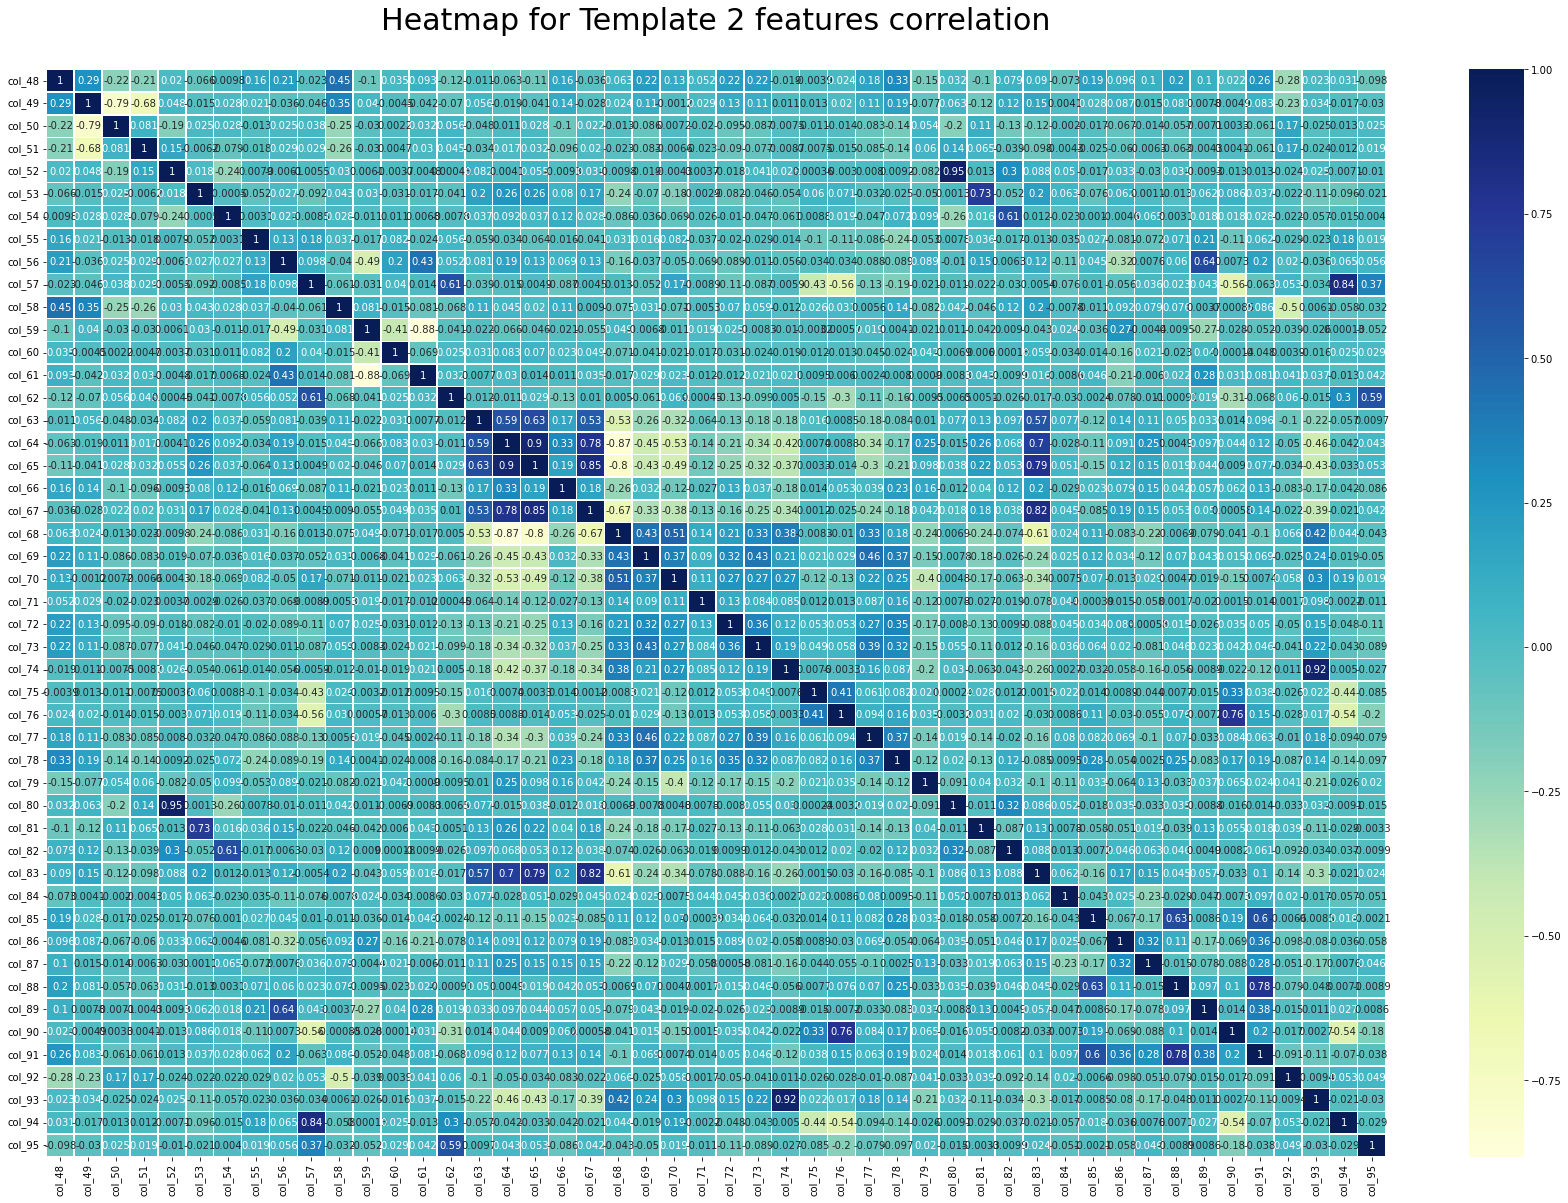

In [26]:
correlations_temp2 = X_train.iloc[:,48:].corr()
fig_2 = plt.figure(figsize=(30, 20))
sns.heatmap(correlations_temp2, xticklabels=correlations_temp2.columns, yticklabels=correlations_temp2.columns, 
            cmap='YlGnBu', annot=True, linewidths=.5)
plt.title('Heatmap for Template 2 features correlation\n', fontsize=30)
plt.show()

As the previous heatmap specific to ```template_1```, through this heatmap we are more able to analyze with finer granularity, the correlation of the variables of ```template_2```. 

In a similar way to the heatmap of ```template_1```, by focusing our analysis on the 48 features of ```template_2``` we can observe the value of the correlation between each feature (outside the diagonal).

Through the observation of this heatmap of ```template_2```, it is more complicated to validate the first hypothesis that we made previously. Indeed, the difference in proportion between the number of positively correlated features and the number of negatively correlated features seems to be less obvious. 

Some features are strongly positively correlated like the features ```{col_67, col_65}``` with a correlation coefficient a **0.85**. On the other hand, features like ```{col_68, col_64}``` with a correlation coefficient of **-0.85** are strongly negatively correlated.

### Overall conclusion

Anyway the distribution of the correlated features does not seem to follow a real logic. Unfortunately at this stage it is not possible to provide a viable interpretation of the correlation of some variables as it is so random.

### PCA for visualization

The objective of PCA is to simplify the model while retaining as much information as possible. To do this, in order to keep as much information as possible, PCA will try to find the best axis to project the data in a smaller dimension by maximizing the variance. 
The axis that will maximize the variance is the axis that is closest to all the data points.

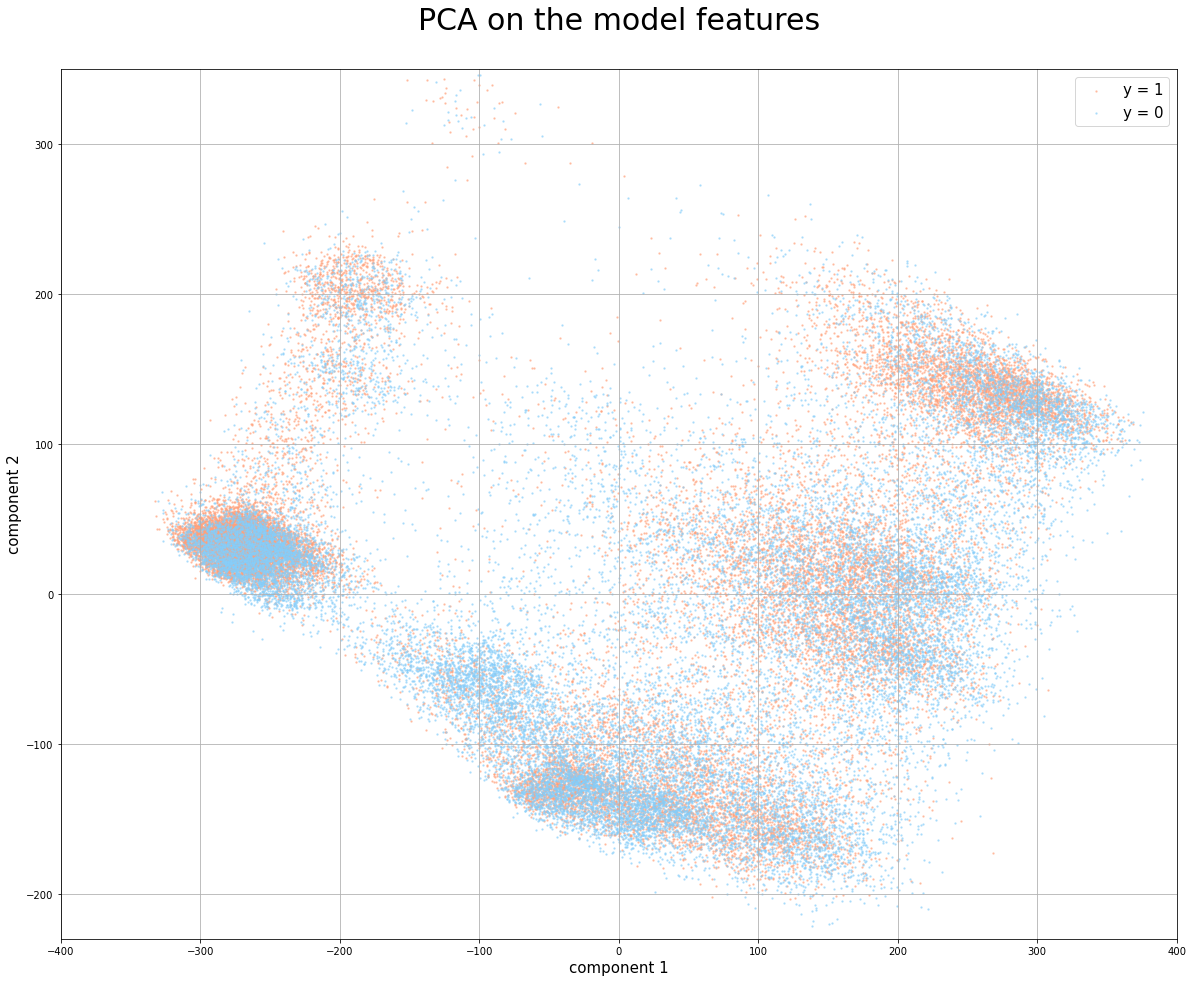

In [27]:
nb = 50000 # analyse the first 50 000 observations
X_pca = X_train[:nb].to_numpy()
y_pca = y_train[:nb].to_numpy()

mask = (y_pca==1).flatten()
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_pca)

label1 = pca_components[mask]
label2 = pca_components[~mask]

fig_1 = plt.figure(figsize=(20,16))

plt.scatter(label1[:,0], label1[:,1], c="lightsalmon", alpha=0.5, s=2, label="y = 1")
plt.scatter(label2[:,0], label2[:,1], c="lightskyblue", alpha=0.5, s=2, label="y = 0")

plt.xlim([-400, 400])
plt.xlabel("component 1", fontsize = 15)

plt.ylim([-230, 350])
plt.ylabel("component 2", fontsize = 15)

plt.title('PCA on the model features\n', fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 15)
plt.show()

At first glance the data does not seem to be separable at all. 
We expected that there would be clearly 2 distinct compact groups for each label value. Indeed, whether it is for the class ```y=0``` or class ```y=1```, these are very large and spread out. 

However, the separation of the data of each class is not clearly visible. Hence, the PCA reveals that the most difficult part of this data challenge will be to correctly identify the pairs of matching images, which will tend to be identified as non-matching pairs.

### Verification of possible redundant data points

Throughout this data exploration phase, we can easily see that the features of each template seem to follow a very similar structure. This suggests that the data set of features ```col_0``` to ```col_47``` (features ```template_1```) or ```col_48``` to ```col_95``` (features ```template_2```) uniquely represent an image. Therefore we can deduce that the features describing ```template_1``` and the features describing ```template_2``` should logically not share the same values. 

Although this is a rather strong assumption, it is necessary to check the accuracy of this assumption by performing a duplicate analysis in the dataset. 

Indeed, if it proves to be correct and the same pairs of images appear on the training set and the test set, the information on the training set can be directly exploited to produce predictions on the test set.

In [28]:
# drop duplicated elements in the train set 
# if at least two rows contains the same values one of these rows is rejected from the train set
nb_template1_train = X_train.iloc[:,0:48].drop_duplicates()
nb_template2_train = X_train.iloc[:,48:].drop_duplicates()
print("---- DISTINCTS VALUES TRAIN SET ----")
print("Train set size :", X_train.shape[0])
print("- " + str(nb_template1_train.shape[0]) + " distinct value(s) for template 1 in the train set (i.e " + str(round((nb_template1_train.shape[0] / X_train.shape[0])*100, 3)) + "% of train set size)")
print("- " + str(nb_template2_train.shape[0]) + " distinct value(s) for template 2 in the train set (i.e " + str(round((nb_template2_train.shape[0] / X_train.shape[0])*100, 3)) + "% of train set size)\n")

# drop duplicated elements in the validation set 
# if at least two rows contains the same values one of these rows is rejected from the validation set
nb_template1_valid = X_valid.iloc[:,0:48].drop_duplicates()
nb_template2_valid = X_valid.iloc[:,48:].drop_duplicates()
print("---- DISTINCTS VALUES VALIDATION SET ----")
print("Validation set size :", X_valid.shape[0])
print("- " + str(nb_template1_valid.shape[0]) + " distinct values for template 1 in the validation set (i.e " + str(round((nb_template1_valid.shape[0] / X_valid.shape[0])*100, 3)) + "% of validation set size)")
print("- " + str(nb_template2_valid.shape[0]) + " distinct values for template 2 in the validation set (i.e " + str(round((nb_template2_valid.shape[0] / X_valid.shape[0])*100, 3)) + "% of validation set size)\n")

# check if there are template 1 on the train set that are the same as template 1 on the test set.
list_template1_train = np.asarray(X_train.iloc[:,0:48].drop_duplicates().values.tolist())
list_template1_valid = np.asarray(X_valid.iloc[:,0:48].drop_duplicates().values.tolist())
template1_train_set = set([tuple(x) for x in list_template1_train])
template1_valid_set = set([tuple(x) for x in list_template1_valid])
intersection_template1 = np.array([x for x in template1_train_set & template1_valid_set])
nb_intersection = intersection_template1.shape[0]
print("\n---- SAME TEMPLATE 1 BETWEEN TRAIN SET AND VALIDATION SET ----")
print("- " + str(nb_intersection) + " template-1 value(s) in the valid set that are also part of the train set.")

# check if there are template 2 on the train set that are the same as template 2 on the test set.
list_template2_train = np.asarray(X_train.iloc[:,48:].drop_duplicates().values.tolist())
list_template2_valid = np.asarray(X_valid.iloc[:,48:].drop_duplicates().values.tolist())
template2_train_set = set([tuple(x) for x in list_template2_train])
template2_valid_set = set([tuple(x) for x in list_template2_valid])
intersection_template2 = np.array([x for x in template2_train_set & template2_valid_set])
nb_intersection = intersection_template2.shape[0]
print("\n---- SAME TEMPLATE 2 BETWEEN TRAIN SET AND VALIDATION SET ----")
print("- " + str(nb_intersection) + " template-2 value(s) in the valid set that are also part of the train set.")

---- DISTINCTS VALUES TRAIN SET ----
Train set size : 267508
- 267459 distinct value(s) for template 1 in the train set (i.e 99.982% of train set size)
- 267492 distinct value(s) for template 2 in the train set (i.e 99.994% of train set size)

---- DISTINCTS VALUES VALIDATION SET ----
Validation set size : 29724
- 29723 distinct values for template 1 in the validation set (i.e 99.997% of validation set size)
- 29724 distinct values for template 2 in the validation set (i.e 100.0% of validation set size)


---- SAME TEMPLATE 1 BETWEEN TRAIN SET AND VALIDATION SET ----
- 4 template-1 value(s) in the valid set that are also part of the train set.

---- SAME TEMPLATE 2 BETWEEN TRAIN SET AND VALIDATION SET ----
- 1 template-2 value(s) in the valid set that are also part of the train set.


Concerning the training dataset we notice that almost all the feature values of ```template_1``` and ```template_2``` are distinct. Indeed, **99.98 %** of the training set data describing ```template_1``` are distinct. Moreover **99.99 %** of the data of the training set describing ```template_2``` are distinct. Therefore, we can say that our dataset contains almost no duplicate data. This means that the set of images in ```template_1``` and ```template_2``` have many images that are different from each other.

Moreover, the important thing now is to know if the sets of images ```template_1``` and ```template_2``` contained in the training dataset also contain images identical to the validation dataset. If this is the case, then this information can be exploited with profit. In our case, the results obtained show that on the one hand, **4 images** of the ```template_1``` set of the validation dataset are also contained in the training dataset and on the other hand **1 image** of the ```template_2``` set of the validation dataset are also contained in the training dataset. Therefore, the strategy of identifying and working with images common to the training and test sets does not seem to be profitable and efficient here. In conclusion, this strategy will not be pursued.

## -------- Data Preprocessing --------

#### Load and Preprocessing function

Through this exploratory phase, it is appropriate to centralize the different pre-processing operations that we have previously carried out within a unique function.

In [29]:
def preprocessing():
    """
    Preprocessed dataframe
    ---- PARAMETERS ----
    Input : None
    Return : train dataframe cleaned, train labels cleaned
    """
    X, y = np.load("train_data.npy"), extract_labels("train_labels.txt")
    
    # convert X to DataFrame
    X_copied = X.copy()
    X_dataframe = pd.DataFrame(X_copied)
    
    # convert y to DataFrame
    y_copied = y.copy()
    y_dataframe = pd.DataFrame(y_copied)
    
    # rename X_dataframe columns
    columns_list = list()
    for i in range(X_dataframe.shape[1]):
        name_col = "col_"+str(i)
        columns_list.append(name_col)
    X_dataframe.columns = columns_list

    # rename y_dataframe columns    
    columns_list_labels = list()
    for i in range(y_dataframe.shape[1]):
        name_col_label = "label_"+str(i)
        columns_list_labels.append(name_col_label)
    y_dataframe.columns = columns_list_labels
    
    # preprocessing X_dataframe 
    X_dataframe.loc[X_dataframe['col_20'] == 0.0, 'col_20'] = 0
    X_dataframe.loc[X_dataframe['col_20'] == 255.0, 'col_20'] = 1
    X_dataframe['col_20'] = X_dataframe['col_20'].astype(int)

    X_dataframe.loc[X_dataframe['col_68'] == 0.0, 'col_68'] = 0
    X_dataframe.loc[X_dataframe['col_68'] == 255.0, 'col_68'] = 1
    X_dataframe['col_68'] = X_dataframe['col_68'].astype(int)
    
    # convert labels value from float to int
    y_dataframe['label_0'] = y_dataframe['label_0'].astype(int)
    
    # select index duplicated row for template 1
    X_template_1 = X_dataframe.iloc[:,0:48]
    template1_dup_rows = X_template_1[X_template_1.duplicated(keep = "first")]
    template1_dup_rows_tuple_idx = template1_dup_rows.groupby(list(template1_dup_rows)).apply(lambda x: tuple(x.index)).tolist()
    template1_dup_row_idx = [item for t in template1_dup_rows_tuple_idx for item in t]
    
    # select index duplicated row for template 2
    X_template_2 = X_dataframe.iloc[:,48:96]
    template2_dup_rows = X_template_2[X_template_2.duplicated(keep = "first")]
    template2_dup_rows_tuple_idx = template2_dup_rows.groupby(list(template2_dup_rows)).apply(lambda x: tuple(x.index)).tolist()
    template2_dup_row_idx = [item for t in template2_dup_rows_tuple_idx for item in t]
    
    dup_idx_list = template1_dup_row_idx + template2_dup_row_idx
    
    # drop duplicated rows for train dataset
    X_dataframe.drop(dup_idx_list, axis=0, inplace=True)
    
    # drop duplicated rows for train labels dataset
    y_dataframe.drop(dup_idx_list, axis=0, inplace=True)
    
    return X_dataframe, y_dataframe

X_df_cleaned, y_df_cleaned = preprocessing()

### Checking distrinct values for each template after preprocessing

In [30]:
# drop duplicated elements in the train set 
# if at least two rows contains the same values one of these rows is rejected from the train set
nb_template1_train = X_df_cleaned.iloc[:,0:48].drop_duplicates()
nb_template2_train = X_df_cleaned.iloc[:,48:].drop_duplicates()
print("---- Checking DISTINCTS VALUES X_DataFrame after preprocessing ----")
print("Train set size :", X_df_cleaned.shape[0])
print("- " + str(nb_template1_train.shape[0]) + " distinct value(s) for template 1 in the X_DataFrame (i.e " + str(round((nb_template1_train.shape[0] / X_df_cleaned.shape[0])*100, 3)) + "% of train set size)")
print("- " + str(nb_template2_train.shape[0]) + " distinct value(s) for template 2 in the X_DataFrame (i.e " + str(round((nb_template2_train.shape[0] / X_df_cleaned.shape[0])*100, 3)) + "% of train set size)\n")

---- Checking DISTINCTS VALUES X_DataFrame after preprocessing ----
Train set size : 297178
- 297178 distinct value(s) for template 1 in the X_DataFrame (i.e 100.0% of train set size)
- 297178 distinct value(s) for template 2 in the X_DataFrame (i.e 100.0% of train set size)



The preprocessing phase seems to have done the job. We can see that all the duplicate images for ```template_1``` and ```template_2``` have been removed. We obtain a dataset cleaned of all duplicate elements 

### Analyze Train labels distribution after preprocessing

1    148610
0    148568
Name: label_0, dtype: int64


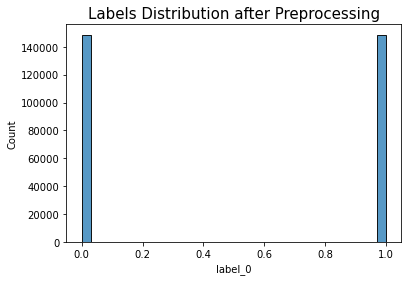

In [31]:
bar_plot = sns.histplot(data=y_df_cleaned, x="label_0").set_title('Labels Distribution after Preprocessing', fontsize=15)
counter_values_cleaned = y_df_cleaned['label_0'].value_counts()
print(counter_values_cleaned)

After the preprocessing phase, we notice that the distribution of the label values is no longer perfectly balanced. Indeed, we can observe that the label ```y=1``` is slightly more represented than the label ```y=0``` but this imbalance remains annecdotal compared to the size of the dataset. 

 ### Check ```train``` set length and ```train_labels``` set length

In [32]:
print("Train dataset length: ", len(X_df_cleaned))
print("Train labels dataset length: ", len(y_df_cleaned))

Train dataset length:  297178
Train labels dataset length:  297178


We can see that the preprocessing has been applied because the train dataset and the train labels dataset have the same length. Tha'ts a good point. 

We can now elaborate the strategic approach we are going to address for the implementation and execution of machine learning algorithms

## -------- Feature Selection --------

We notice that the dataset has a lot of features nearly close to **100 features**. We also noticed earlier with the correlation analysis of the variables that some variables are particularly strong correlated. Therefore it is advisable to remove the weakly correlated variables in order to simplify the model and reduce the cost of learning the model. However, this may not be enough, it is possible that once the correlated variables are discarded from the dataset, it is necessary to further restrict the number of features in order to work only with a subset of relevant variables. This is the challenge of the features selection step. We try to minimize the loss of information coming from the deletion of all the other variables while simplifying the classification task that the machine learning model will have to perform.

### Feature Selection strategy

The goal of feature selection in machine learning is to find the best set of features to build useful models of the studied phenomena.

To do that the strategy is to apply 3 feature selection algorithms which are :

- ```Featurewiz```
- ```ElasticNet```
- ```Random Forest Feature Importance```

Basis on the features selected by these 3 algorithms I select the 25 best features for each algorithms. Then I select features that are selected by at least 2 different algorithms will be use to train the machine learning models.

In fact, the idea is to compare the results of each algorithm, in order to select the 25 most important features of our dataset in the most robust way.

### Rescale all features except binary variables

#### Normalize ```X_df_cleaned```

In [33]:
list_binary_columns = list()
for i in X_df_cleaned.columns:
    if len(X_df_cleaned[i].unique()) < 3: 
        list_binary_columns.append(i)

list_binary_columns

['col_20', 'col_68']

In [34]:
X_df_copied = X_df_cleaned.copy()
X_raw_df_cleaned = pd.DataFrame(X_df_copied)

for col in X_df_cleaned.columns:
    if col not in list_binary_columns:
        X_df_cleaned[col] = (X_df_cleaned[col] - X_df_cleaned[col].mean()) / X_df_cleaned[col].std()
        
X_df_cleaned

col_0      col_1     col_2      col_3     col_4     col_5  \
0       1.302253   0.132587 -0.100904  -0.089055 -0.183374  0.202542   
1       1.142801   0.132587 -0.100904  -0.089055 -0.063933 -1.322580   
2      -0.248582   0.132587 -0.100904  -0.089055 -0.197999 -0.333732   
3      -0.105832 -11.554710 -0.100904  17.677702  3.607702 -1.360483   
4      -0.340030   0.132587 -0.100904  -0.089055  0.089821 -0.033490   
...          ...        ...       ...        ...       ...       ...   
297227 -1.853771  -0.046966  0.032971   0.010201  2.558985 -2.422389   
297228 -0.469272   0.132587 -0.100904  -0.089055  0.301702 -0.565699   
297229  0.972296   0.132587 -0.100904  -0.089055 -2.924514  0.255512   
297230 -1.191522   0.132587 -0.100904  -0.089055 -1.232935 -0.088134   
297231  1.021223   0.132587 -0.100904  -0.089055 -3.243742 -1.251076   

           col_6     col_7     col_8     col_9    col_10    col_11    col_12  \
0       0.428353 -0.767115  1.041148 -0.258372  0.008961  0.444393 -0.196754   
1      -0.441881  1.536166 -0.961807  4.022014  0.008961  0.444393 -0.196754   
2       0.088580 -0.838552  1.041148 -0.262657  0.008961  0.444393 -0.196754   
3      -3.235993  0.673606  1.041148 -0.249803  0.008961  0.444393 -0.196754   
4      -0.053916 -0.515100 -0.961807 -0.258372  0.008961  0.444393 -0.196754   
...          ...       ...       ...       ...       ...       ...       ...   
297227 -6.824064 -0.579400 -0.961807 -0.254088  0.008961  0.444393 -0.196754   
297228 -0.920337  0.118876 -0.961807 -0.262657  0.008961  0.444393 -0.196754   
297229 -0.699485 -0.125665  1.041148 -0.258372  0.008961 -2.326512 -0.196754   
297230  1.184868 -0.039483 -0.961807 -0.258372  0.008961  0.444393 -0.196754   
297231  2.920830 -0.542772  1.041148 -0.258372  0.008961 -2.326512 -0.196754   

          col_13    col_14    col_15    col_16    col_17    col_18    col_19  \
0      -0.385971 -0.148440  0.145382  0.231715 -0.853406  0.820022 -1.031166   
1      -0.385971 -0.148440  0.145382  0.231715  0.776536 -1.124104  0.496148   
2      -0.385971 -0.148440  0.145382 -2.770834  0.776536  0.503537 -3.603483   
3      -0.385971 -0.140407  0.145382 -5.606576 -3.482346 -3.068231 -3.089020   
4      -0.385971 -0.140407  0.145382  0.231715 -0.196171  0.458324  0.496148   
...          ...       ...       ...       ...       ...       ...       ...   
297227 -0.385971 -0.140407  0.145382  0.231715 -0.800828  0.820022 -0.854319   
297228 -0.385971 -0.148440  0.145382  0.231715  0.776536 -1.395378  0.496148   
297229  2.694919 -0.140407  0.145382  0.231715  0.776536  0.820022  0.496148   
297230 -0.385971 -0.148440  0.145382  0.231715 -1.221458  0.729598 -1.947554   
297231  2.694919 -0.140407  0.145382  0.231715 -1.379194 -4.153325  0.496148   

        col_20    col_21    col_22    col_23    col_24    col_25    col_26  \
0            0  0.830449 -0.174367  0.217755  0.400903  0.715282  0.645788   
1            1  0.739219  0.016162  0.032533  0.277422  0.883087  0.645788   
2            1  0.898871  1.585224  0.217755  0.400903  0.077622  0.645788   
3            0 -1.609955 -1.059766  0.217755 -0.072442 -2.338775 -1.645802   
4            0 -0.606424 -0.252820  0.217755 -0.710430 -0.023061 -0.136936   
...        ...       ...       ...       ...       ...       ...       ...   
297227       0 -1.427495 -1.059766  0.217755  0.400903  0.681721 -0.221810   
297228       1  0.191839  0.823108  0.217755  0.400903  0.916649  0.645788   
297229       0 -1.609955  1.540393  0.217755  0.051039 -2.338775 -0.193519   
297230       0 -1.564340 -1.059766  0.217755  0.400903 -1.600431  0.636358   
297231       0 -1.290650 -1.059766  0.217755  0.236261 -2.238092  0.296863   

          col_27    col_28    col_29    col_30    col_31    col_32    col_33  \
0       0.137490  0.172125  0.736075  0.915602  3.127295 -0.030674  0.017933   
1      -6.192823 -1.455988  0.027221  0.060955 -0.713104 -0.208495 -0.855011   
2       0.137490  0.172125  0.776581  0.565321 

### Analysis of highly correlated variables

#### Visulization of correlation heatmap before features selection

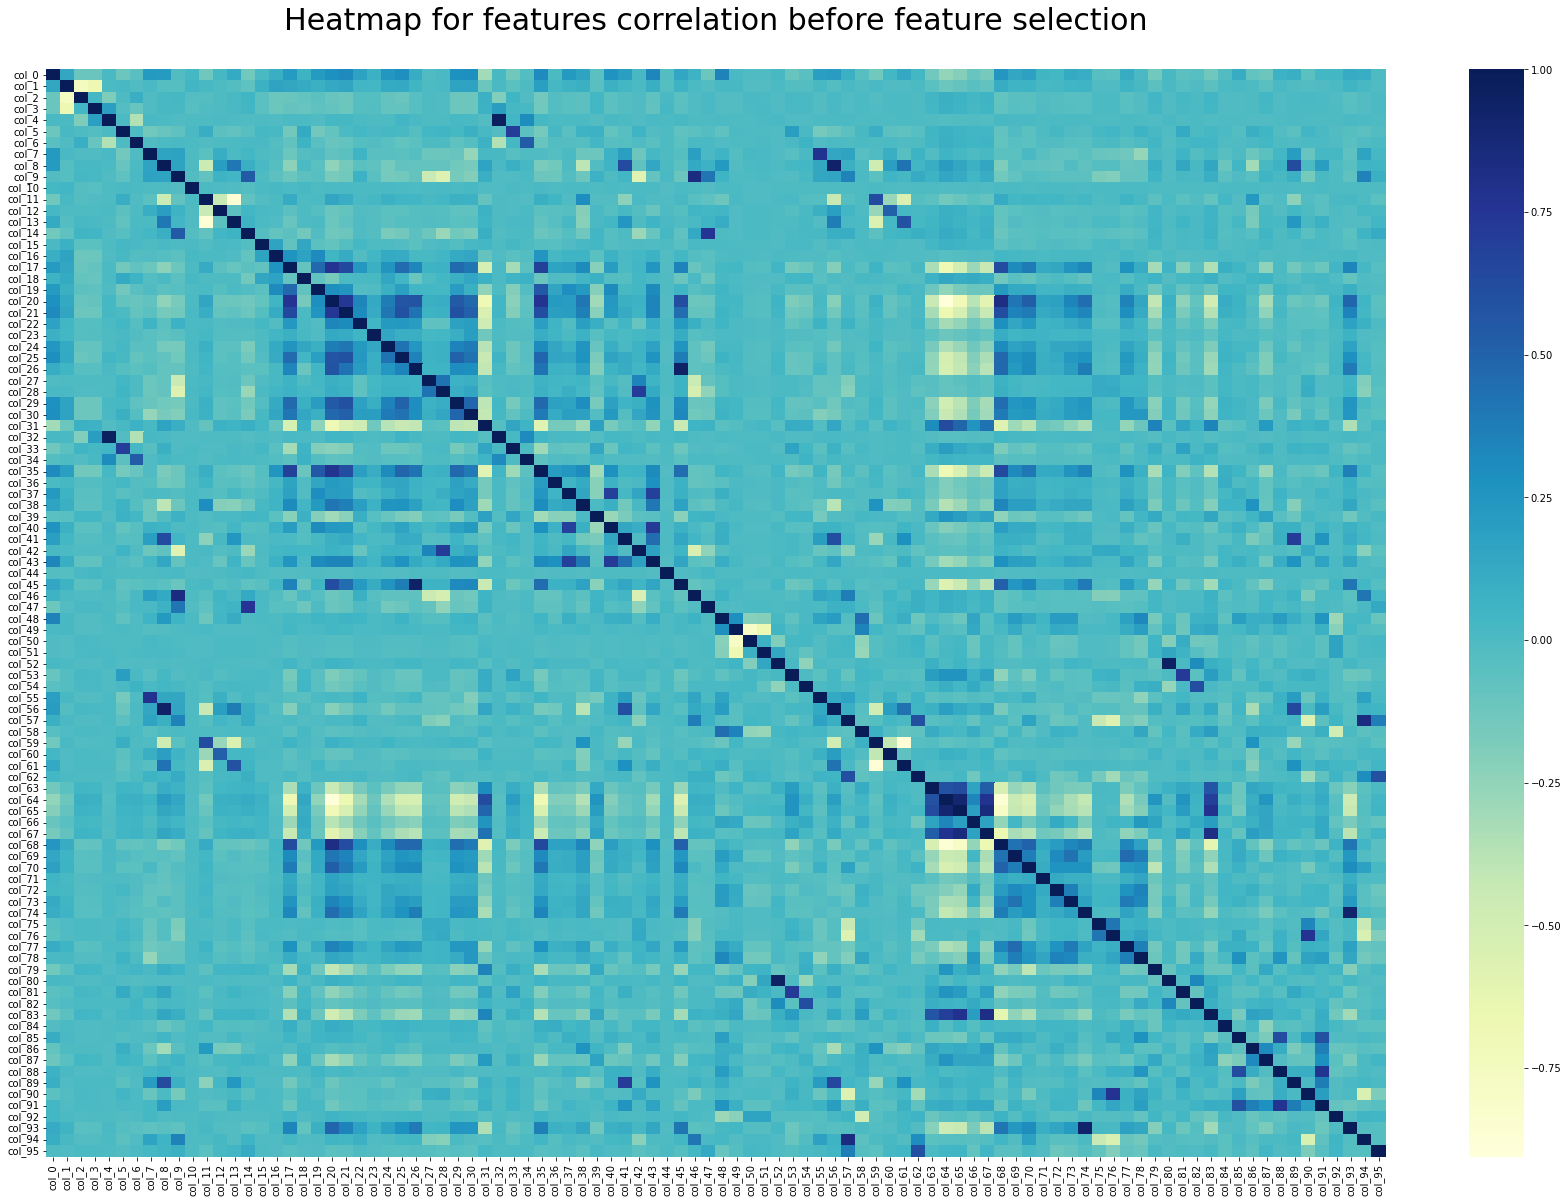

In [35]:
correlations = X_df_cleaned.corr()
fig_1 = plt.figure(figsize=(30, 20))
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, 
            cmap='YlGnBu')
plt.title('Heatmap for features correlation before feature selection\n', fontsize=30)
plt.show()

#### Build the list of pairs of features with a correlation (in absolute value) higher than +0.6 or less than -0.6

In [36]:
df_corr = X_df_cleaned.corr()
l = list()
for i in X_df_cleaned.columns:
    for j in X_df_cleaned.columns:
        if abs(df_corr.loc[i,j]) > 0.6 and df_corr.loc[i,j] != 1.0:
            if [i, j, df_corr.loc[i,j]] not in l and [j, i, df_corr.loc[j,i]] not in l :
                l.append([i, j, df_corr.loc[i,j]])

df_val = pd.DataFrame(l, columns=['feature1','feature2','val'])

# selecting negative correlated features 
df_negative_corr = df_val[df_val['val'] < 0]

# selecting positive correlated features 
df_positive_corr = df_val[df_val['val'] >= 0]

print("---- Negative Correlated Features (Less than -0.6)----\n")
print(df_negative_corr)

print("\n\n\n---- Positive Correlated Features (Higher than +0.6) ----\n")
print(df_positive_corr)

df_val = df_val.sort_values(by=['val'], ascending = False)

print("\n\n\n---- Summary correlated features ----")
print("- Negative correlated features : ", df_negative_corr.shape[0])
print("- Positive correlated features : ", df_positive_corr.shape[0])

---- Negative Correlated Features (Less than -0.6)----

   feature1 feature2       val
0     col_1    col_2 -0.753455
1     col_1    col_3 -0.682144
9    col_11   col_13 -0.869925
15   col_17   col_64 -0.684595
18   col_20   col_31 -0.691420
21   col_20   col_64 -0.905564
22   col_20   col_65 -0.709576
23   col_20   col_67 -0.605198
26   col_21   col_64 -0.672251
31   col_35   col_64 -0.695911
38   col_49   col_50 -0.789892
39   col_49   col_51 -0.674776
46   col_59   col_61 -0.881814
50   col_64   col_68 -0.866379
53   col_65   col_68 -0.795163
55   col_67   col_68 -0.669523
57   col_68   col_83 -0.611771



---- Positive Correlated Features (Higher than +0.6) ----

   feature1 feature2       val
2     col_4   col_32  0.964409
3     col_5   col_33  0.702345
4     col_7   col_55  0.779731
5     col_8   col_41  0.628739
6     col_8   col_56  0.930032
7     col_8   col_89  0.625088
8     col_9   col_46  0.839066
10   col_11   col_59  0.628477
11   col_14   col_47  0.758424
12   col_17   

On the **96 features** that compose the dataset, we have **17 features** that are **negatively correlated** and **46 features** that are **positively** correlated

### 1st Features Selection method : ```Featurewiz```

#### Removal of correlated variables with ```Featurewiz``` features selection techniques

```Featurewiz``` is a python library that can find the best features in our dataset if we give it a dataframe and the name of the target variable. It will do the following:

- It will automatically remove highly correlated features (the limit is set to 0.5 but we can change it in the input argument).

- If several features are correlated with each other, which one to delete? In such a conflict, the algorithm will delete the feature with the lowest mutual information score.

- Finally the algorithm will do a recursive selection of features using the XGBoost algorithm to find the best features using ```XGBoost```.

In [37]:
# Join train data and train labels in the same dataframe
data = pd.concat([X_df_cleaned, y_df_cleaned], axis=1).reindex(X_df_cleaned.index)
data

col_0      col_1     col_2      col_3     col_4     col_5  \
0       1.302253   0.132587 -0.100904  -0.089055 -0.183374  0.202542   
1       1.142801   0.132587 -0.100904  -0.089055 -0.063933 -1.322580   
2      -0.248582   0.132587 -0.100904  -0.089055 -0.197999 -0.333732   
3      -0.105832 -11.554710 -0.100904  17.677702  3.607702 -1.360483   
4      -0.340030   0.132587 -0.100904  -0.089055  0.089821 -0.033490   
...          ...        ...       ...        ...       ...       ...   
297227 -1.853771  -0.046966  0.032971   0.010201  2.558985 -2.422389   
297228 -0.469272   0.132587 -0.100904  -0.089055  0.301702 -0.565699   
297229  0.972296   0.132587 -0.100904  -0.089055 -2.924514  0.255512   
297230 -1.191522   0.132587 -0.100904  -0.089055 -1.232935 -0.088134   
297231  1.021223   0.132587 -0.100904  -0.089055 -3.243742 -1.251076   

           col_6     col_7     col_8     col_9    col_10    col_11    col_12  \
0       0.428353 -0.767115  1.041148 -0.258372  0.008961  0.444393 -0.196754   
1      -0.441881  1.536166 -0.961807  4.022014  0.008961  0.444393 -0.196754   
2       0.088580 -0.838552  1.041148 -0.262657  0.008961  0.444393 -0.196754   
3      -3.235993  0.673606  1.041148 -0.249803  0.008961  0.444393 -0.196754   
4      -0.053916 -0.515100 -0.961807 -0.258372  0.008961  0.444393 -0.196754   
...          ...       ...       ...       ...       ...       ...       ...   
297227 -6.824064 -0.579400 -0.961807 -0.254088  0.008961  0.444393 -0.196754   
297228 -0.920337  0.118876 -0.961807 -0.262657  0.008961  0.444393 -0.196754   
297229 -0.699485 -0.125665  1.041148 -0.258372  0.008961 -2.326512 -0.196754   
297230  1.184868 -0.039483 -0.961807 -0.258372  0.008961  0.444393 -0.196754   
297231  2.920830 -0.542772  1.041148 -0.258372  0.008961 -2.326512 -0.196754   

          col_13    col_14    col_15    col_16    col_17    col_18    col_19  \
0      -0.385971 -0.148440  0.145382  0.231715 -0.853406  0.820022 -1.031166   
1      -0.385971 -0.148440  0.145382  0.231715  0.776536 -1.124104  0.496148   
2      -0.385971 -0.148440  0.145382 -2.770834  0.776536  0.503537 -3.603483   
3      -0.385971 -0.140407  0.145382 -5.606576 -3.482346 -3.068231 -3.089020   
4      -0.385971 -0.140407  0.145382  0.231715 -0.196171  0.458324  0.496148   
...          ...       ...       ...       ...       ...       ...       ...   
297227 -0.385971 -0.140407  0.145382  0.231715 -0.800828  0.820022 -0.854319   
297228 -0.385971 -0.148440  0.145382  0.231715  0.776536 -1.395378  0.496148   
297229  2.694919 -0.140407  0.145382  0.231715  0.776536  0.820022  0.496148   
297230 -0.385971 -0.148440  0.145382  0.231715 -1.221458  0.729598 -1.947554   
297231  2.694919 -0.140407  0.145382  0.231715 -1.379194 -4.153325  0.496148   

        col_20    col_21    col_22    col_23    col_24    col_25    col_26  \
0            0  0.830449 -0.174367  0.217755  0.400903  0.715282  0.645788   
1            1  0.739219  0.016162  0.032533  0.277422  0.883087  0.645788   
2            1  0.898871  1.585224  0.217755  0.400903  0.077622  0.645788   
3            0 -1.609955 -1.059766  0.217755 -0.072442 -2.338775 -1.645802   
4            0 -0.606424 -0.252820  0.217755 -0.710430 -0.023061 -0.136936   
...        ...       ...       ...       ...       ...       ...       ...   
297227       0 -1.427495 -1.059766  0.217755  0.400903  0.681721 -0.221810   
297228       1  0.191839  0.823108  0.217755  0.400903  0.916649  0.645788   
297229       0 -1.609955  1.540393  0.217755  0.051039 -2.338775 -0.193519   
297230       0 -1.564340 -1.059766  0.217755  0.400903 -1.600431  0.636358   
297231       0 -1.290650 -1.059766  0.217755  0.236261 -2.238092  0.296863   

          col_27    col_28    col_29    col_30    col_31    col_32    col_33  \
0       0.137490  0.172125  0.736075  0.915602  3.127295 -0.030674  0.017933   
1      -6.192823 -1.455988  0.027221  0.060955 -0.713104 -0.208495 -0.855011   
2       0.137490  0.172125  0.776581  0.565321 

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (297178, 97)
    Caution: We will try to reduce the memory usage of dataframe from 218.79 MB
        memory usage after optimization is: 56.40 MB
        decreased by 74.2%
     Loaded. Shape = (297178, 97)
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Binary_Classification Feature Selection Started #

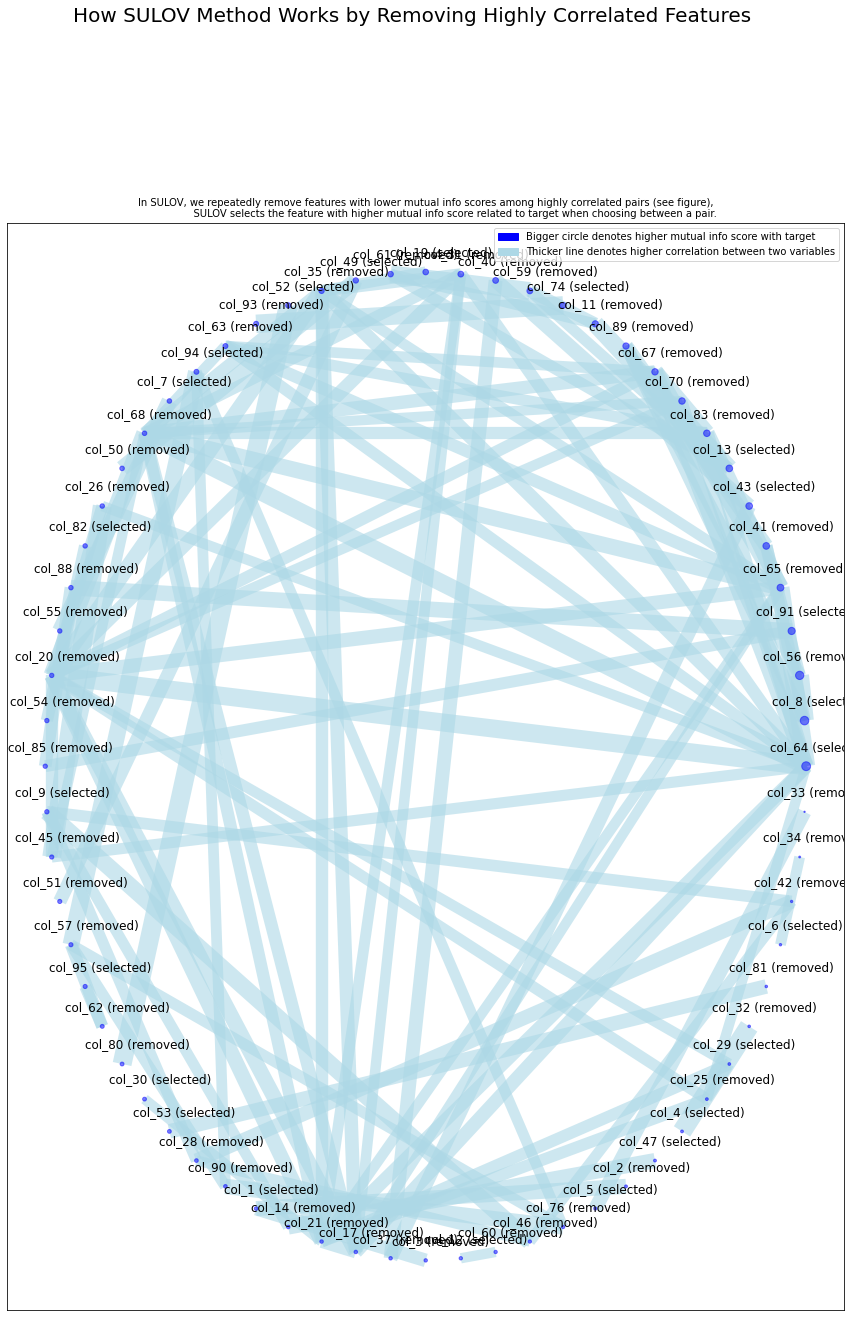

Time taken for SULOV method = 355 seconds
    Adding 0 categorical variables to reduced numeric variables  of 51
Final list of selected vars after SULOV = 51
############## F E A T U R E   S E L E C T I O N  ####################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 51 
    XGBoost version: 1.5.2
Number of booster rounds = 20
        using 51 variables...
            Time taken for regular XGBoost feature selection = 11 seconds
        using 41 variables...
            Time taken for regular XGBoost feature selection = 21 seconds
        using 31 variables...
            Time taken for regular XGBoost feature selection = 30 seconds
        using 21 variables...
            Time taken for regular XGBoost feature selection = 36 seconds
        using 11 variables...
            Time taken for regular XGBoost feature selection = 40 seconds
        using 1 variables...
            Time ta

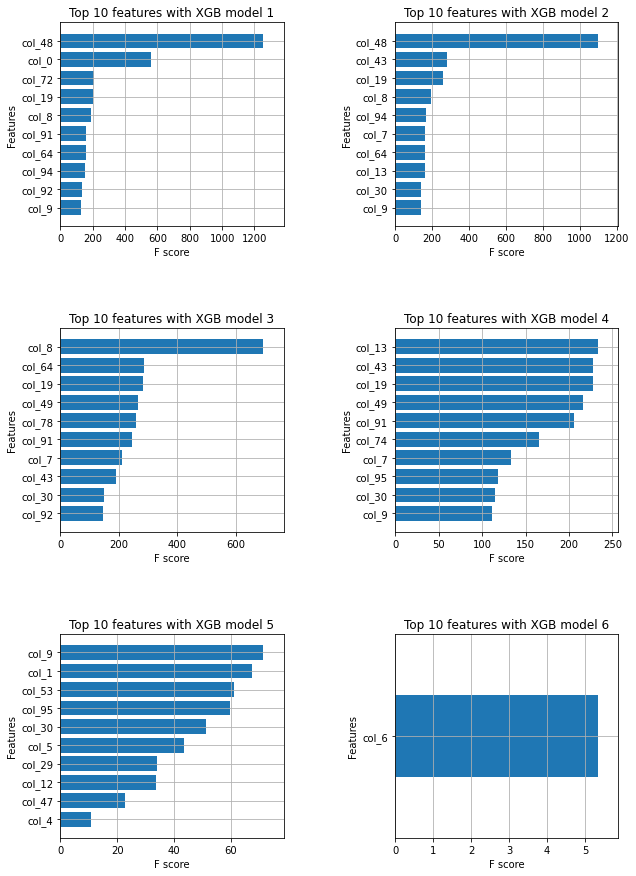

            Total time taken for XGBoost feature selection = 45 seconds
No ID variables [] are selected since they are not considered important for modeling
Selected 25 important features:
['col_48', 'col_0', 'col_72', 'col_19', 'col_8', 'col_91', 'col_64', 'col_94', 'col_92', 'col_43', 'col_7', 'col_13', 'col_30', 'col_49', 'col_78', 'col_74', 'col_95', 'col_9', 'col_1', 'col_53', 'col_5', 'col_29', 'col_12', 'col_47', 'col_6']
    Time taken = 400 seconds
    Reverted column names to original names given in train dataset
Returning list of 25 important features and a dataframe.


In [38]:
# specify the target variables for featurewiz
target = 'label_0' 

# Apply featurewiz method for features selection
features, train = featurewiz(data, target, corr_limit=0.5, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [39]:
selected_features_featurewiz = features
df_selected_features_featurewiz = pd.DataFrame(selected_features_featurewiz, columns=['Featurewiz Selected Features'])
df_selected_features_featurewiz

Featurewiz Selected Features
0                        col_48
1                         col_0
2                        col_72
3                        col_19
4                         col_8
5                        col_91
6                        col_64
7                        col_94
8                        col_92
9                        col_43
10                        col_7
11                       col_13
12                       col_30
13                       col_49
14                       col_78
15                       col_74
16                       col_95
17                        col_9
18                        col_1
19                       col_53
20                        col_5
21                       col_29
22                       col_12
23                       col_47
24                        col_6

#### Résultats : 

```Featurewiz``` has selected **25 variables**. The next step to verify the job of featurewiz by analyzing the new correlation matrix.

#### Visulization of correlation heatmap after features selection

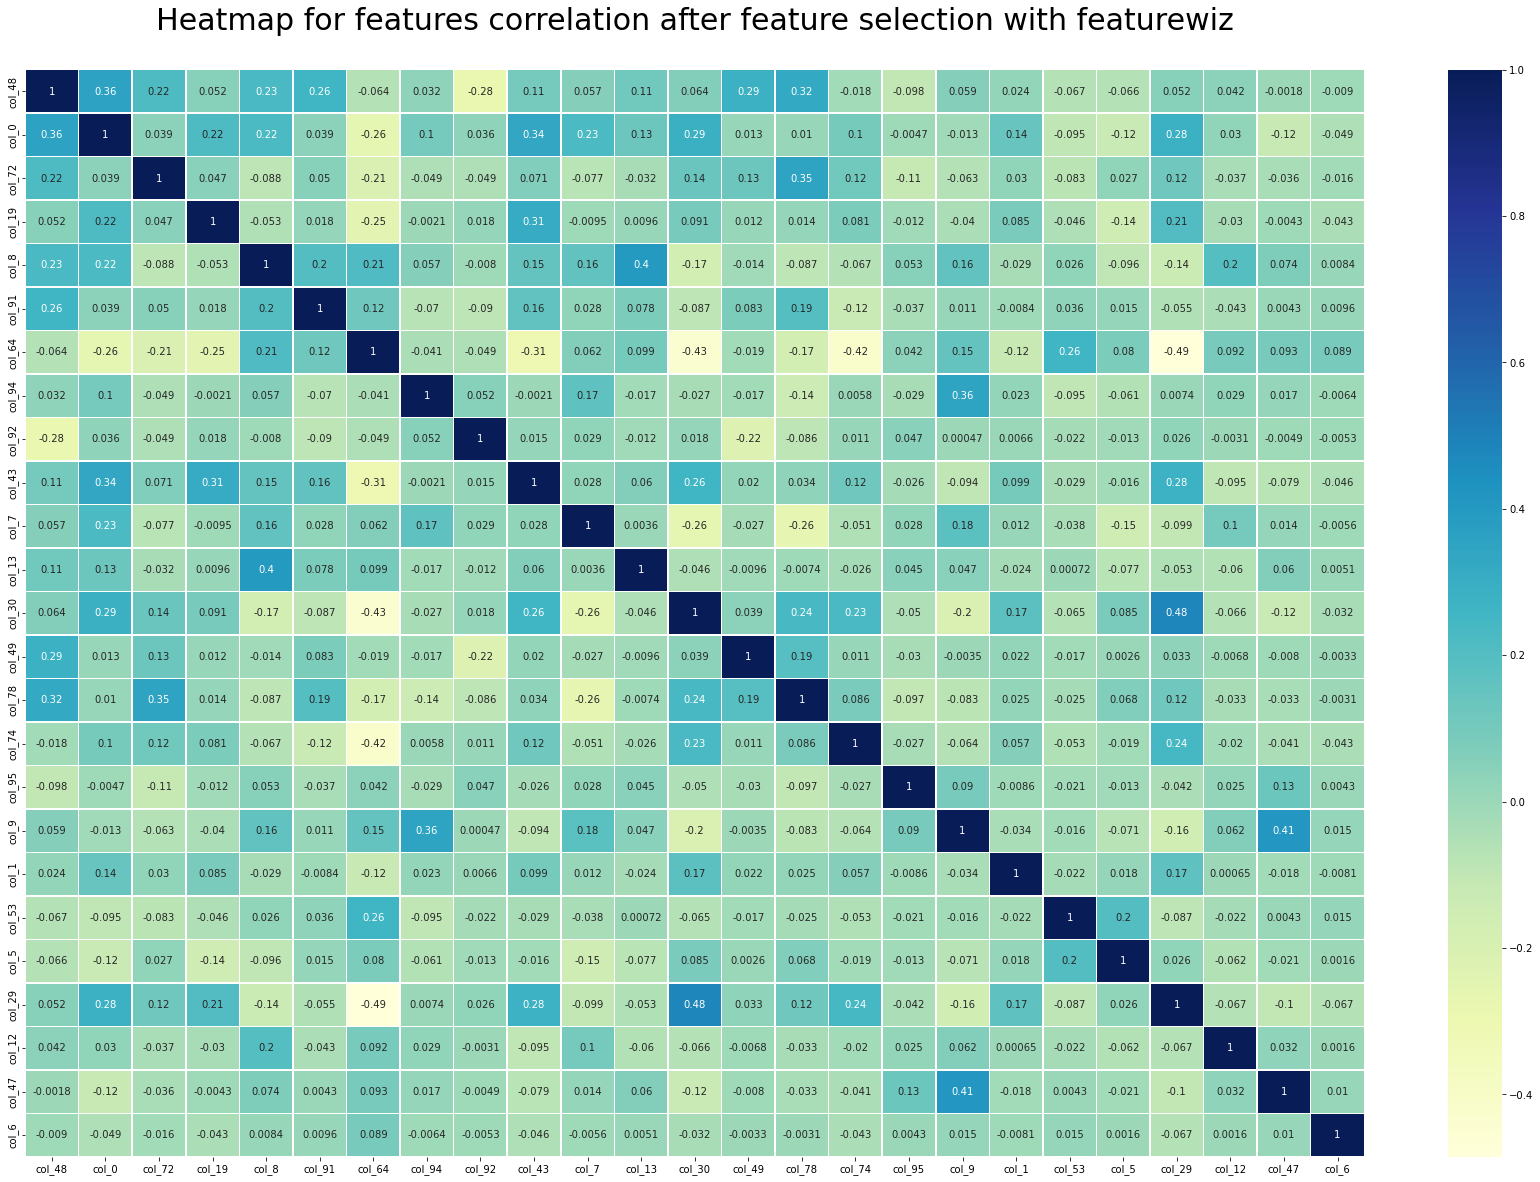

In [40]:
X_df_cleaned_features_selected_featurewiz = X_df_cleaned[selected_features_featurewiz]
correlations = X_df_cleaned_features_selected_featurewiz.corr()
fig_1 = plt.figure(figsize=(30, 20))
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, 
            cmap='YlGnBu', annot=True, linewidths=.5)
plt.title('Heatmap for features correlation after feature selection with featurewiz\n', fontsize=30)
plt.show()

We notice that all correlated variables with a correlation coefficient of **+0.5 or -0.5** have been removed. In conclusion, ```featurewiz``` seems to have done its job well since we have obtained a list of features that are not very correlated anymore

### PCA on selected features by ```featurewiz```

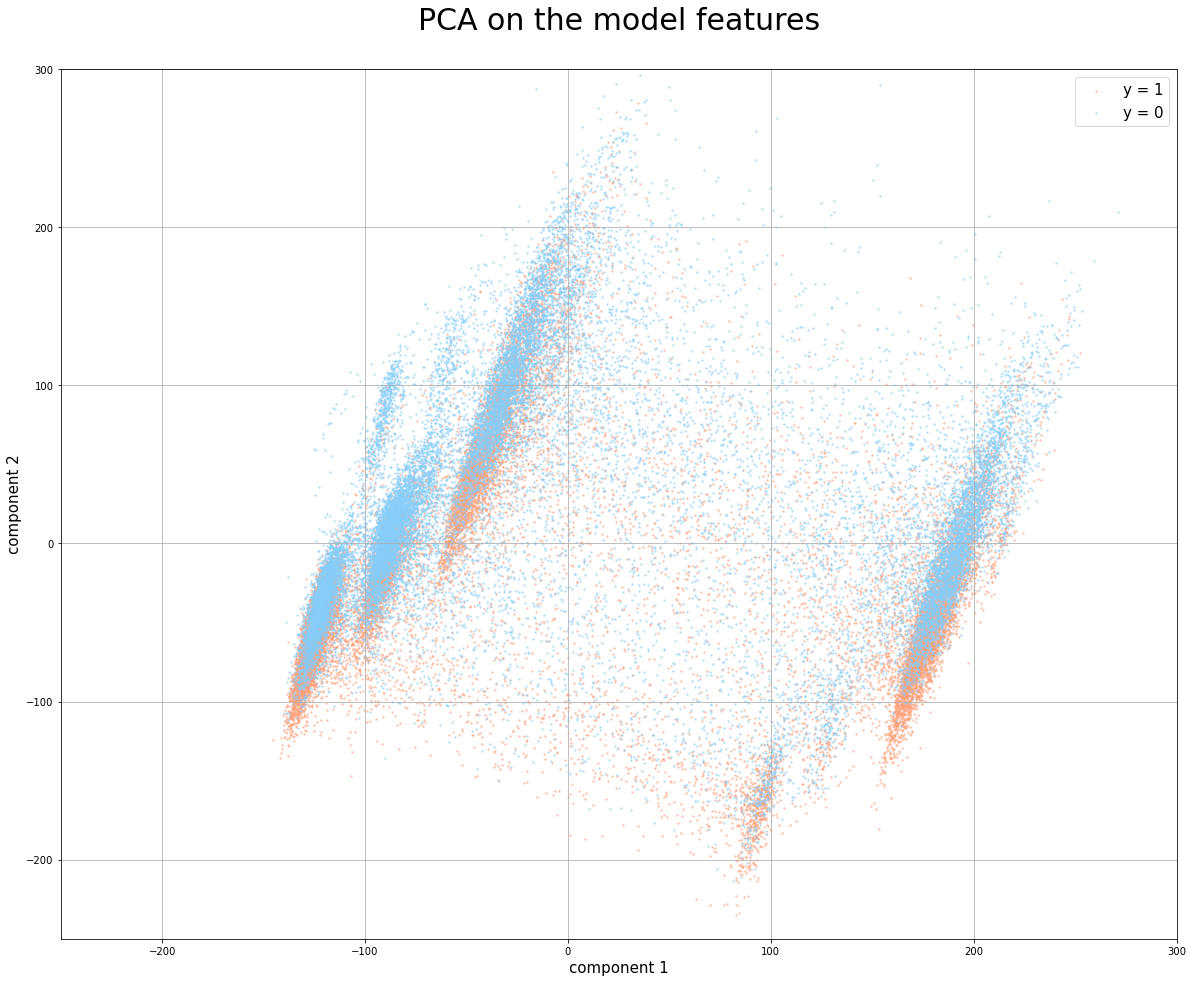

In [41]:
nb = 50000 # analyze the first 50 000 observations
X_raw_df_cleaned_features_selected_featurewiz = X_raw_df_cleaned[selected_features_featurewiz]
X_pca = X_raw_df_cleaned_features_selected_featurewiz[:nb].to_numpy()
y_pca = y_df_cleaned[:nb].to_numpy()

mask = (y_pca==1).flatten()
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_pca)

label1 = pca_components[mask]
label2 = pca_components[~mask]

fig_1 = plt.figure(figsize=(20,16))

plt.scatter(label1[:,0], label1[:,1], c="lightsalmon", alpha=0.5, s=2, label="y = 1")
plt.scatter(label2[:,0], label2[:,1], c="lightskyblue", alpha=0.5, s=2, label="y = 0")

plt.xlim([-250, 300])
plt.xlabel("component 1", fontsize = 15)

plt.ylim([-250, 300])
plt.ylabel("component 2", fontsize = 15)

plt.title('PCA on the model features\n', fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 15)
plt.show()

#### PCA results: 

After the featurewiz processing, the PCA shows us that we get two poles with 3 quite distinct clusters. However, these seem to be spread out. Now it is relatively easier to find a separation of the data of each class.

### 2nd Features Selection method : ```ElasticNet```

```ElasticNet``` combine the two types of regularizations. It contains both $L1$ and $L2$ as penalty terms. I choose this features selection techniques because, it works better than Ridge and Lasso regression for most test cases.

Wall time: 27 s


Text(0, 0.5, 'rmse')

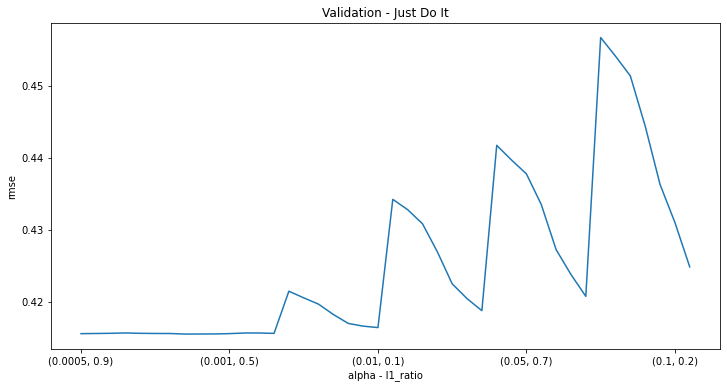

In [42]:
%%time

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_df_cleaned.iloc[:10000,:], y_df_cleaned.iloc[:10000,:], scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# Define parameters of elastic net
alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1]
l1_ratios = [0.9, 0.8, 0.7, 0.5, 0.3, 0.2, 0.1]

# Run ElasticNet on several parameters
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1_ratio)).mean() 
            for (alpha, l1_ratio) in product(alphas, l1_ratios)]

plt.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index = idx)
p_cv_elastic.plot(title = "Validation - Just Do It")
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

Text(0, 0.5, 'rmse')

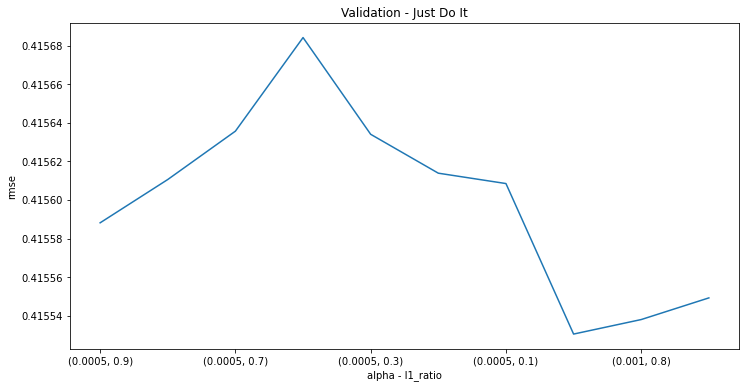

In [43]:
# Zoom in to the first 10 parameter pairs
plt.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))[:10]
p_cv_elastic = pd.Series(cv_elastic[:10], index = idx)
p_cv_elastic.plot(title = "Validation - Just Do It")
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

#### Visualize the ```rmse``` score in function of ```ElasticNet``` parameters

In [44]:
pd.DataFrame(p_cv_elastic, columns = ["rmse"])

rmse
(0.0005, 0.9)  0.415588
(0.0005, 0.8)  0.415611
(0.0005, 0.7)  0.415636
(0.0005, 0.5)  0.415684
(0.0005, 0.3)  0.415634
(0.0005, 0.2)  0.415614
(0.0005, 0.1)  0.415608
(0.001, 0.9)   0.415530
(0.001, 0.8)   0.415538
(0.001, 0.7)   0.415549

#### Display best parameters which minimize ```rmse```

In [45]:
pd.DataFrame(p_cv_elastic).idxmin()

0    (0.001, 0.9)
dtype: object

#### Run ```ElasticNet``` with the best parameters

In [46]:
elastic = ElasticNet(alpha=0.001, l1_ratio=0.9)
elastic.fit(X_df_cleaned, y_df_cleaned)

ElasticNet(alpha=0.001, l1_ratio=0.9)

In [47]:
coef = pd.Series(elastic.coef_, index = X_df_cleaned.columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 72 variables and eliminated the other 24 variables


#### Display the 10 best features and 10 worse features

Text(0.5, 1.0, 'Coefficients in the Elastic Net Model')

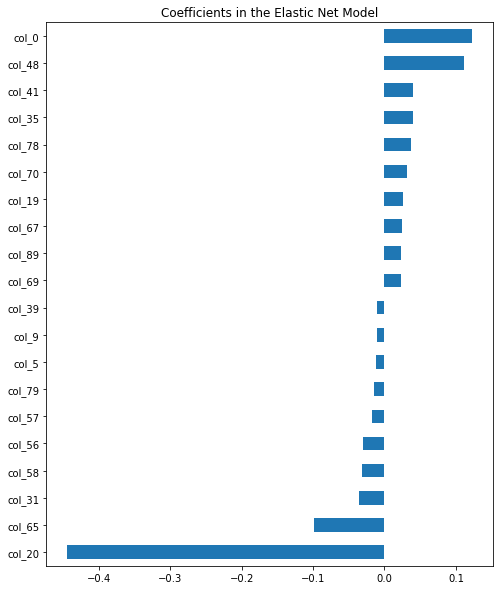

In [48]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

Looking at this graph, we immediately notice that the features ```col_0``` and ```col_48``` seem to be the features having the most impact on the prediction of the target variable. In other words, these features seem to be the most revealing in our dataset and their degree of importance far exceeds that of all the other features. For the rest of the features, the difference in importance between each feature seems to be much less pronounced

In the following of this report we will analyze the first **25 features** considered as the most important by the model.

#### Select the first 25 most important features by decreasing importance order

In [49]:
# We select the first 25 most important features
selected_features_elasticNet = pd.DataFrame(coef.sort_values(ascending=False), columns = ['selected_features'])
selected_features_elasticNet = selected_features_elasticNet[:25]
selected_features_elasticNet.dropna(subset = ['selected_features'], inplace=True)
selected_features_elasticNet = selected_features_elasticNet.index.values
pd.DataFrame(selected_features_elasticNet.tolist(), columns = ["ElasticNet Features Selected"])

ElasticNet Features Selected
0                         col_0
1                        col_48
2                        col_41
3                        col_35
4                        col_78
5                        col_70
6                        col_19
7                        col_67
8                        col_89
9                        col_69
10                        col_7
11                       col_68
12                       col_86
13                       col_13
14                       col_72
15                       col_30
16                        col_8
17                       col_24
18                       col_23
19                       col_33
20                       col_91
21                       col_66
22                       col_40
23                       col_87
24                       col_38

### 3rd Features Selection method : ```Random Forest Importance```

Random forest importance is a variable selection technique that uses the Random Forest model to represent the importance of features in a dataset to predict the target variable. The feature importance (variable importance) describes which features are relevant. The tree-based strategies used by random forests naturally rank by how well they improve the purity of the node, or in other words a decrease in the impurity (Gini impurity) over all trees. Nodes with the greatest decrease in impurity happen at the start of the trees, while notes with the least decrease in impurity occur at the end of trees. Thus, by pruning trees below a particular node, we can create a subset of the most important features.

In [50]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X_df_cleaned.iloc[:50000,:], y_df_cleaned.iloc[:50000,:], test_size=0.25, random_state=12)
rf = RandomForestClassifier(n_estimators=500, random_state=12)
rf.fit(X_train, y_train)

Wall time: 3min 2s


RandomForestClassifier(n_estimators=500, random_state=12)

#### Display of the importance of each feature by decreasing importance order 

Text(0.5, 1.0, 'Random Forest Feature Importance')

<Figure size 7200x7200 with 0 Axes>

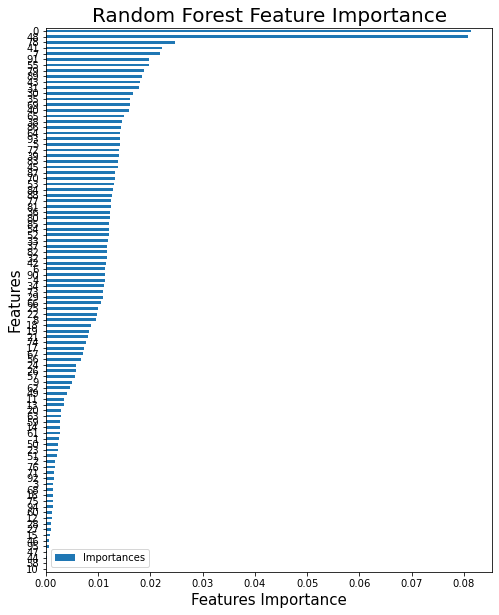

In [51]:
importances = rf.feature_importances_

features_importances_df = pd.DataFrame({"Features": pd.DataFrame(X_df_cleaned).columns, "Importances": importances})
features_importances_df.set_index("Importances")
features_importances_df = features_importances_df.sort_values("Importances")


plt.figure(figsize=(100,100))
features_importances_df.plot.barh()
plt.xlabel("Features Importance", fontsize = 15)
plt.ylabel("Features", fontsize = 15)
plt.title("Random Forest Feature Importance", fontsize = 20)

The same observation that we made for the result of the ElasticNet model can be shared here. Indeed, we also notice that the features ```col_0``` and ```col_48``` are the most important variables. Overall, the first 5 features selected by the ```Random Forest Features Importance``` model are identical to the first **5 features** selected by the ```ElasticNet``` model. These two models confirm each other

#### Select the first 25 most important features

In [52]:
features_importances_df = features_importances_df.sort_values(ascending=False, by = "Importances")
selected_Features_RF = features_importances_df.iloc[:25,0].tolist()
pd.DataFrame(selected_Features_RF, columns = ["RF Selected Features"])

RF Selected Features
0                 col_0
1                col_48
2                col_78
3                col_41
4                 col_7
5                col_91
6                col_55
7                col_79
8                col_89
9                col_43
10               col_31
11               col_30
12               col_35
13               col_69
14               col_40
15               col_65
16               col_38
17               col_86
18               col_64
19               col_93
20                col_5
21               col_72
22               col_39
23               col_83
24               col_45

### Features Selection Summary

Let's analyze the 25 most important features selected by the 3 variable selection methods we implemented, namely :
- ```Featurewiz```
- ```ElasticNet```
- ```Random Forest Features Importance```

#### Grouping in a dataframe the list of the first 25 features selected by order of importance

In [53]:
df_featurewiz = pd.DataFrame(selected_features_featurewiz, columns = ["Featurewiz Features"])
df_elasticNet = pd.DataFrame(selected_features_elasticNet, columns = ["ElasticNet Features"])
df_rf = pd.DataFrame(selected_Features_RF, columns = ["RF Features"])
                             
df_summary_features_selected = pd.concat([df_featurewiz, df_elasticNet, df_rf], axis=1)
df_summary_features_selected

Featurewiz Features ElasticNet Features RF Features
0               col_48               col_0       col_0
1                col_0              col_48      col_48
2               col_72              col_41      col_78
3               col_19              col_35      col_41
4                col_8              col_78       col_7
5               col_91              col_70      col_91
6               col_64              col_19      col_55
7               col_94              col_67      col_79
8               col_92              col_89      col_89
9               col_43              col_69      col_43
10               col_7               col_7      col_31
11              col_13              col_68      col_30
12              col_30              col_86      col_35
13              col_49              col_13      col_69
14              col_78              col_72      col_40
15              col_74              col_30      col_65
16              col_95               col_8      col_38
17               col_9              col_24      col_86
18               col_1              col_23      col_64
19              col_53              col_33      col_93
20               col_5              col_91       col_5
21              col_29              col_66      col_72
22              col_12              col_40      col_39
23              col_47              col_87      col_83
24               col_6              col_38      col_45

#### Results

We notice that the features ``col_0``, ``col_48`` occupy for the 3 methods the top of the ranking of the features importance. Then the features ```col_78``` and ```col_41``` are found just behind the features mentioned just before which also occupy the top of the ranking. Overall, the 3 models seem to select globally the same top 25 most important features.

#### Count occurences features selected by the 3 models

In [54]:
# Creation of a dataframe with the occurences of the features selected by the three models
features_list = list()
for i in range(0, len(selected_features_featurewiz)):
    features_list.append(selected_features_featurewiz[i])
    features_list.append(selected_features_elasticNet[i])
    features_list.append(selected_Features_RF[i])
    
df_features_list = pd.DataFrame(features_list, columns = ["Features Selected"])
df_features_occurences = pd.DataFrame(df_features_list.value_counts(), columns = ["Count"])
df_features_occurences = df_features_occurences.reset_index()
df_features_occurences

Features Selected  Count
0              col_0      3
1             col_91      3
2             col_72      3
3             col_78      3
4             col_48      3
5             col_30      3
6              col_7      3
7             col_40      2
8             col_13      2
9             col_89      2
10            col_35      2
11            col_38      2
12            col_69      2
13            col_41      2
14            col_43      2
15            col_86      2
16            col_64      2
17            col_19      2
18             col_8      2
19             col_5      2
20            col_70      1
21            col_94      1
22            col_74      1
23            col_92      1
24            col_79      1
25            col_93      1
26            col_87      1
27             col_9      1
28            col_83      1
29             col_6      1
30            col_68      1
31            col_67      1
32            col_12      1
33            col_23      1
34            col_24      1
35            col_29      1
36            col_31      1
37            col_33      1
38            col_39      1
39            col_45      1
40            col_47      1
41            col_49      1
42            col_53      1
43            col_55      1
44             col_1      1
45            col_65      1
46            col_66      1
47            col_95      1

#### Select the features that have been selected at least twice by a variable selection model

In [55]:
best_selected_features = df_features_occurences.loc[(df_features_occurences["Count"] >= 2)]
best_selected_features = best_selected_features["Features Selected"].tolist()
print("---- Best selected features ----\n")
print(best_selected_features)

---- Best selected features ----

['col_0', 'col_91', 'col_72', 'col_78', 'col_48', 'col_30', 'col_7', 'col_40', 'col_13', 'col_89', 'col_35', 'col_38', 'col_69', 'col_41', 'col_43', 'col_86', 'col_64', 'col_19', 'col_8', 'col_5']


## -------- Machine Learning Approach --------

### Machine Learning strategy

Through this data challenge, we have to propose a model that can solve a binary classification task. It is important to note that there is a wide range of algorithms that can provide a solution to a binary classification task. The idea here is not to try them all as this could prove to be a waste of time and not very profitable. On the other hand, it is advisable to select upstream the algorithms likely to answer best the classification problem to be solved. The strategy consists first of testing the classical approaches such as k-NN, SVM and Decision Tree. Then, it will be appropriate to apply the ensemblistic classification approaches because these methods should bring superior performances to the classical approaches. Finally, it will be necessary to test the performance of a neural network which could potentially bring even better performance than the set methods.

Below is a map of the algorithms that will be applied to try to solve the classification problem.


For each of the classification algorithms, it will be necessary to choose the best possible hyperparameters. Indeed, the choice of the hyperparameters is crucial to build the most efficient classification model possible. To do this with the python method ```GridSearchCV()``` allows by specifying upstream the list of values of each hyperparameter to test all the different combination of hyperparameter possible and thus retain the parameters of the best model that is to say those that minimizes the evaluation criterion namely the sum of false negatives and false positives. Once the values of these optimal hyperparameters are known, it is the time to train the model with these hyperparameters. In fact, the refinement of the model is the key to obtain the most efficient model for the binary classification task. However the search for the best hyperparameters can be very time consuming as the execution time of the GridSearchCV function depends very much on the possible combinations to be tested. Therefore, the search for hyperparameters will be done on a very small subsample of the training dataset. Since this sub-sample will be small, we will also do a cross evaluation to estimate the best parameters of the model. Indeed, This technique allows to avoid overfitting and to evaluate the performance of the model in a more robust way than a simple test run.

Finally, the model with the best performance on the test set will be trained on the whole dataset at our disposal and then perform the prediction on the ```X_test``` dataset.

Some comments on the choice of algorithms:


- ```k-NN```: Without a doubt, the ```k-NN``` algorithm is not the best algorithm to apply in our case of study because, we have a rather large dataset, yet ```k-NN``` does not scale very well because ```k-NN``` stores the entire dataset in memory to make a prediction. Therefore ```k-NN``` is not really suitable for our classification task. However, for pedagogical purposes, it can be good to implement a ```k-NN``` on a small subsample to obtain an order of magnitude of the performances with a relatively simple model.


- ```Decision Tree```: Even if models such as the ```Decision Tree``` are part of the weak models, an upstream implementation of a ```Decision Tree``` can be useful to determine the optimal hyperparameters and then use these hyperparameters in an ```Adaboost``` model based on a Decision Tree. The advantage of the Decision Tree model is that it performs well on large volume datasets.


- ```SVM```: Support Vector Machines were 10 years ago a state of the art model for classification tasks. For this reason, ```SVM``` is a serious candidate even if nowadays there are new, more advanced and more powerful techniques. However, the ```SVM``` algorithm suffers from the same scaling problem as the ```k-NN``` model. Therefore, like the ```k-NN``` algorithm, I will train the ```SVM``` model on a reduced subsample of the training dataset because otherwise the training time might be too much too long.


- Assembly models such as ```Random Forests```, ```Adaboost```, ```XGBoost``` and ```Gradient Boosting``` are known to be particularly efficient models for classification tasks. Each of these approaches should be tested individually, taking care to refine the hyperparameters of each algorithm.


- Voting Classifier that encompass several best classfier models for the binary classification task. Every machine learning classification model has its own advantages and disadvantages. By aggregating many models, we can overcome the disadvantages of each model to generalize the classification model. Overall voting classifier model improve performance. Voting classifier model are serious candidates whose stake will be to choose the complementary models which are able to work together to fill the weaknesses of the one and the other and thus to produce better performance


- ```Neural Networks``` can be very powerful tools and can even outperform ensemble approaches on the classification task. However, they need to be trained on large datasets, and they require a very large number of calculations. Therefore, on the one hand, the dataset may not be large enough to obtain convincing results and on the other hand, depending on the configuration of the ```Neural Networks```, the training time may be long. Finally, the last one to take into account, concerns the low computational performance of my personal computer, therefore, the ```Neural Networks``` architecture will be quite simple (limited stacking of hidden layers) but may be too simple to obtain better results than those obtained with the ensemblistic models. However, it would be a shame not to test the performance of a neural network on our classification task

### Separating the data into train, validation and test sets

Before run the training of a machine learning model, it is necessary to separate the training set into 3 sub-samples.

- Training sample {```X_train```, ```y_train```} to train the model
- Validation sample {```X_valid```, ```y_valid```} : to discriminate among models trained on the train set (typically for the purpose of hyperparameter optmisation)
- Test sample {```X_test```, ```y_test```} to test the global performance of the model

For this data challenge, we have the training dataset as well as the training labels and the test set. To form the validation sample, a subsample of data will be created from the training dataset.

Since the original training set is quite large, running cross-validation methods on it will often not be possible on a standard laptop like mine. For this reason, my approach will be flexible. Depending on the model and the optimization procedures used to fine tune the hyperparameters, I will be able to work on smaller subsamples.

### Model Evaluation

For the evaluation of the performance of the models, the idea is to minimize the sum of the rate of **false positives rate** ```FPR``` and the rate of **false negatives rate** ```FNR```. The performance score of the model is calculated using the following equation.

$score = 1 - (FPR + FNR)$

This ```score``` metric represents the ability of the model to correctly predict the data. 

When training a machine learning model, the amount of ```FPR``` and ```FNR``` should be minimized. In other words, the training must be able to maximize the ```score``` metric.  

The predictions of the algorithm must be submitted to the Data Challenge educational site so that the performance score of the model is known. 

### Data Normalization

As shown on data exploration part, the data is very heterogenous and differently scaled. It may thus make sense to normalize it before using it for machine learning purposes. My preliminary attempts on normalisation produced however no improvement on the performances however. For this reason, I will typically not standardise the data, except on methodologies where this preprocessing is justified like ```k-NN``` and ```SVM``` because these methods use distance metrics in the train process. Indeed, for ```decision tree-based``` models, the normalization of the data will have no impact on the accuracy of the predictions generated by the algorithm.

### Machine Learning Algorithms

#### Evaluation criterion function (utils for ```GridSearchCV```)

In [56]:
def criterion_GridCV(y_true, y_pred):
    CM = confusion_matrix(y_true, y_pred)
    TN, TP = CM[0, 0], CM[1, 1]
    FP, FN = CM[0, 1], CM[1, 0]
    return 1 - (FP/(FP + TN) + FN/(FN + TP))

# specify the metric to maximize to GridSearchCV function
scoring_critetion = make_scorer(criterion_GridCV)

#### Model performance evaluation function

In [6]:
def criterion(y_pred, y_true):
    CM = confusion_matrix(y_true, y_pred)
    TN, TP = CM[0, 0], CM[1, 1]
    FP, FN = CM[0, 1], CM[1, 0]
    return FP/(FP + TN) + FN/(FN + TP)

### Generate Train set

#### Generate Train dataset normalized

In [58]:
X_train = X_df_cleaned[best_selected_features]
y_train = y_df_cleaned
train = pd.concat([X_train, y_train], axis=1)
train

col_0    col_91    col_72    col_78    col_48    col_30     col_7  \
0       1.302253  0.273220 -0.239038  0.141587  1.401711  0.915602 -0.767115   
1       1.142801  0.238079  0.464752 -1.220549 -0.917994  0.060955  1.536166   
2      -0.248582 -1.048079  0.482346  1.066156  0.983522  0.565321 -0.838552   
3      -0.105832  1.389216  0.200831 -1.267947  0.248804 -2.019677  0.673606   
4      -0.340030  0.490975  0.482346 -0.781100  0.759148  0.170152 -0.515100   
...          ...       ...       ...       ...       ...       ...       ...   
297227 -1.853771 -1.604920  0.148046 -0.014575 -1.093777 -0.563545 -0.579400   
297228 -0.469272 -1.119598  0.482346 -1.953488 -0.099418 -0.490746  0.118876   
297229  0.972296  0.967315  0.376778  0.910623  0.613270 -1.721791 -0.125665   
297230 -1.191522 -0.665850 -2.262434 -2.078260 -1.689200 -1.564769 -0.039483   
297231  1.021223  0.667901  0.464752  1.193597  1.616759 -1.379508 -0.542772   

          col_40    col_13    col_89    col_35    col_38    col_69    col_41  \
0      -0.821182 -0.385971 -0.920622 -0.837885 -1.176633 -1.344304 -0.965149   
1       0.442407 -0.385971 -0.603571  1.091045  0.841658 -0.584439  0.339085   
2      -0.767774 -0.385971 -0.674853 -1.932684  1.132756  1.351991  0.899974   
3       0.755224 -0.385971  1.644080 -2.297617 -1.998463 -1.344304  1.302547   
4      -1.062521 -0.385971 -0.239157 -0.629352  0.555322 -0.118716 -0.656780   
...          ...       ...       ...       ...       ...       ...       ...   
297227  0.452266 -0.385971 -1.118615 -1.046418 -5.652549 -1.344304 -1.164403   
297228  0.824493 -0.385971 -1.056045  0.882512  0.492754 -1.001139 -0.510030   
297229 -3.070256  2.694919  1.441482 -1.359218 -0.687611  1.180408 -1.382633   
297230  0.020937 -0.385971 -0.658166 -0.681486 -0.626483 -1.246257 -1.207100   
297231  0.236602  2.694919  0.317986 -1.150685  0.467026  0.101890 -0.789616   

          col_43    col_86    col_64    col_19     col_8     col_5  label_0  
0      -0.615637 -0.566178  0.974836 -1.031166  1.041148  0.202542        1  
1       0.477096 -0.601426 -0.178596  0.496148 -0.961807 -1.322580        0  
2       0.329146 -0.770848 -1.264178 -3.603483  1.041148 -0.333732        0  
3       0.408241  0.698506  0.296347 -3.089020  1.041148 -1.360483        1  
4      -1.703507  1.563471  0.974836  0.496148 -0.961807 -0.033490        0  
...          ...       ...       ...       ...       ...       ...      ...  
297227 -1.879486  1.294807  0.974836 -0.854319 -0.961807 -2.422389        0  
297228  0.277296  0.442004 -0.300724  0.496148 -0.961807 -0.565699        0  
297229 -2.759380 -2.112631  0.974836  0.496148  1.041148  0.255512        1  
297230 -0.359667  0.082545 -0.029328 -1.947554 -0.961807 -0.088134        0  
297231 -0.359667 -0.199224  0.974836  0.496148  1.041148 -1.251076        1  

[297178 rows x 21 columns]

#### Train dataset not normalized

In [59]:
X_train_raw = X_raw_df_cleaned[best_selected_features]
y_train = y_df_cleaned
train_raw = pd.concat([X_train_raw, y_train], axis=1)
train_raw

col_0    col_91  col_72  col_78   col_48  col_30   col_7    col_40  \
0       236.031  0.829000   153.0   1.059  238.253   7.806  23.831  0.686000   
1       228.040  0.826418   193.0  -7.620  107.160   2.570  58.040  0.932080   
2       158.310  0.731915   194.0   6.950  214.620   5.660  22.770  0.696401   
3       165.464  0.911000   178.0  -7.922  173.099 -10.177  45.229  0.993000   
4       153.727  0.845000   194.0  -4.820  201.940   3.239  27.574  0.639000   
...         ...       ...     ...     ...      ...     ...     ...       ...   
297227   77.865  0.691000   175.0   0.064   97.226  -1.256  26.619  0.934000   
297228  147.250  0.726660   194.0 -12.290  153.420  -0.810  36.990  1.006490   
297229  219.495  0.880000   188.0   5.959  193.696  -8.352  33.358  0.248000   
297230  111.054  0.760000    38.0 -13.085   63.577  -7.390  34.638  0.850000   
297231  221.947  0.858000   193.0   7.762  250.406  -6.255  27.163  0.892000   

        col_13    col_89  col_35    col_38  col_69    col_41    col_43  \
0          0.0  0.335000    84.0  0.621000   110.0  0.375000  0.801000   
1          0.0  0.403857   121.0  0.918158   141.0  0.649915  0.869304   
2          0.0  0.388376    63.0  0.961017   220.0  0.768143  0.860056   
3          0.0  0.892000    56.0  0.500000   110.0  0.853000  0.865000   
4          0.0  0.483000    88.0  0.876000   160.0  0.440000  0.733000   
...        ...       ...     ...       ...     ...       ...       ...   
297227     0.0  0.292000    80.0 -0.038000   110.0  0.333000  0.722000   
297228     0.0  0.305589   117.0  0.866788   124.0  0.470933  0.856815   
297229     1.0  0.848000    74.0  0.693000   213.0  0.287000  0.667000   
297230     0.0  0.392000    87.0  0.702000   114.0  0.324000  0.817000   
297231     1.0  0.604000    78.0  0.863000   169.0  0.412000  0.817000   

          col_86  col_64  col_19  col_8   col_5  label_0  
0       0.643000   255.0   160.0    1.0  -3.195        1  
1       0.637621   170.0   255.0    0.0 -15.950        0  
2       0.611766    90.0     0.0    1.0  -7.680        0  
3       0.836000   205.0    32.0    1.0 -16.267        1  
4       0.968000   255.0   255.0    0.0  -5.169        0  
...          ...     ...     ...    ...     ...      ...  
297227  0.927000   255.0   171.0    0.0 -25.148        0  
297228  0.796856   161.0   255.0    0.0  -9.620        0  
297229  0.407000   255.0   255.0    1.0  -2.752        1  
297230  0.742000   181.0   103.0    0.0  -5.626        0  
297231  0.699000   255.0   255.0    1.0 -15.352        1  

[297178 rows x 21 columns]

## ML Implementation steps

The implementation of the machine learnign algorithms will always follow the same steps : 

- **1/** Construction of a subsample of the training dataset which is randomly generated. The size of the sub-sample can vary in order to limit the training time of the algorithms during especially during the search especially during the search phase of the best hyperparameters by the python ```GridSearchCV``` function. 


- **2/** Separation of the subsample into a training subsample and a validation subsample. The proportions are as follows: **80%** for the training subsample and **20%** for the validation subsample.


- **3/** Specification of the list of parameters that will be used by the GridSearchCV function. The purpose of the ```GridSearchCV``` function is to choose the best parameters of the algorithm that maximizes the score: $1-(FPR+FNR)$. To do this I will specify in the parameter ```scoring``` of GridSearchCV the name of the function that we defined previously thanks to the function ```make_scorer``` of the library ```sklearn``` to find the best parameters.


- **4/** Fit the model with best parameters selected by the ```GridSearchCV``` function.


- **5/** Compute the evaluation score $FPR+FNR$. 



- **6/** To further inspect the performance we display: the algorithm's **performance evolution**, the **accuracy score**, **False Positive Rate**, **False Negative Rate** and the **confusion matrix**.


**The machine learning approach I adopted follows the workflow below**

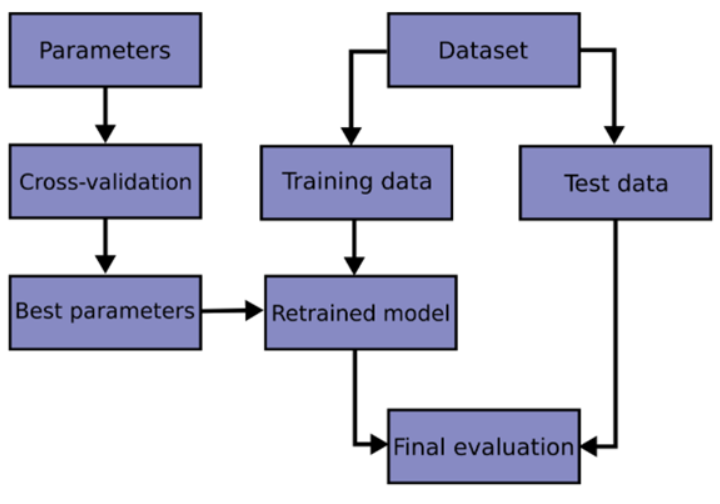

## Basic Approaches

#### The objective of these different approaches is first to apply the models seen this study semester and then to obtain a preliminary estimate of the classification performance in this challenge.

### 1- Decision Tree Classifier

### Algorithm Explanation

In decision computing, ```Decision Trees``` are widely used to solve classification problems. 

They use a hierarchical representation of the data structure in the form of sequences of decisions (tests) to predict a class.


- Each node corresponds to a class label and the attributes are represented on the inner node of the tree.
- Any Boolean function on discrete attributes can be represented using the decision tree.


Each individual (or observation), which is to be assigned to a class, is described by a set of variables that are tested in the nodes of the tree. Tests are performed in the inner nodes and decisions are made in the leaf nodes.

Each leaf node represents the output variable $y$. The internal nodes and the root node are the input variables. 

Its construction is based on a recursive partitioning of the individuals using the data. This partitioning is done by a succession of cut nodes. The cutting of a node, and what characterizes it, is done with 
stopping rules cut-off conditions. 

To determine a plausible value of Y for an individual whose values {$X_{1},...,X{p}$} are known, we proceed step by step as follows. Starting from the root, at each node, we check if the cut-off condition is verified or not: if the condition is verified, we go to the branch associated with the answer "Yes" (answering the implicit question "Is the condition verified?"), otherwise, we go to the branch associated with the answer "No".

For the separation of a node, the algorithm uses metrics such as the Gini index (the most used metric) or entropy. For example, with the Gini index, by separating 1 node into 2 child nodes, we seek to obtain the greatest increase in purity. The Gini index measures impurity. The Gini criterion organizes the separation of the leaves of a tree by focusing on the most represented class in the dataset: it must be separated as quickly as possible.

**Gini Index**

$I=1-\sum_{i}^{n} f_{i}^{2}$

With : 

- $n$ : number of classes to predict
- $f_{i}$ : frequency of the class $i$ in the noded


**Stop criterions**
- Tree depth reaches a fixed limit
- Number of leaves reaches a fixed maximum
- The number of nodes is lower than a fixed threshold
- The quality of the tree is sufficient
- The quality of the tree does not increase significantly anymore


Once the tree is built, the number of leaves is sometimes too large. The model must be simplified by pruning the tree to the right depth. A good pruning corresponds to the right compromise between tree complexity and prediction accuracy.

- A tree that is too deep = high complexity => high variance => possible of overfitting => weakened generalization power

- A tree that is not deep enough = too low complexity => high bias => risk of underfitting 

### Pros and Cons

#### Pros
- Simple to understand and interpret
- Requires little data preparation
- Very fast algorithm to execute
- The nature of the input data does not matter. Handles both continuous and categorical data
- Good behavior at extreme values (outliers)
- It is efficient for large data sets

#### Cons
- Non-optimal trees because of heuristic rules
- Tree sometimes unbalanced
- Instability: If you change a variable in the tree, the whole tree changes. Very deep trees produce high variance estimators
- Requires a large number of individuals for the rules to have a value

### Parameter choices strategy

The most important parameter for a ```Decesion Tree``` is the ```max_depth```parameter. It represents the depth of each tree, which is the maximum number of different features used in each tree. A good practice for the choice of the parmeter is to start with a shallow depth of 2 for example and increment this value by 1 without exceeding 7. To sum up, I optimize the tree depth and the node separation criterion via a ```GridSearchCV```.

#### Build sample of train data

In [57]:
# build sample of train data
temp_data = train_raw.sample(n=int(round(X_train.shape[0] * 0.5,0)), random_state=230)

X_train_reduce = temp_data.loc[:,best_selected_features]
y_train_reduce = temp_data.loc[:,["label_0"]]

#### Split data

In [58]:
# split into X_train, y_train, X_valid and y_valid
dec_tree_X_train, dec_tree_X_valid, dec_tree_y_train, dec_tree_y_valid = train_test_split(X_train_reduce, y_train_reduce, test_size=0.2)

#### Define hyperparameters and fit the model

In [59]:
%%time

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
param_grid = {
              'ccp_alpha': [0.1, .01, .001], # learning rate
              'max_depth' : [1, 2, 3, 4, 5, 6],
              'criterion' :['gini', 'entropy']
             }

# run grid search
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=cv, scoring=scoring_critetion, n_jobs = -1, verbose=True)
grid_search.fit(dec_tree_X_train, dec_tree_y_train)

# print best model
print(grid_search.best_estimator_)

Fitting 30 folds for each of 36 candidates, totalling 1080 fits
DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=6,
                       random_state=1024)
Wall time: 5min 23s


#### Compute FPR + FNR score 

In [60]:
# compute FPR + FNR score
dec_tree_y_pred = grid_search.predict(dec_tree_X_valid)
valid_score = criterion(dec_tree_y_pred, dec_tree_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.5333265814854321


#### To further inspect the performance

Confusion Matrix: 
 [[11311  3652]
 [ 4268 10487]]
Accuracy: 0.7334948516050879
False Positive Rate: 0.2440687028002406
False Negative Rate: 0.2892578786851915
FPR + FNR = 0.5333265814854321


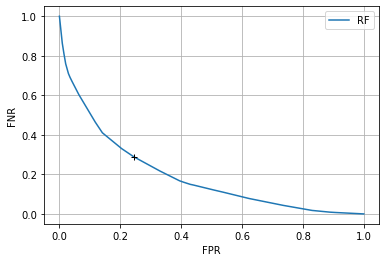

In [61]:
# to further inspect the performance:
CM = confusion_matrix(dec_tree_y_valid, dec_tree_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
dec_y_prob = grid_search.predict_proba(dec_tree_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(dec_tree_y_valid, dec_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is quite high at **0.53** enven if the accruracy is not that bad. Howerver, the algorithm does worse than the random. We also notice with the confusion matrix that the false negatives are in majority compared to the false positives. Thus, not surprisingly, the performance obtained on the validation set is quite bad. A more adequate approach is needed. It will be interesting to compare this score with the score obtained by a ```Random Forest```.

### 2/ k-NN Classifier

### Algorithm Explanation

To predict the class of a new data point, we compute the distance between all the other data points and among the $K$ points with the smallest distance we look at the majority class (most represented class). This is called a majority vote.

```k-NN``` does not compute any predictive model and it fits in the framework of Lazy Learning because it manipulates already classified individuals for any new classification.

**The loss function**

Minimization of the distance ($r_{1}(x)$ : the nearest neighbor index)

$r_{1}(\mathbf{x})=i^{*} \quad$ if and only if $\quad d_{i^{*}}(\mathbf{x})=\min _{1 \leq i \leq n} d_{i}(\mathbf{x})$

The decision to classify point x is made by a **Majority Vote**:

$\hat{f}_{k}(\mathbf{x}) \in \underset{y \in \mathcal{Y}}{\arg \max }\left(\sum_{j=1}^{k} \mathbb{1}_{\left\{y_{r_{j}}=y\right\}}\right)$

### Pros and Cons


#### Pros

- Easy to understand
- Easy to implement
- Provides good performance without too much adjustment on the parameters
- Polyvalent: Used for regression and classification


#### Cons

- The larger the dataset, the slower the prediction
- Requires a lot of storage and computing power because ```k-NN``` stores the whole dataset in memory to perform a prediction
- Does not work when the dataset contains too many features
- Bad on sparse datasets (null features)


### Parameters choices strategy

To calculate the distance between an unclassified point and other classified data points there are several metrics such as :

- Distance euclienne : $\sum_{i=1}^{n}\left|x_{i}-y_{i}\right|$


- Distance Manhattan : $\sqrt{\sum_{i=1}^{n}\left(x_{i}-y_{i}\right)^{2}}$

Without any doubt, the performance of the algorithm depends strongly on the choice of the K parameter. However, it is important to find the right compromise between :
- $k$ too small: high sensitivity to noisy points (high variance => risk of overlearning)
- $k$ too large : the neighborhood can include points of other classes. (strong bias)

A good practice is to start the training with a $k$ number of weak neighbors and then increase this value at each iteration of the algorithm.

To sum up I optimise the number of neighbours k with a grid search. I run the grid on a small subset of the train set because ```k-NN``` becomes quickly intractable at large scale. Also, as ```k-NN``` is sensitive to the scale of the variables, I standardize the features, making it possible to use a regular ```Euclidian distance``` for the algorithm

#### Build sample of train data

In [62]:
# build sample of train data
temp_data = train.sample(n=int(round(X_train.shape[0] * 0.02,0)), random_state=230)

X_train_reduce = temp_data.loc[:,best_selected_features]
y_train_reduce = temp_data.loc[:,["label_0"]]

#### Split data

In [63]:
# split into X_train, y_train, X_valid and y_valid
knn_X_train, knn_X_valid, knn_y_train, knn_y_valid = train_test_split(X_train_reduce, y_train_reduce, test_size=0.2)

#### Define hyperparameters and fit the model

In [64]:
%%time

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

max_k = 60 # set the nb neighbours at 60

# define grid
grid = {
    'n_neighbors':list(range(1, max_k)),
       }

# run grid search
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, grid, cv=cv, scoring=scoring_critetion, n_jobs = -1, return_train_score = True);
grid_search.fit(knn_X_train,knn_y_train);

# print best model
print(grid_search.best_estimator_)

KNeighborsClassifier(n_neighbors=46)
Wall time: 12min 49s


#### Inspect the accuracy values given the value of $k$ neighbours

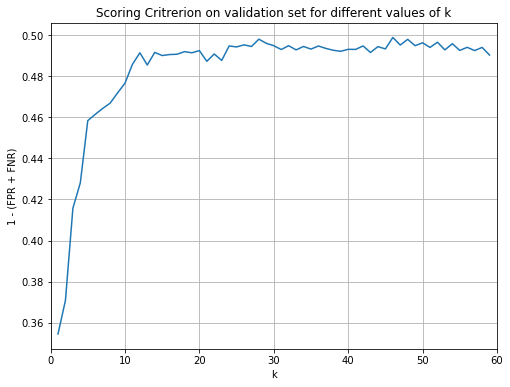

The optimal value for k is 46, which corresponds to an Scoring Criterion of 0.49879797215760974 on the validation set.


In [65]:
# plot the accuracy values given the value of k
fig_1 = plt.figure(figsize=(8,6))
plt.plot(list(range(1, max_k)), grid_search.cv_results_['mean_test_score'])
plt.xlim([0, max_k])
plt.xlabel("k")
plt.ylabel("1 - (FPR + FNR)")
plt.title('Scoring Critrerion on validation set for different values of k')
plt.grid(True)
plt.show()
# print outcome
best_k = grid_search.best_estimator_.n_neighbors

print("The optimal value for k is " + str(best_k) +\
      ", which corresponds to an Scoring Criterion of " + str(grid_search.best_score_) + " on the validation set.")

#### Compute FPR + FNR score 

In [66]:
# compute FPR + FNR score
knn_y_pred = grid_search.predict(knn_X_valid)
valid_score = criterion(knn_y_pred, knn_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.515042220294096


Confusion Matrix: 
 [[464 158]
 [148 419]]
Accuracy: 0.7426408746846089
False Positive Rate: 0.2540192926045016
False Negative Rate: 0.26102292768959434
FPR + FNR = 0.515042220294096


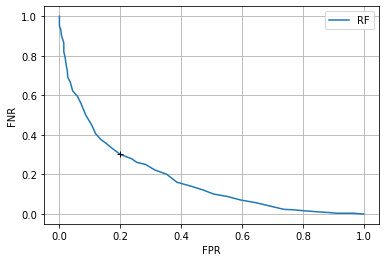

In [67]:
# to further inspect the performance:
CM = confusion_matrix(knn_y_valid, knn_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
knn_y_prob = grid_search.predict_proba(knn_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(knn_y_valid, knn_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is quite high: **0.51**. The algorithm does a little bit worse than the random. We also notice with the confusion matrix that the number of false positives and false negatives is almost similar. Thus, not surprisingly, the performance obtained on the validation set is quite bad. However, this is mainly due to the fact that the algorithm is train on a tiny data set, and also partly due to the fact that the ```k-NN``` algorithm does not produce accurate scores, but only approximate probabilities based on the $k$ nearest neighbors. A more adequate approach is needed.

## 3/ SVM

### Algorithm Explanation

The Support Vector Machine ```SVM``` can be used for both classification and regression challenges. Solving a classification problem, the ```SVM``` attempts to find the hyperplane that differentiates the two classes very well. The concept of a frontier implies that the data are linearly separable. To achieve this, ```SVM``` use kernels, i.e. mathematical functions to project and separate the data in the vector space. The separation boundary is chosen as the one that maximizes the margin. Maximizing the distance between the closest data point (of either class) and the hyperplane will help us to choose the right hyperplane. This distance is called the margin. The margin allows us to be tolerant of small variations.

The margin is the distance between the hyperplane and the closest samples. The points located on the margins are called the support vectors.

In the case where the data are not linearly separable, the ```SVM``` transforms the representation space of the input data into a higher dimensional space in which a linear separation is likely to exist. This is achieved by kernel functions.


To separate the data, ```SVM``` consider a triplet of hyperplanes:

- $H: {w}^{T}{x}+b=0, H_{1}: {w}^{T} {x}+b=1, H_{-1}: {w}^{T}{x}+b=-1$

We call geometric margin, 
$\rho({w})$ the smallest distance between the data and the hyperplane $H$, here therefore half the distance between $H_{1}$ and $H_{-1}$
A simple calculation gives: $
\rho({w})= \frac{1}{|{w}|}$.

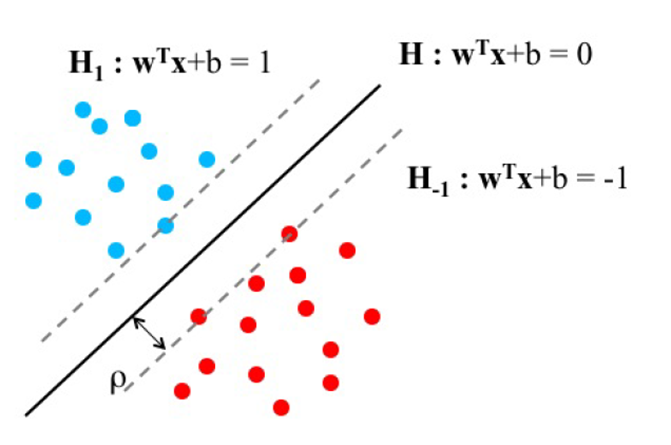

The goal is pretty simply :

- Maximize margin $\rho(\mathbf{w})$ while separating the data on both sides of $H_{1}$ and $H_{-1}$
- Separate blue data $\left(y_{i}=1\right): \mathbf{w}^{T} x_{i}+b \geq 1$
- Separate red data $\left(y_{i}=-1\right): \mathbf{w}^{\top} x_{i}+b \leq-1$

Optimization in the primal space

$\underset{w, b}{\operatorname{min}} \quad \frac{1}{2}\|w\|^{2}$
under the constraint $1-y_{i}\left(w^{\top} x_{i}+b\right) \leq 0, i=1, \ldots , n$.

### Pros and Cons



#### Pros
- Adapt to multi-class classification problems
- Simple and fast method to implement
- Few parameters to define except the right kernel
- Works well for datasets with many features


#### Cons
- Time and memory consuming algorithm
- Difficult to scale up with SVMs
- Choice of kernel can sometimes be complicated
- Very sensitive to outliers



### Parameter choices strategy

To be efficient, ```SVM``` require some optimisation. I proceed by grid search, similarly to the ```k-NN``` models. The parameters considered are the regularisation value ```C```, the kernel (```linear```, ```gaussian```, ```polynomial``` or ```sigmoid```), and the hyperparameter values ```gamma``` and ```degree``` associated to the kernels.

Because the search of best parameter with the grid search python function take a lot of time and the cost of fitting a SVM increases at least quadratically, I use only **1%** of the train dataset for the grid search and the fit.

Lastly, as for the ```k-NN```, ```SVM``` is sensitive to the scale of the variables, I standardize the features, making it possible to use a regular Euclidian distance for the algorithm 

#### Build sample of train data

In [57]:
# build sample of train data
temp_data = train.sample(n=int(round(X_train.shape[0] * 0.01,0)), random_state=340)

X_train_reduce = temp_data.loc[:,best_selected_features]
y_train_reduce = temp_data.loc[:,["label_0"]]

#### Split data

In [58]:
# split into X_train, y_train, X_valid and y_valid
svm_X_train, svm_X_valid, svm_y_train, svm_y_valid = train_test_split(X_train_reduce, y_train_reduce, test_size=0.2)

#### Define hyperparameters and fit the model

In [59]:
%%time

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = {
    'C':[1, 1.5, 2, 2.5, 3], 
    'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
    'gamma':['scale', "auto", 0.01, 0.1], 
    'degree': [2, 3, 4],
       }

# run grid search
svm = SVC();
grid_search = GridSearchCV(svm, grid, cv=cv, scoring=scoring_critetion, n_jobs = -1, verbose = True);
grid_search.fit(svm_X_train,svm_y_train);

# print best model
print(grid_search.best_estimator_)

Fitting 30 folds for each of 240 candidates, totalling 7200 fits
SVC(C=1.5, degree=2)
Wall time: 12min 34s


#### Compute FPR + FNR score

In [60]:
# compute FPR + FNR score
svm_y_pred = grid_search.predict(svm_X_valid)
valid_score = criterion(svm_y_pred, svm_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.4673355478724606


#### To further inspect the performance

In [63]:
# to further inspect the performance:
CM = confusion_matrix(svm_y_valid, svm_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))

Confusion Matrix: 
 [[238  60]
 [ 79 218]]
Accuracy: 0.7663865546218488
False Positive Rate: 0.20134228187919462
False Negative Rate: 0.265993265993266
FPR + FNR = 0.4673355478724606


### Result discussion

First of all, before discussing the obtained result, we can see that the search for the best hyperparameters takes a lot of time (approx. 12min) and even if the model is trained only on **1%** of the training dataset. 

The $FPR$ and $FNR$ rate remains high : **0.46** but this is the best score I could get for this moment. Indeed $FPR$ and $FNR$ rate is slightly less than the rate obtained by ```k-NN```. As ```Decision Tree``` we also notice with the confusion matrix that the false positives are in majority compared to the false negatives. The algorithm does does almost as much as random. Thus, not surprisingly, the performance obtained on the validation set is not that bad even if the algorithm is train on a tiny data set. 

## Bagging Approaches

Bagging is a technique that consists in assembling a large number of algorithms with low individual performance (shallow ```Decision Trees```) to create a much more efficient one (```Random Forest```). The low performance algorithms are called "weak learners" and the result "strong learner". 
Weak learners can be of different kinds and have different performances, but they must be independent of each other.
The assembly of "weak learners" (shrubs) into "strong learner" (forest) is done by voting. That is to say that each "weak learner" will emit an answer (a vote), and the prediction of the "strong learner" will be the average of all the emitted answers.
In fact, bagging combines the "best" classifiers in a way that reduces their variance. Bagging is used with decision trees, where it greatly increases the stability of the models by improving accuracy and reducing variance, thus eliminating the challenge of overfitting.

### 4/ Random Forest Classifier


### Algorithm Explanation

First of all, ```Random Forests``` represent a class of machine learning algorithms with solid performances in the family of ensemble learning.
Random forests are therefore an improvement of the bagging for ```Decision Tree``` in order to make the trees used more independent (less correlated). The random forest is composed of several decision trees, working independently on a classification task. Each one produces an estimate, and it is the assembly of the decision trees and their analyses that will give a global estimate. In other words, it is a matter of drawing inspiration from different opinions, dealing with the same problem, to better understand it. Each model is randomly distributed to subsets of decision trees.
The term random forest comes from the fact that the individual predictors are, here, explicitly predictors per tree, and from the fact that each tree depends on an additional random variable (i.e. in addition to $L_{n}$). A random forest is the aggregation of a collection of random trees. 

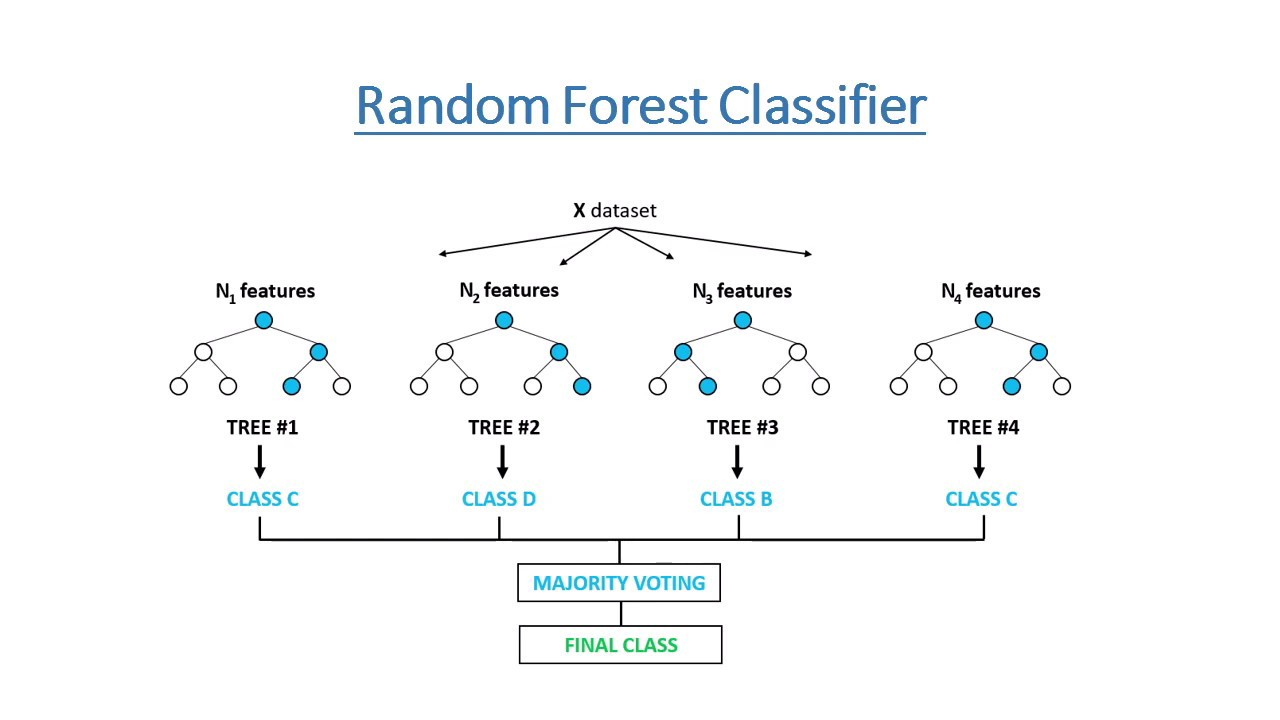

The decision to classify point x is made by a **Majority Vote**:

$\hat{f}_{k}(\mathbf{x}) \in \underset{y \in \mathcal{Y}}{\arg \max }\left(\sum_{j=1}^{k} \mathbb{1}_{\left\{y_{r_{j}}=y\right\}}\right)$

### Pros and Cons


#### Pros
Same as ```Decision Tree```

#### Cons
Same as ```Decision Tree```


### Parameter choices strategy
I optimize my model with a grid search on the following parameters: the split criterion (Gini or entropy), the max depth of the trees (from 2 to 7). I voluntarily choose to focus on the search for parameters with a limited tree depth to avoid overfitting. In addition I also optimize the number of estimator parameters this corresponds to the number of ```Decision Tree``` used to make the prediction. Overall I optimize the parmeters by performing a grid search with the same parameters as those defined for the implementation of the ```Decision Tree``` algorithm.

In [78]:
# build sample of train data
temp_data = train_raw.sample(n=int(round(X_train.shape[0] * 0.05,0)), random_state=140)

X_train_reduce = temp_data.loc[:,best_selected_features]
y_train_reduce = temp_data.loc[:,["label_0"]]

In [79]:
# split into X_train, y_train, X_valid and y_valid
rf_X_train, rf_X_valid, rf_y_train, rf_y_valid = train_test_split(X_train_reduce, y_train_reduce, test_size=0.2)

In [80]:
%%time

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = {'criterion':('gini', 'entropy'),
        'n_estimators': [100, 110, 120],
        'max_depth':[2, 3, 4, 5, 6, 7],
       }


# run grid search
rf = RandomForestClassifier();
grid_search = GridSearchCV(rf, grid, cv=cv, scoring=scoring_critetion, n_jobs = -1);
grid_search.fit(rf_X_train,rf_y_train);


# print best model
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=7, n_estimators=120)
Wall time: 10min 28s


In [81]:
# compute FPR + FNR score
rf_y_pred = grid_search.predict(rf_X_valid)
valid_score = criterion(rf_y_pred, rf_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.4946489384827186


Confusion Matrix: 
 [[1129  363]
 [ 372 1108]]
Accuracy: 0.7526917900403769
False Positive Rate: 0.2432975871313673
False Negative Rate: 0.25135135135135134
FPR + FNR = 0.4946489384827186


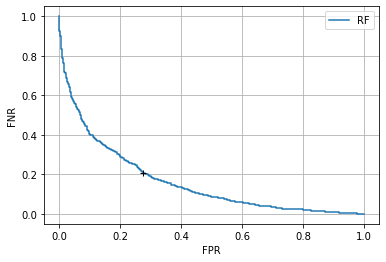

In [82]:
# to further inspect the performance:
CM = confusion_matrix(rf_y_valid, rf_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
rf_y_prob = grid_search.predict_proba(rf_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(rf_y_valid, rf_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is quite high: **0.49**. The algorithm does as well than the random. But ```Random Forest``` is quite better on the classification task than ```Decision Tree``` (**0.53**). We also notice with the confusion matrix that the number of false positives and false negatives is almost similar. Thus, not surprisingly, the performance obtained on the validation set is quite bad. 

### 5/ ExtraTrees Classifier

```ExtraTrees``` and ```Random Forests``` are close methodologies. Indeed, the both algorithm have much in common. Both are composed of a large number of decision trees, where the final decision is obtained by considering the prediction of each tree and the class prediction is decided by a majority vote

However there are two differences which are as follows: 

- ```Random Forest``` uses bootstrap replicas , i.e., it subsamples the input data with replacement, while Extra Trees uses the entire original sample.


- Another difference is the selection of cutpoints to split the nodes. Random Forest chooses the optimal split while Extra Trees chooses it randomly. However, once the split points are selected, both algorithms choose the best one among all the subsets of features. Therefore, ```ExtraTrees``` adds randomization but still has optimization.

### Parameter choices strategy
I optimize my model with a grid search on the following parameters: the split criterion (Gini or entropy), the max depth of the trees (from 1 to 7). I voluntarily choose to focus on the search for parameters with a limited tree depth to avoid overfitting. Since ```Extra Tree``` and ```Random Forests``` adopt very similar approaches, I used the same optimization strategy to refine ```ExtraTrees``` learning so, my approach is thus similar to random forests. 

In [83]:
# build sample of train data
temp_data = train_raw.sample(n=int(round(X_train.shape[0] * 0.1,0)), random_state=140)

X_train_reduce = temp_data.loc[:,best_selected_features]
y_train_reduce = temp_data.loc[:,["label_0"]]

In [84]:
# split into X_train, y_train, X_valid and y_valid
etr_X_train, etr_X_valid, etr_y_train, etr_y_valid = train_test_split(X_train_reduce, y_train_reduce, test_size=0.2)

In [85]:
%%time

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = {'criterion':('gini', 'entropy'),
        'n_estimators': [100, 110, 120],
        'max_depth':[2, 3, 4, 5, 6, 7],
       }


# run grid search
etr = ExtraTreesClassifier();
grid_search = GridSearchCV(etr, grid, cv=cv, scoring=scoring_critetion, n_jobs = -1);
grid_search.fit(etr_X_train,etr_y_train);

# print best model
print(grid_search.best_estimator_)

ExtraTreesClassifier(max_depth=7, n_estimators=120)
Wall time: 6min 5s


In [86]:
etr_y_pred = grid_search.predict(etr_X_valid)
valid_score = criterion(etr_y_pred, etr_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.5554041465536488


Confusion Matrix: 
 [[2278  680]
 [ 972 2014]]
Accuracy: 0.7220726783310901
False Positive Rate: 0.22988505747126436
False Negative Rate: 0.32551908908238447
FPR + FNR = 0.5554041465536488


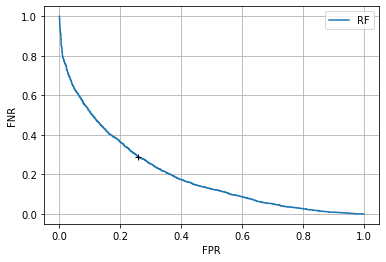

In [87]:
# to further inspect the performance:
CM = confusion_matrix(etr_y_valid, etr_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
etr_y_prob = grid_search.predict_proba(etr_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(etr_y_valid, etr_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is quite high: **0.55**. The algorithm does worse than the random. But ```Random Forest```(**0.49**) is better on the classification task than ```ExtraTree```. we also notice with the confusion matrix that the false positives are in great majority compared to the false negatives. Thus, not surprisingly, the performance obtained on the validation set is quite bad. 

## Boosting Approaches 

The principle of boosting is to combine the outputs of several weak classifiers to obtain a much more accurate prediction (strong classifier). 

The boosting method is used to decrease the bias. Each weak classifier is weighted by the quality of its classification: the better it classifies, the more important it will be. The poorly classified examples will have a greater weight (we say they are boosted) towards the weak learner in the next round, so that it makes up for the lack.

In fact, after analyzing the first tree, they increase the weight of each observation that the model fails to classify correctly. On the other hand, they decrease the weight of those whose classification is not a problem. The original idea is to improve the predictions of the first tree. In fact the goal is to correct the shortcomings of the previous tree.


## 6/ Adaboost

### Algorithm Explanation

The "weak learners" of ```AdaBoost``` are generally decision trees with only 2 branches and 2 leaves (also called stumps) but we can use other types of classifiers. 
Here are the steps to build the first "weak learner" that we will call $w_{1}$ :

- We assign the same weight to each row of the dataset
- We train the first weak learner in order to maximize the number of correct answers
- We give a score to w1 according to its performance

The score will allow us to determine the weight to be given to which "weak learner" at the time of the final vote.

Moreover, we want the next weak learner to be able to correct the mistakes of the previous one. To do this, we will increase the weight of the lines on which the first weak learner was wrong, and decrease those on which the first weak learner was right. 
Here are the steps to build the other "weak learner":

- We modify the weights assigned to the lines according to the errors of the last weak learner 
- We train a "weak learner" to maximize the number of correct answers on the lines with high weights
- We give a score to this "weak learner" according to its performance

Contrary to $w_{1}$, the next "weak learner" will take into account the weights assigned to the lines. The higher the weight of a line, the more important it is for the weak learner to classify this line correctly, and inversely.


### Parameter choices strategy
To apply the algorithm, I chose to use a ```Decision Tree``` classifier. 
I optimized the parameters of the algorithm by varying the number of estimators (i.e. the number of weak learners such as ```Decision Tree```) as well as the learning rate. In addition I decided to choose the best hyperparameters selected by the grid serach of my ```Decision Tree``` algorithm. But by iterating the model several times I could see that a smaller tree depth generally led to better performance so I set the depth of the decision tree to **2** (```max_depth = 2```)

#### Build sample of train data

In [128]:
# build sample of train data
temp_data = train_raw.sample(n=int(round(X_train.shape[0] * 0.05,0)), random_state=140)

X_train_reduce = temp_data.loc[:,best_selected_features]
y_train_reduce = temp_data.loc[:,["label_0"]]

#### Split data

In [129]:
# split into X_train, y_train, X_valid and y_valid
adb_tree_X_train, adb_tree_X_valid, adb_tree_y_train, adb_tree_y_valid = train_test_split(X_train_reduce, y_train_reduce, test_size=0.2)

#### Define hyperparameters and fit the model

In [130]:
%%time

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = {'learning_rate': [0.01, 0.1, 1.0],
        'n_estimators': [100, 110, 120],
       }

# run grid search
adb_tree = AdaBoostClassifier(DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=2), random_state=0)
grid_search = GridSearchCV(adb_tree, grid, cv=cv, scoring=scoring_critetion, n_jobs = -1);

# fit on train set
grid_search.fit(adb_tree_X_train, adb_tree_y_train)

# print best model
print(grid_search.best_estimator_)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.001,
                                                         criterion='entropy',
                                                         max_depth=2),
                   learning_rate=0.1, n_estimators=100, random_state=0)
Wall time: 9min 30s


#### Compute FPR + FNR score 

In [131]:
adb_tree_y_pred = grid_search.predict(adb_tree_X_valid)
valid_score = criterion(adb_tree_y_pred, adb_tree_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.5198994971233135


#### To further inspect the performance

Confusion Matrix: 
 [[1124  352]
 [ 421 1075]]
Accuracy: 0.7399057873485868
False Positive Rate: 0.23848238482384823
False Negative Rate: 0.28141711229946526
FPR + FNR = 0.5198994971233135


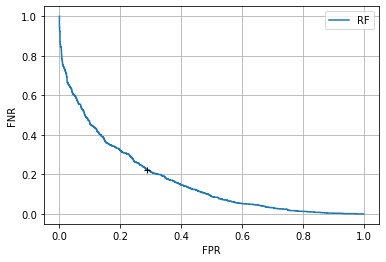

In [132]:
# to further inspect the performance:
CM = confusion_matrix(adb_tree_y_valid, adb_tree_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
adb_tree_y_prob = grid_search.predict_proba(adb_tree_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(adb_tree_y_valid, adb_tree_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

With the second approach I managed to get the rate of $FPR$ and $FNR$ down to **0.51**. So, not surprisingly, the performances obtained on the validation set are much better because this time I used all the dataset to train my model. Also increasing the number of estimators seems to improve the performances. Surprisingly the ```boosting``` algorithms don't provide much better performance than the ```bagging``` algorithms and the classical approaches such as ```SVM```, ```k-NN```. But it is still more efficient than```Decision Tree```

## 7/ Gradient Boosting

### Algorithm Explanation

The ```Gradent Boosting``` algorithm has a lot in common with ```Adaboost```. Like ```Adaboost```, it is a set of weak learners, created one after the other, forming a strong learner. Moreover, each weak learner is trained to correct the mistakes of the previous weak learners. However, unlike ```Adaboost```, all weak learners have equal weight in the voting system, regardless of their performance.
The first weak learner ($w_{1}$) is very basic, it is simply the average of the observations. It is therefore not very efficient, but it will serve as a basis for the rest of the algorithm. 
Afterwards, we compute the difference between this average and the reality, which we call the first residual. In general, we will call the difference between the prediction of the algorithm and the reality, i.e. the expected value.
The particularity of Gradient Boosting is that it tries to predict at each step not the data itself but the residues.
Thus, the second "weak learner" is trained to predict the first residual.
The predictions of the second weak learner are then multiplied by a factor less than 1.

The idea behind this multiplication is that several small steps are more accurate than a few large steps. The multiplication therefore reduces the size of the "steps" to increase the accuracy. The objective is to "move" the predictions of the model away from the mean, little by little, to bring them closer to reality.
From this moment, the creation of the weak learners always follows the same pattern:

- From the last predictions, we calculate the new residuals (difference between reality and the prediction)
- Train the new "weak learner" to predict these residues
- Multiply the predictions of this "weak learner" by a factor less than 1
- Obtain new predictions, often slightly better than the previous ones


### Parameter choices strategy

I follow a usual grid search approach for the main parameters of interest: the learning rate, the maximum depth, and the maximum number of features retained.

#### Build sample of train data

In [143]:
# build sample of train data
temp_data = train_raw.sample(n=int(round(X_train.shape[0] * 0.05,0)), random_state=140)

X_train_reduce = temp_data.loc[:,best_selected_features]
y_train_reduce = temp_data.loc[:,["label_0"]]

#### Split data

In [144]:
# split into X_train, y_train, X_valid and y_valid
gb_X_train, gb_X_valid, gb_y_train, gb_y_valid = train_test_split(X_train_reduce, y_train_reduce, test_size=0.2)

#### Define hyperparameters and fit the model

In [145]:
%%time

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = {'learning_rate':[0.2, 0.3],
        'max_depth':[1, 2, 3, 4, 6],
        'max_features':['sqrt', "log2", 0.2]}

# run grid search
gb = GradientBoostingClassifier()
grid_search = GridSearchCV(gb, grid, cv=cv, scoring=criterion_GridCV, n_jobs = -1);
grid_search.fit(gb_X_train, gb_y_train);

print(grid_search.best_estimator_)

GradientBoostingClassifier(learning_rate=0.2, max_depth=1, max_features='sqrt')
Wall time: 6min 32s


#### Compute FPR + FNR score 

In [146]:
gb_y_pred = grid_search.predict(gb_X_valid)
valid_score = criterion(gb_y_pred, gb_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.5420536789949002


#### To further inspect the performance

Confusion Matrix: 
 [[1049  421]
 [ 384 1118]]
Accuracy: 0.7291386271870794
False Positive Rate: 0.2863945578231292
False Negative Rate: 0.255659121171771
FPR + FNR = 0.5420536789949002


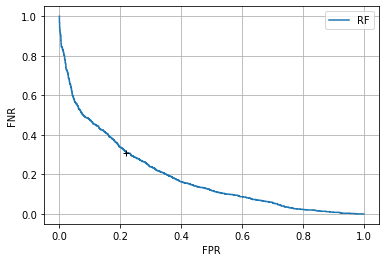

In [147]:
# to further inspect the performance:
CM = confusion_matrix(gb_y_valid, gb_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
gb_y_prob = grid_search.predict_proba(gb_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(gb_y_valid, gb_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is quite high: **0.54**. The algorithm does worse than the random.

## 8/ XGBoost 

### Algorithm Explanation

```XGBoost``` is an improved version of the ```Gradient Boosting``` algorithm. Indeed, it relies on a set of "weak learners" who predict the residuals, and correct the errors of the previous "weak learners".

The main difference between ```XGBoost``` and other implementations of the ```Gradient Boosting``` method is that ```XGBoost``` is computationally optimized to make the various computations required to apply ```Gradient Boosting``` faster. Specifically, ```XGBoost``` processes data in multiple compressed blocks allowing for much faster sorting and parallel processing.

But the advantages of ```XGBoost``` are not only linked to the implementation of the algorithm, and thus to its performance, but also to the various parameters it offers. Indeed ```XGBoost``` offers a panel of very important hyperparameters; it is thus possible thanks to this diversity of parameters, to have a total control on the implementation of ```Gradient Boosting``` It is also possible to add different regularizations to the loss function, limiting a phenomenon that happens quite often when using gradient boosting algorithms: overfitting. 



### Parameter choices strategy

For the choice of the parameters of this algorithm I took the decision to find the best parameters of the algorithm manually in order to be able to keep the hand on the refinement of the model which is not the case with a grid search.

The strategy I have implemented is as follows:

**1/** Firstly I intialize the hyperparameters of the model by filling reasonable values for key inputs:
- ```learning_rate: 0.01```
- ```n_estimators: 100``` because I train the model on the entire train dataset
- ```max_depth: 3```
- ```subsample: 0.8```
- ```colsample_bytree: 1```
- ```gamma: 1```
- ```objective='binary:logistic'``` 

I use logistic regression for binary classification as objective function, because it is the most suitable objective function for the binary classification task of this data challenge

**2/** Run ```model.fit(eval_set, eval_metric)``` and diagnose the first run, specifically the ```n_estimators``` parameter. After several iterations I noticed that beyond **103 estimators** the performance drops. So I set the parameter to **103** before varying the other most important parameters of ```XGBoost``` and analyze their influence on the performance of the model

**3/** Optimize ```max_depth``` parameter. It represents the depth of each tree, which is the maximum number of different features used in each tree. To find the best value of this parameter I firstly chose going from a low ```max_depth``` (3 for instance) and then increasing it incrementally by 1, and stopping when there’s no performance gain of increasing it. It is necessary to handle this parameter with care, because if this parameter is too high it can lead to overfitting the model. 

**4/** Try different value of learning rate and the features that avoids overfitting:
- ```learning_rate```: A lower learning rate can increase the prediction performance but increase the training time of the algorithm. I chose a learning rate at **0.3** because after several iterations of the algorithm it is the one that offers the best compromise performance/training time.  
- ```subsample```, which is for each tree the % of rows taken to build the tree. I choose the default parameter which is **1** because not taking out too many rows, as performance will drop a lot.

- ```colsample_bytree```:  It is the number of columns used by each tree. I set this parameter because at **1** I use a few features of my dataset.

- ```gamma```: It acts as a regularization parameter. I use the default parameter because in my case I found that changing the value of this parmeter did not influence the performance 

### 1st XGBoost Approach

#### Build sample of train data

In [74]:
# # build sample of train data
temp_data = train_raw.sample(n=int(round(X_train.shape[0] * 1,0)), random_state=140)

X_train_reduce = temp_data.loc[:,best_selected_features]
y_train_reduce = temp_data.loc[:,["label_0"]]

#### Split data

In [75]:
# split into X_train, y_train, X_valid and y_valid
xgbc_X_train, xgbc_X_valid, xgbc_y_train, xgbc_y_valid = train_test_split(X_train_reduce, y_train_reduce, test_size=0.2, random_state=122, stratify=y_df_cleaned)

#### Define hyperparameters and fit the model

In [76]:
%%time

# fit model no training data
xgbc = XGBClassifier(booster='gbtree', learning_rate=0.3, 
                     max_depth=6, n_estimators=103, 
                     colsample_bynode=1, colsample_bytree=1,
                     subsample=1, gamma=0, objective='binary:logistic')
xgbc.fit(xgbc_X_train, xgbc_y_train)

Wall time: 44.6 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=103, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Compute FPR + FNR score 

In [77]:
xgbc_y_pred = xgbc.predict(xgbc_X_valid)
valid_score = criterion(xgbc_y_pred, xgbc_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.4495025716541925


#### To further inspect the performance

Confusion Matrix: 
 [[23575  5955]
 [ 7412 22494]]
Accuracy: 0.775102631401844
False Positive Rate: 0.2016593294954284
False Negative Rate: 0.24784324215876413
FPR + FNR = 0.4495025716541925


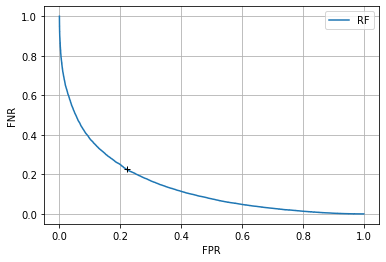

In [79]:
# to further inspect the performance:
CM = confusion_matrix(xgbc_y_valid, xgbc_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
gb_y_prob = xgbc.predict_proba(xgbc_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(xgbc_y_valid, gb_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is lower that I obtained with ```XGBoost``` for this data challenge: **0.45**. Not surprisingly, the performance of ```XGBoost``` are the best.

### 2nd XGBoost Approach

It seems that the XGBoost model is the model that gives the best performance. The idea is to improve the performance of 1st XGBoost Approach model. To do this, I want to see if training the model on the whole training dataset gives better results and then fine-tune the hyperparameters of the model.

Let's try to run XGBoost on the entire dataset without taken into account the features selected.

#### Split whole dataset

In [65]:
# split into X_train, y_train, X_valid and y_valid
xgbc_X_train, xgbc_X_valid, xgbc_y_train, xgbc_y_valid = train_test_split(X_dataframe, y_dataframe, test_size=0.2, random_state=12)

In [66]:
%%time

# fit model
xgbc = XGBClassifier(booster='gbtree', learning_rate=0.3, 
                     max_depth=6, n_estimators=103, 
                     colsample_bynode=1, colsample_bytree=1,
                     subsample=1, gamma=0, objective='binary:logistic')

xgbc.fit(xgbc_X_train, xgbc_y_train)

Wall time: 2min 15s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=103, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Define hyperparameters and fit the model

In [67]:
xgbc_y_pred = xgbc.predict(xgbc_X_valid)
valid_score = criterion(xgbc_y_pred, xgbc_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.400374619529163


#### To further inspect the performance

Confusion Matrix: 
 [[24238  5471]
 [ 6430 23308]]
Accuracy: 0.7998048682019278
False Positive Rate: 0.1841529502844256
False Negative Rate: 0.21622166924473737
FPR + FNR = 0.400374619529163


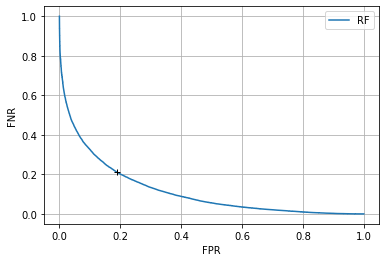

In [68]:
# to further inspect the performance:
CM = confusion_matrix(xgbc_y_valid, xgbc_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
gb_y_prob = xgbc.predict_proba(xgbc_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(xgbc_y_valid, gb_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is the slower for this notebook: **0.40**. Indeed, I managed to greatly improve the classification performance of my model by using all the features of the dataset. This is a very surprising thing. It means that training the model on the dataset with a limited number of features reduces the performances. Therefore, the variable selection for this data challenge does not seem to improve the performance of the models. 

### Note 

As we have just seen with the implementation of the ```XGBoost``` model, training the model on the whole dataset at our disposal leads to better performance. Therefore, for the rest of this notebook, I will directly train the next models on the whole dataset.  

Moreover, we could notice that it is the boosting algorithms that provide the best performances for the moment. There are other boosting algorithms which are an improvement of the ```XGBoost``` model like ```LightGBM``` and ```CatBoost```. It is therefore necessary to test the performance of these models on our dataset

## 9/ LightGBM 

### Algorithm Explanation

Similar to ```XGBoost```, ```LightGBM``` developped by Microsoft is a high-performance distributed framework that uses decision trees for ranking, classification and regression tasks. ```LightGBM``` is significantly faster than ```XGBoost``` but delivers almost equivalent performance. Faster training speed and accuracy resulting from ```LightGBM``` being a histogram-based algorithm that performs bucketing of values that also requires less memory. One of the strong points of is that ```LightGBM``` is also compatible with large and complex datasets but is much faster during training. 

In contrast to the level-wise (horizontal) growth in ```XGBoost```, ```LightGBM``` carries out leaf-wise (vertical) growth that results in more loss reduction and in turn higher accuracy while being faster. But this may also result in overfitting on the training data which could be handled using the max-depth parameter that specifies where the splitting would occur. Hence, ```XGBoost``` is capable of building more robust models than ```LightGBM```.


### Parameter choices strategy

As I said previously, Since ```LightGBM``` is similar to ```XGBoost```, these two models share broadly the same parameters. Therefore, I used the same strategy for parameter refinement as the one used when implementing the ```XGBoost``` model

Hence, since ```LightGBM``` is similar to XGBoost, these two models share broadly the same parameters. Therefore, I used the same strategy for parameter refinement as the one used when implementing the XGBoost model. First, I initialize the model hyperparameters by filling in reasonable values for the key inputs : 

- ```learning_rate: 0.3```
- ```n_estimators: 100``` because I train the model on the entire train dataset
- ```max_depth: 3```
- ```subsample: 0.8```
- ```colsample_bytree: 1```
- ```objective='binary'```

Then I refined the parameters by hand instead of using a grid search because I wanted to keep the total control on the optimization of the parameters (```max_depth```, ```learning_rate```, ```n_estimators```,...) by modifying very finely each parameter on a case by case basis to obtain the best model for our classification task. 

As a result, for the optimal choice of hyperparameters for the ```LightGBM``` algorithm, I used a lower learning rate than I set for the XGBoost model and a much larger number of estimators. This can be explained in part by the difference in strategy between XGBoost and LighGBM regarding the level-wise growth strategy that I mentioned before.

But globally the best parameters I used are very similar to those I used for XGBoost (same ```max_depth``` value, same ```colsample_bynode``` value, ```colsample_bytree``` value, ```subsample``` value).  This confirms the choices I made during the XGBoost algorithm since the models are globally based on the same operation 

#### Split data

In [82]:
lgbc_X_train, lgbc_X_valid, lgbc_y_train, lgbc_y_valid = train_test_split(X_dataframe, y, test_size=0.2, random_state=34)

#### Define hyperparameters and fit the model

In [83]:
%%time

# fit model no training data
lgbc = LGBMClassifier(objective= 'binary', learning_rate=0.1, n_estimators = 2000, 
                      max_depth=6, colsample_bynode=1, colsample_bytree=1, 
                      subsample=1)

lgbc.fit(lgbc_X_train, lgbc_y_train, verbose=True)

Wall time: 1min 19s


LGBMClassifier(colsample_bynode=1, colsample_bytree=1, max_depth=6,
               n_estimators=2000, objective='binary', subsample=1)

#### Compute FPR + FNR score

In [84]:
lgbc_y_pred = lgbc.predict(lgbc_X_valid)
valid_score = criterion(lgbc_y_pred, lgbc_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.39082887665052807


#### To further inspect the performance

Confusion Matrix: 
 [[24255  5388]
 [ 6231 23573]]
Accuracy: 0.8045485894998906
False Positive Rate: 0.1817629794555207
False Negative Rate: 0.20906589719500737
FPR + FNR = 0.39082887665052807


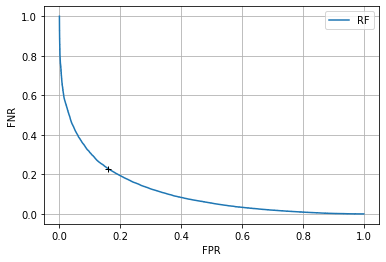

In [85]:
# to further inspect the performance:
CM = confusion_matrix(lgbc_y_valid, lgbc_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
gb_y_prob = lgbc.predict_proba(lgbc_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(lgbc_y_valid, gb_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is the lower for this notebook: **0.39**. ```LightGBM``` outperforms ```XGBoost```. Maybe it's just because I'm taking advantage of LightGBM's improvements or simply because of a better choice of hyperparameters or both at the same time. In any case, LightGBM is the best model to perform the classification task for this data challenge

## 10/ CatBoost 

### Algorithm Explanation

```CatBoost``` is an open-source machine learning (gradient boosting) algorithm, whose name comes from "Category" and "Boosting".

```CatBoost``` builds symmetric (balanced) trees, unlike ```XGBoost``` and ```LightGBM```. At each step, the leaves of the previous tree are split using the same condition. The feature-split pair that represents the lowest loss is selected and used for all nodes in the tier. This balanced tree architecture facilitates efficient processor implementation, reduces prediction time, makes model applicators fast, and controls overfitting as the structure serves as a regularization. 

Classic boosting algorithms are prone to overfitting on small/noisy data sets due to a problem known as prediction lag. When computing the gradient estimate of a data instance, these algorithms use the same data instances with which the model was built, thus having no chance of encountering unseen data. ```CatBoost```, on the other hand, uses the concept of ordered boosting, a permutation-based approach to train the model on one subset of the data while computing residuals on another subset, thus preventing target leakage and overfitting.  

Globally, ```CatBoost``` is based on the same principle, namely the boosting technique, but integrates new approaches that allow it to be in some cases more efficient than ```XGBoost``` and ```LightGBM```, both in terms of prediction time and accuracy of the generated prediction.

### Parameter choices strategy

As I said previously, Since ```CatBoost``` is similar to ```XGBoost``` and ```LightGBM```, these two models share broadly the same parameters. Therefore, I used the same strategy for parameter refinement as the one used when implementing the ```XGBoost``` model

Hence, since ```LightGBM``` is similar to XGBoost, these two models share broadly the same parameters. Therefore, I used the same strategy for parameter refinement as the one used when implementing the XGBoost model. First, I initialize the model hyperparameters by filling in reasonable values for the key inputs : 

- ```learning_rate: 0.3```
- ```iteration: 1000``` equivalent to ```n_estimators``` for ```XGBoost``` and ```LightGBM```
- ```subsample: 1```
- ```eval_metric='LogLoss'``` similar to ```objective:binary:logistic``` for ```XGBoost```

Then I refined the parameters by hand instead of using a grid search because I wanted to keep the total control on the optimization of the parameters (```learning_rate```, ```iteration```, ```subsample```,...) by modifying very finely each parameter on a case by case basis to obtain the best model for our classification task. 

As a result, for the optimal choice of hyperparameters for the ```LightGBM``` algorithm, I used the same learning rate than I set for the ```LightGBM``` model and a much larger number of estimators than ```XGBoost``` but less than ```LightGBM```.
Moreover I set a lower value for the ```subsample``` hyperparameter than I set for ```LightGBM``` and ```XGBoost```. 

#### Split whole dataset

In [86]:
catgbc_X_train, catgbc_X_valid, catgbc_y_train, catgbc_y_valid = train_test_split(X_dataframe, y, test_size=0.2, random_state=12)

#### Define hyperparameters and fit the mode

In [87]:
%%time

# fit model no training data
catgbc = CatBoostClassifier(eval_metric= 'Logloss', iterations= 1500, 
                            learning_rate= 0.1, subsample= 0.8)

catgbc.fit(catgbc_X_train, catgbc_y_train, verbose=True)

0:	learn: 0.6650869	total: 329ms	remaining: 8m 13s
1:	learn: 0.6411800	total: 486ms	remaining: 6m 4s
2:	learn: 0.6217118	total: 633ms	remaining: 5m 15s
3:	learn: 0.6048473	total: 858ms	remaining: 5m 21s
4:	learn: 0.5923338	total: 1.04s	remaining: 5m 9s
5:	learn: 0.5807152	total: 1.21s	remaining: 5m
6:	learn: 0.5709959	total: 1.36s	remaining: 4m 50s
7:	learn: 0.5621674	total: 1.6s	remaining: 4m 58s
8:	learn: 0.5539617	total: 1.79s	remaining: 4m 56s
9:	learn: 0.5481931	total: 1.94s	remaining: 4m 49s
10:	learn: 0.5421322	total: 2.15s	remaining: 4m 50s
11:	learn: 0.5363346	total: 2.4s	remaining: 4m 57s
12:	learn: 0.5319680	total: 2.65s	remaining: 5m 3s
13:	learn: 0.5275236	total: 2.92s	remaining: 5m 10s
14:	learn: 0.5238307	total: 3.15s	remaining: 5m 11s
15:	learn: 0.5207628	total: 3.39s	remaining: 5m 14s
16:	learn: 0.5173554	total: 3.62s	remaining: 5m 15s
17:	learn: 0.5139151	total: 3.86s	remaining: 5m 18s
18:	learn: 0.5111380	total: 4.1s	remaining: 5m 19s
19:	learn: 0.5086079	total: 4.29

158:	learn: 0.4280544	total: 25.1s	remaining: 3m 31s
159:	learn: 0.4276702	total: 25.3s	remaining: 3m 31s
160:	learn: 0.4272829	total: 25.4s	remaining: 3m 31s
161:	learn: 0.4271417	total: 25.5s	remaining: 3m 30s
162:	learn: 0.4268727	total: 25.7s	remaining: 3m 30s
163:	learn: 0.4267120	total: 25.8s	remaining: 3m 29s
164:	learn: 0.4265385	total: 25.9s	remaining: 3m 29s
165:	learn: 0.4262944	total: 26s	remaining: 3m 29s
166:	learn: 0.4261242	total: 26.2s	remaining: 3m 28s
167:	learn: 0.4259579	total: 26.3s	remaining: 3m 28s
168:	learn: 0.4257445	total: 26.5s	remaining: 3m 28s
169:	learn: 0.4255745	total: 26.6s	remaining: 3m 28s
170:	learn: 0.4254542	total: 26.7s	remaining: 3m 27s
171:	learn: 0.4252638	total: 26.8s	remaining: 3m 27s
172:	learn: 0.4250217	total: 26.9s	remaining: 3m 26s
173:	learn: 0.4248191	total: 27.1s	remaining: 3m 26s
174:	learn: 0.4245686	total: 27.2s	remaining: 3m 26s
175:	learn: 0.4242933	total: 27.3s	remaining: 3m 25s
176:	learn: 0.4241383	total: 27.5s	remaining: 3m

316:	learn: 0.4081701	total: 45.1s	remaining: 2m 48s
317:	learn: 0.4080834	total: 45.3s	remaining: 2m 48s
318:	learn: 0.4080161	total: 45.4s	remaining: 2m 48s
319:	learn: 0.4079224	total: 45.5s	remaining: 2m 47s
320:	learn: 0.4078398	total: 45.6s	remaining: 2m 47s
321:	learn: 0.4077585	total: 45.7s	remaining: 2m 47s
322:	learn: 0.4076920	total: 45.9s	remaining: 2m 47s
323:	learn: 0.4076169	total: 46s	remaining: 2m 47s
324:	learn: 0.4075533	total: 46.2s	remaining: 2m 46s
325:	learn: 0.4074743	total: 46.3s	remaining: 2m 46s
326:	learn: 0.4073945	total: 46.4s	remaining: 2m 46s
327:	learn: 0.4072975	total: 46.5s	remaining: 2m 46s
328:	learn: 0.4072449	total: 46.6s	remaining: 2m 45s
329:	learn: 0.4071576	total: 46.8s	remaining: 2m 45s
330:	learn: 0.4070725	total: 46.9s	remaining: 2m 45s
331:	learn: 0.4069988	total: 47s	remaining: 2m 45s
332:	learn: 0.4069070	total: 47.1s	remaining: 2m 45s
333:	learn: 0.4068473	total: 47.2s	remaining: 2m 44s
334:	learn: 0.4067860	total: 47.4s	remaining: 2m 4

472:	learn: 0.3971352	total: 1m 6s	remaining: 2m 25s
473:	learn: 0.3970757	total: 1m 7s	remaining: 2m 25s
474:	learn: 0.3970242	total: 1m 7s	remaining: 2m 25s
475:	learn: 0.3969724	total: 1m 7s	remaining: 2m 25s
476:	learn: 0.3968133	total: 1m 7s	remaining: 2m 24s
477:	learn: 0.3967645	total: 1m 7s	remaining: 2m 24s
478:	learn: 0.3967168	total: 1m 7s	remaining: 2m 24s
479:	learn: 0.3966544	total: 1m 8s	remaining: 2m 24s
480:	learn: 0.3965942	total: 1m 8s	remaining: 2m 24s
481:	learn: 0.3965477	total: 1m 8s	remaining: 2m 24s
482:	learn: 0.3964994	total: 1m 8s	remaining: 2m 24s
483:	learn: 0.3964573	total: 1m 8s	remaining: 2m 23s
484:	learn: 0.3964095	total: 1m 8s	remaining: 2m 23s
485:	learn: 0.3963579	total: 1m 8s	remaining: 2m 23s
486:	learn: 0.3962910	total: 1m 9s	remaining: 2m 23s
487:	learn: 0.3962304	total: 1m 9s	remaining: 2m 23s
488:	learn: 0.3961649	total: 1m 9s	remaining: 2m 23s
489:	learn: 0.3960969	total: 1m 9s	remaining: 2m 23s
490:	learn: 0.3960433	total: 1m 9s	remaining: 

625:	learn: 0.3884614	total: 1m 29s	remaining: 2m 5s
626:	learn: 0.3884014	total: 1m 30s	remaining: 2m 5s
627:	learn: 0.3883480	total: 1m 30s	remaining: 2m 5s
628:	learn: 0.3882946	total: 1m 30s	remaining: 2m 4s
629:	learn: 0.3881700	total: 1m 30s	remaining: 2m 4s
630:	learn: 0.3881203	total: 1m 30s	remaining: 2m 4s
631:	learn: 0.3880587	total: 1m 30s	remaining: 2m 4s
632:	learn: 0.3879912	total: 1m 30s	remaining: 2m 4s
633:	learn: 0.3879399	total: 1m 30s	remaining: 2m 4s
634:	learn: 0.3878936	total: 1m 31s	remaining: 2m 4s
635:	learn: 0.3878363	total: 1m 31s	remaining: 2m 3s
636:	learn: 0.3877865	total: 1m 31s	remaining: 2m 3s
637:	learn: 0.3877409	total: 1m 31s	remaining: 2m 3s
638:	learn: 0.3876936	total: 1m 31s	remaining: 2m 3s
639:	learn: 0.3876419	total: 1m 31s	remaining: 2m 3s
640:	learn: 0.3875909	total: 1m 31s	remaining: 2m 2s
641:	learn: 0.3875415	total: 1m 31s	remaining: 2m 2s
642:	learn: 0.3874950	total: 1m 32s	remaining: 2m 2s
643:	learn: 0.3874467	total: 1m 32s	remaining:

779:	learn: 0.3806842	total: 1m 50s	remaining: 1m 41s
780:	learn: 0.3806260	total: 1m 50s	remaining: 1m 41s
781:	learn: 0.3805775	total: 1m 50s	remaining: 1m 41s
782:	learn: 0.3805161	total: 1m 50s	remaining: 1m 41s
783:	learn: 0.3804569	total: 1m 50s	remaining: 1m 41s
784:	learn: 0.3804007	total: 1m 50s	remaining: 1m 41s
785:	learn: 0.3803715	total: 1m 51s	remaining: 1m 40s
786:	learn: 0.3803262	total: 1m 51s	remaining: 1m 40s
787:	learn: 0.3802802	total: 1m 51s	remaining: 1m 40s
788:	learn: 0.3802572	total: 1m 51s	remaining: 1m 40s
789:	learn: 0.3802121	total: 1m 51s	remaining: 1m 40s
790:	learn: 0.3801709	total: 1m 51s	remaining: 1m 40s
791:	learn: 0.3801121	total: 1m 51s	remaining: 1m 39s
792:	learn: 0.3800630	total: 1m 51s	remaining: 1m 39s
793:	learn: 0.3800083	total: 1m 52s	remaining: 1m 39s
794:	learn: 0.3799740	total: 1m 52s	remaining: 1m 39s
795:	learn: 0.3799113	total: 1m 52s	remaining: 1m 39s
796:	learn: 0.3798570	total: 1m 52s	remaining: 1m 39s
797:	learn: 0.3798044	total:

934:	learn: 0.3732247	total: 2m 11s	remaining: 1m 19s
935:	learn: 0.3731840	total: 2m 11s	remaining: 1m 19s
936:	learn: 0.3731379	total: 2m 11s	remaining: 1m 18s
937:	learn: 0.3730923	total: 2m 11s	remaining: 1m 18s
938:	learn: 0.3730461	total: 2m 11s	remaining: 1m 18s
939:	learn: 0.3729955	total: 2m 11s	remaining: 1m 18s
940:	learn: 0.3729593	total: 2m 11s	remaining: 1m 18s
941:	learn: 0.3729272	total: 2m 11s	remaining: 1m 18s
942:	learn: 0.3728791	total: 2m 12s	remaining: 1m 18s
943:	learn: 0.3728274	total: 2m 12s	remaining: 1m 17s
944:	learn: 0.3727958	total: 2m 12s	remaining: 1m 17s
945:	learn: 0.3727491	total: 2m 12s	remaining: 1m 17s
946:	learn: 0.3727125	total: 2m 12s	remaining: 1m 17s
947:	learn: 0.3726754	total: 2m 12s	remaining: 1m 17s
948:	learn: 0.3726201	total: 2m 12s	remaining: 1m 17s
949:	learn: 0.3725552	total: 2m 12s	remaining: 1m 16s
950:	learn: 0.3725202	total: 2m 12s	remaining: 1m 16s
951:	learn: 0.3724794	total: 2m 13s	remaining: 1m 16s
952:	learn: 0.3724507	total:

1087:	learn: 0.3666670	total: 2m 29s	remaining: 56.7s
1088:	learn: 0.3666148	total: 2m 29s	remaining: 56.6s
1089:	learn: 0.3665645	total: 2m 29s	remaining: 56.4s
1090:	learn: 0.3665158	total: 2m 30s	remaining: 56.3s
1091:	learn: 0.3664683	total: 2m 30s	remaining: 56.1s
1092:	learn: 0.3664250	total: 2m 30s	remaining: 56s
1093:	learn: 0.3663731	total: 2m 30s	remaining: 55.8s
1094:	learn: 0.3663287	total: 2m 30s	remaining: 55.7s
1095:	learn: 0.3662812	total: 2m 30s	remaining: 55.6s
1096:	learn: 0.3662402	total: 2m 30s	remaining: 55.4s
1097:	learn: 0.3662114	total: 2m 30s	remaining: 55.3s
1098:	learn: 0.3661682	total: 2m 31s	remaining: 55.1s
1099:	learn: 0.3661417	total: 2m 31s	remaining: 55s
1100:	learn: 0.3660912	total: 2m 31s	remaining: 54.9s
1101:	learn: 0.3660409	total: 2m 31s	remaining: 54.7s
1102:	learn: 0.3659835	total: 2m 31s	remaining: 54.6s
1103:	learn: 0.3659409	total: 2m 31s	remaining: 54.4s
1104:	learn: 0.3659353	total: 2m 31s	remaining: 54.3s
1105:	learn: 0.3658807	total: 2m

1241:	learn: 0.3601981	total: 2m 48s	remaining: 35.1s
1242:	learn: 0.3601563	total: 2m 48s	remaining: 34.9s
1243:	learn: 0.3601144	total: 2m 49s	remaining: 34.8s
1244:	learn: 0.3600780	total: 2m 49s	remaining: 34.6s
1245:	learn: 0.3600301	total: 2m 49s	remaining: 34.5s
1246:	learn: 0.3600037	total: 2m 49s	remaining: 34.4s
1247:	learn: 0.3599643	total: 2m 49s	remaining: 34.2s
1248:	learn: 0.3599293	total: 2m 49s	remaining: 34.1s
1249:	learn: 0.3598949	total: 2m 49s	remaining: 33.9s
1250:	learn: 0.3598455	total: 2m 49s	remaining: 33.8s
1251:	learn: 0.3598012	total: 2m 49s	remaining: 33.7s
1252:	learn: 0.3597568	total: 2m 50s	remaining: 33.5s
1253:	learn: 0.3597271	total: 2m 50s	remaining: 33.4s
1254:	learn: 0.3596780	total: 2m 50s	remaining: 33.2s
1255:	learn: 0.3596289	total: 2m 50s	remaining: 33.1s
1256:	learn: 0.3595973	total: 2m 50s	remaining: 33s
1257:	learn: 0.3595601	total: 2m 50s	remaining: 32.8s
1258:	learn: 0.3595106	total: 2m 50s	remaining: 32.7s
1259:	learn: 0.3594902	total: 

1395:	learn: 0.3540900	total: 3m 7s	remaining: 14s
1396:	learn: 0.3540294	total: 3m 7s	remaining: 13.8s
1397:	learn: 0.3539862	total: 3m 7s	remaining: 13.7s
1398:	learn: 0.3539392	total: 3m 7s	remaining: 13.6s
1399:	learn: 0.3539022	total: 3m 7s	remaining: 13.4s
1400:	learn: 0.3538627	total: 3m 8s	remaining: 13.3s
1401:	learn: 0.3538294	total: 3m 8s	remaining: 13.2s
1402:	learn: 0.3537836	total: 3m 8s	remaining: 13s
1403:	learn: 0.3537431	total: 3m 8s	remaining: 12.9s
1404:	learn: 0.3537081	total: 3m 8s	remaining: 12.7s
1405:	learn: 0.3536673	total: 3m 8s	remaining: 12.6s
1406:	learn: 0.3536350	total: 3m 8s	remaining: 12.5s
1407:	learn: 0.3536109	total: 3m 8s	remaining: 12.3s
1408:	learn: 0.3535739	total: 3m 8s	remaining: 12.2s
1409:	learn: 0.3535470	total: 3m 9s	remaining: 12.1s
1410:	learn: 0.3535019	total: 3m 9s	remaining: 11.9s
1411:	learn: 0.3534622	total: 3m 9s	remaining: 11.8s
1412:	learn: 0.3534104	total: 3m 9s	remaining: 11.7s
1413:	learn: 0.3533745	total: 3m 9s	remaining: 11.

#### Compute FPR + FNR score

In [88]:
catgbc_y_pred = catgbc.predict(catgbc_X_valid)
valid_score = criterion(catgbc_y_pred, catgbc_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.3870198716688109


#### To further inspect the performance

Confusion Matrix: 
 [[24385  5324]
 [ 6180 23558]]
Accuracy: 0.8064830857738826
False Positive Rate: 0.17920495472752365
False Negative Rate: 0.20781491694128723
FPR + FNR = 0.3870198716688109


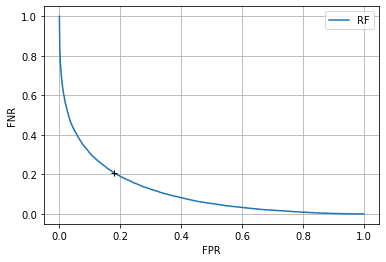

In [89]:
# to further inspect the performance:
CM = confusion_matrix(catgbc_y_valid, catgbc_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
gb_y_prob = catgbc.predict_proba(catgbc_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(catgbc_y_valid, gb_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is the lower for this notebook: **0.38**. ``CatBoost`` provides better performance than ``XGBoost`` and ``LightGBM`` on the binary classification task.

## 11/ Voting Classifier

The voting classifier aggregates the predicted class or predicted probability on basis of hard voting or soft voting. So if the goal is to feed a variety of base models to the voting classifier it makes sure to resolve the error by any model. 

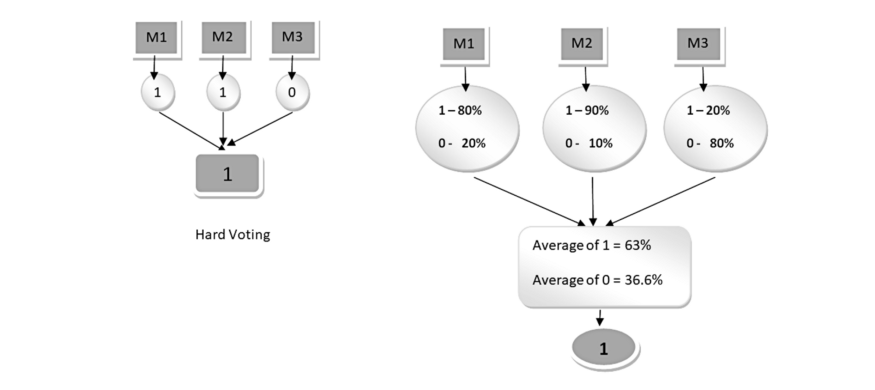

_Source : https://towardsdatascience.com/use-voting-classifier-to-improve-the-performance-of-your-ml-model-805345f9de0e_

To implement the Voting Classifier I use the ``VotingClassifier`` lib from ``scikit-learn``. 

Moreover I use the ``voting: hard`` hyperparameter simply because majority vote strategy improve performance. That means, the class most predicted by the 3 boosting models is the final class predicted by the voting classifier model. 

I choose two models encompassing the 3 best classifiers which are ``XGBoost``, ``LightGBM``, ``CatBoost``. For each classifier, I use the best hyperparameters that I defined when I implemented these classifiers independently.

### 1st Approach : Majority Vote (Hard Voting)

#### Split whole dataset

In [93]:
voting_gbc_X_train, voting_gbc_X_valid, voting_gbc_y_train, voting_gbc_y_valid = train_test_split(X_dataframe, y, test_size=0.2, random_state=57)

#### Define hyperparameters and fit the model

In [94]:
%%time

estimators = [
    ('xgbc', XGBClassifier(booster='gbtree', learning_rate=0.3, 
                     max_depth=6, n_estimators=103, 
                     colsample_bynode=1, colsample_bytree=1,
                     subsample=1, gamma=0, 
                     objective='binary:logistic', random_state=57)),
    
    ('lgbc', LGBMClassifier(objective= 'binary', 
                            n_estimators = 2000, random_state=57)),
    
    ('catgbc', CatBoostClassifier(eval_metric= 'Logloss', iterations= 1500, 
                                  learning_rate= 0.1, subsample= 0.8, random_state=57))
]

voting_clf = VotingClassifier(estimators=estimators, voting='hard')

voting_clf.fit(voting_gbc_X_train, voting_gbc_y_train)

0:	learn: 0.6649451	total: 141ms	remaining: 3m 30s
1:	learn: 0.6408262	total: 270ms	remaining: 3m 21s
2:	learn: 0.6222621	total: 408ms	remaining: 3m 23s
3:	learn: 0.6056707	total: 571ms	remaining: 3m 33s
4:	learn: 0.5923237	total: 723ms	remaining: 3m 36s
5:	learn: 0.5796092	total: 879ms	remaining: 3m 38s
6:	learn: 0.5701940	total: 1.03s	remaining: 3m 40s
7:	learn: 0.5614521	total: 1.19s	remaining: 3m 42s
8:	learn: 0.5539308	total: 1.36s	remaining: 3m 44s
9:	learn: 0.5471526	total: 1.51s	remaining: 3m 45s
10:	learn: 0.5414993	total: 1.68s	remaining: 3m 47s
11:	learn: 0.5359282	total: 1.86s	remaining: 3m 50s
12:	learn: 0.5309897	total: 2.03s	remaining: 3m 52s
13:	learn: 0.5271958	total: 2.16s	remaining: 3m 49s
14:	learn: 0.5229875	total: 2.32s	remaining: 3m 49s
15:	learn: 0.5202042	total: 2.48s	remaining: 3m 49s
16:	learn: 0.5164225	total: 2.65s	remaining: 3m 51s
17:	learn: 0.5139612	total: 2.78s	remaining: 3m 49s
18:	learn: 0.5111718	total: 2.95s	remaining: 3m 49s
19:	learn: 0.5085238	t

158:	learn: 0.4288062	total: 23.2s	remaining: 3m 15s
159:	learn: 0.4286485	total: 23.3s	remaining: 3m 15s
160:	learn: 0.4284836	total: 23.5s	remaining: 3m 15s
161:	learn: 0.4282930	total: 23.6s	remaining: 3m 14s
162:	learn: 0.4281037	total: 23.7s	remaining: 3m 14s
163:	learn: 0.4279654	total: 23.8s	remaining: 3m 14s
164:	learn: 0.4277494	total: 24s	remaining: 3m 14s
165:	learn: 0.4275762	total: 24.1s	remaining: 3m 13s
166:	learn: 0.4273726	total: 24.2s	remaining: 3m 13s
167:	learn: 0.4271790	total: 24.4s	remaining: 3m 13s
168:	learn: 0.4269579	total: 24.5s	remaining: 3m 12s
169:	learn: 0.4267745	total: 24.6s	remaining: 3m 12s
170:	learn: 0.4266005	total: 24.7s	remaining: 3m 12s
171:	learn: 0.4264697	total: 24.8s	remaining: 3m 11s
172:	learn: 0.4263351	total: 25s	remaining: 3m 11s
173:	learn: 0.4261825	total: 25.1s	remaining: 3m 11s
174:	learn: 0.4260034	total: 25.2s	remaining: 3m 10s
175:	learn: 0.4257574	total: 25.3s	remaining: 3m 10s
176:	learn: 0.4256100	total: 25.5s	remaining: 3m 1

315:	learn: 0.4090979	total: 42.3s	remaining: 2m 38s
316:	learn: 0.4090073	total: 42.5s	remaining: 2m 38s
317:	learn: 0.4088995	total: 42.6s	remaining: 2m 38s
318:	learn: 0.4087867	total: 42.7s	remaining: 2m 38s
319:	learn: 0.4087149	total: 42.8s	remaining: 2m 37s
320:	learn: 0.4086473	total: 42.9s	remaining: 2m 37s
321:	learn: 0.4085598	total: 43.1s	remaining: 2m 37s
322:	learn: 0.4084647	total: 43.2s	remaining: 2m 37s
323:	learn: 0.4083842	total: 43.3s	remaining: 2m 37s
324:	learn: 0.4083312	total: 43.4s	remaining: 2m 36s
325:	learn: 0.4082394	total: 43.5s	remaining: 2m 36s
326:	learn: 0.4081457	total: 43.6s	remaining: 2m 36s
327:	learn: 0.4080730	total: 43.7s	remaining: 2m 36s
328:	learn: 0.4079945	total: 43.8s	remaining: 2m 35s
329:	learn: 0.4079157	total: 43.9s	remaining: 2m 35s
330:	learn: 0.4078371	total: 44s	remaining: 2m 35s
331:	learn: 0.4077720	total: 44.1s	remaining: 2m 35s
332:	learn: 0.4076823	total: 44.2s	remaining: 2m 34s
333:	learn: 0.4076090	total: 44.3s	remaining: 2m

473:	learn: 0.3981421	total: 59.7s	remaining: 2m 9s
474:	learn: 0.3980793	total: 59.7s	remaining: 2m 8s
475:	learn: 0.3980121	total: 59.8s	remaining: 2m 8s
476:	learn: 0.3979451	total: 60s	remaining: 2m 8s
477:	learn: 0.3979029	total: 1m	remaining: 2m 8s
478:	learn: 0.3978648	total: 1m	remaining: 2m 8s
479:	learn: 0.3978078	total: 1m	remaining: 2m 8s
480:	learn: 0.3977530	total: 1m	remaining: 2m 7s
481:	learn: 0.3976928	total: 1m	remaining: 2m 7s
482:	learn: 0.3976292	total: 1m	remaining: 2m 7s
483:	learn: 0.3975728	total: 1m	remaining: 2m 7s
484:	learn: 0.3975070	total: 1m	remaining: 2m 7s
485:	learn: 0.3974447	total: 1m	remaining: 2m 7s
486:	learn: 0.3974061	total: 1m	remaining: 2m 6s
487:	learn: 0.3973579	total: 1m 1s	remaining: 2m 6s
488:	learn: 0.3973101	total: 1m 1s	remaining: 2m 6s
489:	learn: 0.3972447	total: 1m 1s	remaining: 2m 6s
490:	learn: 0.3972068	total: 1m 1s	remaining: 2m 6s
491:	learn: 0.3971429	total: 1m 1s	remaining: 2m 5s
492:	learn: 0.3970903	total: 1m 1s	remaining

630:	learn: 0.3895545	total: 1m 16s	remaining: 1m 45s
631:	learn: 0.3894962	total: 1m 16s	remaining: 1m 45s
632:	learn: 0.3894276	total: 1m 16s	remaining: 1m 45s
633:	learn: 0.3893746	total: 1m 16s	remaining: 1m 45s
634:	learn: 0.3893070	total: 1m 17s	remaining: 1m 44s
635:	learn: 0.3892427	total: 1m 17s	remaining: 1m 44s
636:	learn: 0.3891795	total: 1m 17s	remaining: 1m 44s
637:	learn: 0.3891224	total: 1m 17s	remaining: 1m 44s
638:	learn: 0.3890620	total: 1m 17s	remaining: 1m 44s
639:	learn: 0.3890262	total: 1m 17s	remaining: 1m 44s
640:	learn: 0.3889689	total: 1m 17s	remaining: 1m 44s
641:	learn: 0.3889056	total: 1m 17s	remaining: 1m 43s
642:	learn: 0.3888677	total: 1m 17s	remaining: 1m 43s
643:	learn: 0.3888063	total: 1m 17s	remaining: 1m 43s
644:	learn: 0.3887652	total: 1m 18s	remaining: 1m 43s
645:	learn: 0.3887105	total: 1m 18s	remaining: 1m 43s
646:	learn: 0.3886518	total: 1m 18s	remaining: 1m 43s
647:	learn: 0.3886171	total: 1m 18s	remaining: 1m 43s
648:	learn: 0.3885612	total:

783:	learn: 0.3818036	total: 1m 33s	remaining: 1m 25s
784:	learn: 0.3817675	total: 1m 33s	remaining: 1m 24s
785:	learn: 0.3817326	total: 1m 33s	remaining: 1m 24s
786:	learn: 0.3816920	total: 1m 33s	remaining: 1m 24s
787:	learn: 0.3816429	total: 1m 33s	remaining: 1m 24s
788:	learn: 0.3815849	total: 1m 33s	remaining: 1m 24s
789:	learn: 0.3815154	total: 1m 33s	remaining: 1m 24s
790:	learn: 0.3815120	total: 1m 33s	remaining: 1m 24s
791:	learn: 0.3814539	total: 1m 33s	remaining: 1m 23s
792:	learn: 0.3814005	total: 1m 33s	remaining: 1m 23s
793:	learn: 0.3813413	total: 1m 34s	remaining: 1m 23s
794:	learn: 0.3812877	total: 1m 34s	remaining: 1m 23s
795:	learn: 0.3812312	total: 1m 34s	remaining: 1m 23s
796:	learn: 0.3811903	total: 1m 34s	remaining: 1m 23s
797:	learn: 0.3811429	total: 1m 34s	remaining: 1m 23s
798:	learn: 0.3810934	total: 1m 34s	remaining: 1m 23s
799:	learn: 0.3810455	total: 1m 34s	remaining: 1m 22s
800:	learn: 0.3809833	total: 1m 34s	remaining: 1m 22s
801:	learn: 0.3809287	total:

937:	learn: 0.3745825	total: 1m 49s	remaining: 1m 5s
938:	learn: 0.3745684	total: 1m 49s	remaining: 1m 5s
939:	learn: 0.3745176	total: 1m 49s	remaining: 1m 5s
940:	learn: 0.3744712	total: 1m 50s	remaining: 1m 5s
941:	learn: 0.3744283	total: 1m 50s	remaining: 1m 5s
942:	learn: 0.3743917	total: 1m 50s	remaining: 1m 5s
943:	learn: 0.3743409	total: 1m 50s	remaining: 1m 4s
944:	learn: 0.3742894	total: 1m 50s	remaining: 1m 4s
945:	learn: 0.3742283	total: 1m 50s	remaining: 1m 4s
946:	learn: 0.3741778	total: 1m 50s	remaining: 1m 4s
947:	learn: 0.3741365	total: 1m 50s	remaining: 1m 4s
948:	learn: 0.3741052	total: 1m 50s	remaining: 1m 4s
949:	learn: 0.3740689	total: 1m 51s	remaining: 1m 4s
950:	learn: 0.3740251	total: 1m 51s	remaining: 1m 4s
951:	learn: 0.3739772	total: 1m 51s	remaining: 1m 4s
952:	learn: 0.3739665	total: 1m 51s	remaining: 1m 3s
953:	learn: 0.3739355	total: 1m 51s	remaining: 1m 3s
954:	learn: 0.3739035	total: 1m 51s	remaining: 1m 3s
955:	learn: 0.3738715	total: 1m 51s	remaining:

1094:	learn: 0.3678642	total: 2m 6s	remaining: 46.9s
1095:	learn: 0.3678284	total: 2m 7s	remaining: 46.8s
1096:	learn: 0.3677930	total: 2m 7s	remaining: 46.7s
1097:	learn: 0.3677384	total: 2m 7s	remaining: 46.6s
1098:	learn: 0.3676936	total: 2m 7s	remaining: 46.5s
1099:	learn: 0.3676542	total: 2m 7s	remaining: 46.4s
1100:	learn: 0.3676125	total: 2m 7s	remaining: 46.2s
1101:	learn: 0.3675625	total: 2m 7s	remaining: 46.1s
1102:	learn: 0.3675286	total: 2m 7s	remaining: 46s
1103:	learn: 0.3675065	total: 2m 7s	remaining: 45.9s
1104:	learn: 0.3674540	total: 2m 7s	remaining: 45.8s
1105:	learn: 0.3673993	total: 2m 8s	remaining: 45.6s
1106:	learn: 0.3673841	total: 2m 8s	remaining: 45.5s
1107:	learn: 0.3673468	total: 2m 8s	remaining: 45.4s
1108:	learn: 0.3672970	total: 2m 8s	remaining: 45.3s
1109:	learn: 0.3672498	total: 2m 8s	remaining: 45.2s
1110:	learn: 0.3672112	total: 2m 8s	remaining: 45s
1111:	learn: 0.3671827	total: 2m 8s	remaining: 44.9s
1112:	learn: 0.3671438	total: 2m 8s	remaining: 44.

1248:	learn: 0.3615738	total: 2m 24s	remaining: 29s
1249:	learn: 0.3615299	total: 2m 24s	remaining: 28.9s
1250:	learn: 0.3614847	total: 2m 24s	remaining: 28.8s
1251:	learn: 0.3614425	total: 2m 24s	remaining: 28.7s
1252:	learn: 0.3614009	total: 2m 24s	remaining: 28.5s
1253:	learn: 0.3613647	total: 2m 24s	remaining: 28.4s
1254:	learn: 0.3613359	total: 2m 25s	remaining: 28.3s
1255:	learn: 0.3612740	total: 2m 25s	remaining: 28.2s
1256:	learn: 0.3612352	total: 2m 25s	remaining: 28.1s
1257:	learn: 0.3611967	total: 2m 25s	remaining: 28s
1258:	learn: 0.3611474	total: 2m 25s	remaining: 27.9s
1259:	learn: 0.3611154	total: 2m 25s	remaining: 27.7s
1260:	learn: 0.3610666	total: 2m 25s	remaining: 27.6s
1261:	learn: 0.3610235	total: 2m 25s	remaining: 27.5s
1262:	learn: 0.3609904	total: 2m 25s	remaining: 27.4s
1263:	learn: 0.3609444	total: 2m 26s	remaining: 27.3s
1264:	learn: 0.3608970	total: 2m 26s	remaining: 27.2s
1265:	learn: 0.3608499	total: 2m 26s	remaining: 27s
1266:	learn: 0.3608050	total: 2m 2

1402:	learn: 0.3553220	total: 2m 43s	remaining: 11.3s
1403:	learn: 0.3552755	total: 2m 43s	remaining: 11.2s
1404:	learn: 0.3552296	total: 2m 43s	remaining: 11.1s
1405:	learn: 0.3551928	total: 2m 44s	remaining: 11s
1406:	learn: 0.3551630	total: 2m 44s	remaining: 10.9s
1407:	learn: 0.3551154	total: 2m 44s	remaining: 10.7s
1408:	learn: 0.3550714	total: 2m 44s	remaining: 10.6s
1409:	learn: 0.3550203	total: 2m 44s	remaining: 10.5s
1410:	learn: 0.3549807	total: 2m 44s	remaining: 10.4s
1411:	learn: 0.3549259	total: 2m 44s	remaining: 10.3s
1412:	learn: 0.3548952	total: 2m 45s	remaining: 10.2s
1413:	learn: 0.3548637	total: 2m 45s	remaining: 10s
1414:	learn: 0.3548315	total: 2m 45s	remaining: 9.93s
1415:	learn: 0.3547867	total: 2m 45s	remaining: 9.81s
1416:	learn: 0.3547476	total: 2m 45s	remaining: 9.69s
1417:	learn: 0.3546966	total: 2m 45s	remaining: 9.58s
1418:	learn: 0.3546536	total: 2m 45s	remaining: 9.46s
1419:	learn: 0.3546024	total: 2m 45s	remaining: 9.34s
1420:	learn: 0.3545566	total: 2m

VotingClassifier(estimators=[('xgbc',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.3,
                                            max_delta_step=None, max_depth=6,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=103, n_jobs=None,
                                            num_parallel_tree=None,
                    

#### Compute FPR + FNR score

In [95]:
voting_clf_y_pred = voting_clf.predict(voting_gbc_X_valid)
valid_score = criterion(voting_clf_y_pred, voting_gbc_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.3820401455229502


#### To further inspect the performance

Confusion Matrix: 
 [[24445  5263]
 [ 6093 23646]]
Accuracy: 0.8089726983699767
False Positive Rate: 0.17715766796822405
False Negative Rate: 0.2048824775547261
FPR + FNR = 0.3820401455229502


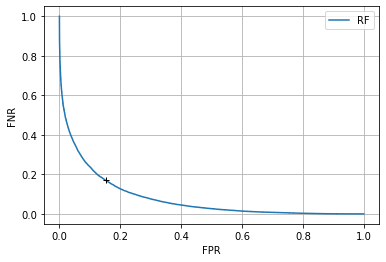

In [96]:
# to further inspect the performance:
CM = confusion_matrix(voting_gbc_y_valid, voting_clf_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
gb_y_prob = catgbc.predict_proba(voting_gbc_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(voting_gbc_y_valid, gb_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is the lower for this notebook: **0.382**. The voting system provides that encompass Three boosting models give better performance than ``XGBoost``, ``CatBoost`` and ``LightGBM`` on the binary classification task. Indeed, the combination of 3 models associated with a majority voting system definitely improves the performance on the binary classification task for this data challenge.

### 2dn Approach : (Soft Voting)

Predicts the class label based on the argmax of the sums of the predicted probabilities

#### Split whole dataset

In [14]:
voting_gbc_X_train, voting_gbc_X_valid, voting_gbc_y_train, voting_gbc_y_valid = train_test_split(X_dataframe, y, test_size=0.2, random_state=69)

#### Define hyperparameters and fit the model

In [15]:
%%time

estimators = [
    ('xgbc', XGBClassifier(booster='gbtree', learning_rate=0.3, 
                     max_depth=6, n_estimators=103, 
                     colsample_bynode=1, colsample_bytree=1,
                     subsample=1, gamma=0, 
                     objective='binary:logistic', random_state=69)),
    
    ('lgbc', LGBMClassifier(objective= 'binary', 
                            n_estimators = 2000, random_state=69)),
    
    ('catgbc', CatBoostClassifier(eval_metric= 'Logloss', iterations= 1500, 
                                  learning_rate= 0.1, subsample= 0.8, random_state=69))
]

voting_clf = VotingClassifier(estimators=estimators, voting='soft')

voting_clf.fit(voting_gbc_X_train, voting_gbc_y_train)

[23:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6644069	total: 123ms	remaining: 3m 4s
1:	learn: 0.6413879	total: 263ms	remaining: 3m 16s
2:	learn: 0.6217786	total: 428ms	remaining: 3m 33s
3:	learn: 0.6051211	total: 594ms	remaining: 3m 42s
4:	learn: 0.5915623	total: 770ms	remaining: 3m 50s
5:	learn: 0.5802356	total: 957ms	remaining: 3m 58s
6:	learn: 0.5701495	total: 1.2s	remaining: 4m 15s
7:	learn: 0.5619293	total: 1.39s	remaining: 4m 18s
8:	learn: 0.5541249	total: 1.61s	remaining: 4m 26s
9:	learn: 0.5476307	total: 1.8s	remaining: 4m 27s
10:	learn: 0.5417005	total: 2.03s	remaining: 4m 34s
11:	learn: 0.5359633	total: 2.2s	remaining: 4m 33s
12:	learn: 0.5315532	total: 2.4s	remaining: 4m 34s
13:	learn: 0.5280497	total: 2

153:	learn: 0.4314799	total: 21.7s	remaining: 3m 9s
154:	learn: 0.4312609	total: 21.9s	remaining: 3m 9s
155:	learn: 0.4311178	total: 22s	remaining: 3m 9s
156:	learn: 0.4309803	total: 22.1s	remaining: 3m 9s
157:	learn: 0.4308476	total: 22.3s	remaining: 3m 9s
158:	learn: 0.4306410	total: 22.4s	remaining: 3m 8s
159:	learn: 0.4304789	total: 22.6s	remaining: 3m 8s
160:	learn: 0.4302681	total: 22.7s	remaining: 3m 9s
161:	learn: 0.4301279	total: 22.9s	remaining: 3m 9s
162:	learn: 0.4299697	total: 23.1s	remaining: 3m 9s
163:	learn: 0.4298275	total: 23.2s	remaining: 3m 9s
164:	learn: 0.4293664	total: 23.4s	remaining: 3m 9s
165:	learn: 0.4290906	total: 23.5s	remaining: 3m 9s
166:	learn: 0.4289613	total: 23.7s	remaining: 3m 8s
167:	learn: 0.4288313	total: 23.8s	remaining: 3m 8s
168:	learn: 0.4285768	total: 23.9s	remaining: 3m 8s
169:	learn: 0.4284080	total: 24s	remaining: 3m 7s
170:	learn: 0.4281658	total: 24.1s	remaining: 3m 7s
171:	learn: 0.4280283	total: 24.3s	remaining: 3m 7s
172:	learn: 0.42

310:	learn: 0.4110142	total: 42.6s	remaining: 2m 42s
311:	learn: 0.4109105	total: 42.7s	remaining: 2m 42s
312:	learn: 0.4108364	total: 42.8s	remaining: 2m 42s
313:	learn: 0.4107501	total: 43s	remaining: 2m 42s
314:	learn: 0.4106352	total: 43.1s	remaining: 2m 42s
315:	learn: 0.4105547	total: 43.3s	remaining: 2m 42s
316:	learn: 0.4104820	total: 43.4s	remaining: 2m 41s
317:	learn: 0.4103838	total: 43.5s	remaining: 2m 41s
318:	learn: 0.4103083	total: 43.7s	remaining: 2m 41s
319:	learn: 0.4102127	total: 43.9s	remaining: 2m 41s
320:	learn: 0.4101327	total: 44.1s	remaining: 2m 41s
321:	learn: 0.4100511	total: 44.2s	remaining: 2m 41s
322:	learn: 0.4099918	total: 44.4s	remaining: 2m 41s
323:	learn: 0.4099156	total: 44.5s	remaining: 2m 41s
324:	learn: 0.4098480	total: 44.7s	remaining: 2m 41s
325:	learn: 0.4097526	total: 44.9s	remaining: 2m 41s
326:	learn: 0.4096916	total: 45s	remaining: 2m 41s
327:	learn: 0.4096110	total: 45.2s	remaining: 2m 41s
328:	learn: 0.4095292	total: 45.3s	remaining: 2m 4

466:	learn: 0.4000027	total: 1m 4s	remaining: 2m 22s
467:	learn: 0.3999457	total: 1m 4s	remaining: 2m 22s
468:	learn: 0.3998807	total: 1m 4s	remaining: 2m 22s
469:	learn: 0.3998550	total: 1m 4s	remaining: 2m 22s
470:	learn: 0.3997821	total: 1m 5s	remaining: 2m 22s
471:	learn: 0.3997138	total: 1m 5s	remaining: 2m 22s
472:	learn: 0.3996471	total: 1m 5s	remaining: 2m 21s
473:	learn: 0.3995858	total: 1m 5s	remaining: 2m 21s
474:	learn: 0.3995379	total: 1m 5s	remaining: 2m 21s
475:	learn: 0.3994610	total: 1m 5s	remaining: 2m 21s
476:	learn: 0.3993910	total: 1m 5s	remaining: 2m 21s
477:	learn: 0.3993276	total: 1m 6s	remaining: 2m 21s
478:	learn: 0.3992736	total: 1m 6s	remaining: 2m 21s
479:	learn: 0.3992190	total: 1m 6s	remaining: 2m 20s
480:	learn: 0.3991678	total: 1m 6s	remaining: 2m 20s
481:	learn: 0.3991011	total: 1m 6s	remaining: 2m 20s
482:	learn: 0.3990449	total: 1m 6s	remaining: 2m 20s
483:	learn: 0.3989953	total: 1m 6s	remaining: 2m 20s
484:	learn: 0.3989300	total: 1m 7s	remaining: 

622:	learn: 0.3912099	total: 1m 25s	remaining: 1m 59s
623:	learn: 0.3911808	total: 1m 25s	remaining: 1m 59s
624:	learn: 0.3911115	total: 1m 25s	remaining: 1m 59s
625:	learn: 0.3910676	total: 1m 25s	remaining: 1m 59s
626:	learn: 0.3910030	total: 1m 25s	remaining: 1m 59s
627:	learn: 0.3909758	total: 1m 25s	remaining: 1m 59s
628:	learn: 0.3909426	total: 1m 25s	remaining: 1m 59s
629:	learn: 0.3909034	total: 1m 26s	remaining: 1m 58s
630:	learn: 0.3908440	total: 1m 26s	remaining: 1m 58s
631:	learn: 0.3907892	total: 1m 26s	remaining: 1m 58s
632:	learn: 0.3907264	total: 1m 26s	remaining: 1m 58s
633:	learn: 0.3906719	total: 1m 26s	remaining: 1m 58s
634:	learn: 0.3906087	total: 1m 26s	remaining: 1m 58s
635:	learn: 0.3905623	total: 1m 26s	remaining: 1m 58s
636:	learn: 0.3905215	total: 1m 27s	remaining: 1m 57s
637:	learn: 0.3904772	total: 1m 27s	remaining: 1m 57s
638:	learn: 0.3904261	total: 1m 27s	remaining: 1m 57s
639:	learn: 0.3903706	total: 1m 27s	remaining: 1m 57s
640:	learn: 0.3903227	total:

774:	learn: 0.3834776	total: 1m 45s	remaining: 1m 38s
775:	learn: 0.3834241	total: 1m 45s	remaining: 1m 38s
776:	learn: 0.3833601	total: 1m 45s	remaining: 1m 38s
777:	learn: 0.3833083	total: 1m 46s	remaining: 1m 38s
778:	learn: 0.3832502	total: 1m 46s	remaining: 1m 38s
779:	learn: 0.3831859	total: 1m 46s	remaining: 1m 38s
780:	learn: 0.3831371	total: 1m 46s	remaining: 1m 38s
781:	learn: 0.3830982	total: 1m 46s	remaining: 1m 37s
782:	learn: 0.3830387	total: 1m 46s	remaining: 1m 37s
783:	learn: 0.3829861	total: 1m 46s	remaining: 1m 37s
784:	learn: 0.3829258	total: 1m 47s	remaining: 1m 37s
785:	learn: 0.3828731	total: 1m 47s	remaining: 1m 37s
786:	learn: 0.3828139	total: 1m 47s	remaining: 1m 37s
787:	learn: 0.3827589	total: 1m 47s	remaining: 1m 37s
788:	learn: 0.3827166	total: 1m 47s	remaining: 1m 36s
789:	learn: 0.3826700	total: 1m 47s	remaining: 1m 36s
790:	learn: 0.3826393	total: 1m 47s	remaining: 1m 36s
791:	learn: 0.3826010	total: 1m 47s	remaining: 1m 36s
792:	learn: 0.3825635	total:

928:	learn: 0.3763167	total: 2m 6s	remaining: 1m 18s
929:	learn: 0.3762654	total: 2m 7s	remaining: 1m 17s
930:	learn: 0.3762146	total: 2m 7s	remaining: 1m 17s
931:	learn: 0.3761636	total: 2m 7s	remaining: 1m 17s
932:	learn: 0.3761123	total: 2m 7s	remaining: 1m 17s
933:	learn: 0.3760586	total: 2m 7s	remaining: 1m 17s
934:	learn: 0.3760211	total: 2m 7s	remaining: 1m 17s
935:	learn: 0.3759685	total: 2m 8s	remaining: 1m 17s
936:	learn: 0.3759208	total: 2m 8s	remaining: 1m 17s
937:	learn: 0.3758772	total: 2m 8s	remaining: 1m 16s
938:	learn: 0.3758528	total: 2m 8s	remaining: 1m 16s
939:	learn: 0.3758030	total: 2m 8s	remaining: 1m 16s
940:	learn: 0.3757606	total: 2m 8s	remaining: 1m 16s
941:	learn: 0.3757173	total: 2m 8s	remaining: 1m 16s
942:	learn: 0.3756847	total: 2m 9s	remaining: 1m 16s
943:	learn: 0.3756504	total: 2m 9s	remaining: 1m 16s
944:	learn: 0.3756086	total: 2m 9s	remaining: 1m 16s
945:	learn: 0.3755667	total: 2m 9s	remaining: 1m 15s
946:	learn: 0.3755237	total: 2m 9s	remaining: 

1082:	learn: 0.3695466	total: 2m 30s	remaining: 58.1s
1083:	learn: 0.3695103	total: 2m 30s	remaining: 57.9s
1084:	learn: 0.3694797	total: 2m 31s	remaining: 57.8s
1085:	learn: 0.3694576	total: 2m 31s	remaining: 57.7s
1086:	learn: 0.3694196	total: 2m 31s	remaining: 57.5s
1087:	learn: 0.3693764	total: 2m 31s	remaining: 57.4s
1088:	learn: 0.3693322	total: 2m 31s	remaining: 57.2s
1089:	learn: 0.3692897	total: 2m 31s	remaining: 57.1s
1090:	learn: 0.3692506	total: 2m 31s	remaining: 56.9s
1091:	learn: 0.3692196	total: 2m 32s	remaining: 56.8s
1092:	learn: 0.3691673	total: 2m 32s	remaining: 56.7s
1093:	learn: 0.3691178	total: 2m 32s	remaining: 56.5s
1094:	learn: 0.3690699	total: 2m 32s	remaining: 56.4s
1095:	learn: 0.3690358	total: 2m 32s	remaining: 56.2s
1096:	learn: 0.3689895	total: 2m 32s	remaining: 56.1s
1097:	learn: 0.3689566	total: 2m 32s	remaining: 55.9s
1098:	learn: 0.3689186	total: 2m 32s	remaining: 55.8s
1099:	learn: 0.3688814	total: 2m 33s	remaining: 55.7s
1100:	learn: 0.3688498	total

1235:	learn: 0.3631949	total: 2m 51s	remaining: 36.5s
1236:	learn: 0.3631493	total: 2m 51s	remaining: 36.4s
1237:	learn: 0.3631131	total: 2m 51s	remaining: 36.3s
1238:	learn: 0.3630601	total: 2m 51s	remaining: 36.1s
1239:	learn: 0.3630121	total: 2m 51s	remaining: 36s
1240:	learn: 0.3629830	total: 2m 51s	remaining: 35.8s
1241:	learn: 0.3629533	total: 2m 51s	remaining: 35.7s
1242:	learn: 0.3629059	total: 2m 51s	remaining: 35.5s
1243:	learn: 0.3628630	total: 2m 52s	remaining: 35.4s
1244:	learn: 0.3628157	total: 2m 52s	remaining: 35.3s
1245:	learn: 0.3627714	total: 2m 52s	remaining: 35.1s
1246:	learn: 0.3627310	total: 2m 52s	remaining: 35s
1247:	learn: 0.3627039	total: 2m 52s	remaining: 34.8s
1248:	learn: 0.3626621	total: 2m 52s	remaining: 34.7s
1249:	learn: 0.3626294	total: 2m 52s	remaining: 34.5s
1250:	learn: 0.3625935	total: 2m 52s	remaining: 34.4s
1251:	learn: 0.3625416	total: 2m 52s	remaining: 34.3s
1252:	learn: 0.3624952	total: 2m 53s	remaining: 34.1s
1253:	learn: 0.3624737	total: 2m

1391:	learn: 0.3570100	total: 3m 11s	remaining: 14.8s
1392:	learn: 0.3569721	total: 3m 11s	remaining: 14.7s
1393:	learn: 0.3569151	total: 3m 11s	remaining: 14.5s
1394:	learn: 0.3568830	total: 3m 11s	remaining: 14.4s
1395:	learn: 0.3568565	total: 3m 11s	remaining: 14.3s
1396:	learn: 0.3568099	total: 3m 11s	remaining: 14.1s
1397:	learn: 0.3567733	total: 3m 11s	remaining: 14s
1398:	learn: 0.3567390	total: 3m 11s	remaining: 13.9s
1399:	learn: 0.3567212	total: 3m 12s	remaining: 13.7s
1400:	learn: 0.3566849	total: 3m 12s	remaining: 13.6s
1401:	learn: 0.3566472	total: 3m 12s	remaining: 13.4s
1402:	learn: 0.3566104	total: 3m 12s	remaining: 13.3s
1403:	learn: 0.3565758	total: 3m 12s	remaining: 13.2s
1404:	learn: 0.3565240	total: 3m 12s	remaining: 13s
1405:	learn: 0.3564886	total: 3m 12s	remaining: 12.9s
1406:	learn: 0.3564539	total: 3m 13s	remaining: 12.8s
1407:	learn: 0.3564344	total: 3m 13s	remaining: 12.6s
1408:	learn: 0.3563900	total: 3m 13s	remaining: 12.5s
1409:	learn: 0.3563518	total: 3m

VotingClassifier(estimators=[('xgbc',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.3,
                                            max_delta_step=None, max_depth=6,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=103, n_jobs=None,
                                            num_parallel_tree=None,
                    

#### Compute FPR + FNR score

In [16]:
voting_clf_y_pred = voting_clf.predict(voting_gbc_X_valid)
valid_score = criterion(voting_clf_y_pred, voting_gbc_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.38417217182315866


#### To further inspect the performance

Confusion Matrix: 
 [[24456  5234]
 [ 6186 23571]]
Accuracy: 0.8078961091392333
False Positive Rate: 0.17628831256315258
False Negative Rate: 0.20788385926000605
FPR + FNR = 0.38417217182315866


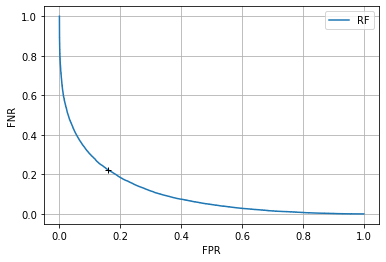

In [17]:
# to further inspect the performance:
CM = confusion_matrix(voting_gbc_y_valid, voting_clf_y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
gb_y_prob = voting_clf.predict_proba(voting_gbc_X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(voting_gbc_y_valid, gb_y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

### Result discussion

The $FPR$ and $FNR$ rate is the lower for this notebook: **0.384**. The voting system provides that encompass Three boosting models give better performance than ``XGBoost``, ``CatBoost`` and ``LightGBM`` on the binary classification task. But a voting system with a majority vote generates better performance than a soft vote which predict the class label based on the argmax of the sums of the predicted probabilities. So the best model remains the voting system with a majority vote.

## 12/ Neural Network



Without no doubt, nowadays neural networks outperform most traditional approaches. For computer vision tasks they are one of the best options. However, neural network approaches require an adequate architecture and suffer from a training time that can be very long. Moreover, to train a neural network efficiently, it requires a large volume of data. 

To be efficient, neural networks need an adequate architecture based on the stacking of different layers.

In order to find the best architecture, I have made several attempts and the architecture I have chosen is a neural network with **3 dense layers** composed of **48 neurons** (```layer_size = 48```)  per layer associated with a ```ReLu``` type activation function. I also use batch normalisation for improved performance. To prevent the risk of overfitting I set a dropout at **0.5** at each layer. Indeed, overfitting is a frequent problem when training a Deep Learning model, but a technique exists to counter it: the Dropout. In fact, the term "Dropout" refers to the deletion of neurons in the layers of a Deep Learning model. In fact, we temporarily deactivate some neurons in the network, as well as all its input and output connections. More concretely, At each epoch, we apply this random deactivation. That is to say that at each pass (forward propagation) the model will learn with a different configuration of neurons, the neurons being randomly activated and deactivated.

Regarding the training strategy of the neural network, I chose to train the neural network on the entire training dataset without taking into account the selected variables because a neural network requires a large volume of data to be effective. Thus the parameters chosen for the training are the following:

- ```epoch = 20``` 
- ```batch_size = 1024```

We note that:

- Batch_size is the size of a training batch processed before the model parameters are updated. Choosing a batch size that is too small will introduce a high degree of variance (noise) into each batch because a small sample is unlikely to be a good representation of the data set. Conversely, if a batch size is too large, it may not fit in the memory of the computational instance used for training and it will tend to overfit the data.


- Epoch is the number of complete learning cycles. At the end of each complete learning cycle, the algorithm is able to adapt its parameters to make better predictions for the next learning cycle. Too many epochs can cause the learning model to over-train (over-fit). There is no magic rule to choose the number of epochs



#### Split data

In [157]:
# split into X_train, y_train, X_valid and y_valid
nn_X_train, nn_X_valid, nn_y_train, nn_y_valid = train_test_split(X_dataframe, y_dataframe, test_size=0.2, random_state=12)

#### Convert data to numpy

In [158]:
# convert data to numpy
nn_X_train = np.array(nn_X_train)
nn_y_train = np.ravel(np.array(nn_y_train))
nn_X_valid = np.array(nn_X_valid)
nn_y_valid = np.array(nn_y_valid)

#### Define the neural network hyperparameters

In [159]:
# architecture of the network
nn_epochs = 20
nn_batch_size = 1024
nn_verbose = 1
nn_input_size = nn_X_train.shape[1]
nn_layer_size = 48 # neurons number
nn_validation_split = 0.1
nn_dropout = 0.5 # manage overfitting

#### Define the neural network architecture

In [160]:
# building of the model
model = tf.keras.models.Sequential()

# dense layers
model.add(keras.layers.Dense(nn_layer_size,input_shape=(nn_input_size,), name='dense_layer_1', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dropout(nn_dropout))

model.add(keras.layers.Dense(nn_layer_size, name='dense_layer_2', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dropout(nn_dropout))

model.add(keras.layers.Dense(nn_layer_size, name='dense_layer_3', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dropout(nn_dropout))

# decision layer
model.add(keras.layers.Dense(1, name='dense_layer_final', activation='sigmoid'))

#### Summary of the neural network architecture

In [161]:
# summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer_1 (Dense)       (None, 48)                4608      
                                                                 
 batch_normalization (BatchN  (None, 48)               192       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_layer_2 (Dense)       (None, 48)                2304      
                                                                 
 batch_normalization_1 (Batc  (None, 48)               192       
 hNormalization)                                        

#### Compile the neural network

In [162]:
# compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

#### Train the neural network

In [163]:
%%time
# training of the model
history = model.fit(nn_X_train, nn_y_train, batch_size=nn_batch_size, epochs=nn_epochs, verbose=nn_verbose, \
         validation_split=nn_validation_split);

Epoch 1/20
209/209 [==============================] - 4s 12ms/step - loss: 0.6650 - accuracy: 0.6329 - val_loss: 1.0905 - val_accuracy: 0.5619
Epoch 2/20
209/209 [==============================] - 2s 10ms/step - loss: 0.5636 - accuracy: 0.7221 - val_loss: 0.6119 - val_accuracy: 0.6950
Epoch 3/20
209/209 [==============================] - 2s 11ms/step - loss: 0.5439 - accuracy: 0.7371 - val_loss: 0.5287 - val_accuracy: 0.7438
Epoch 4/20
209/209 [==============================] - 2s 11ms/step - loss: 0.5337 - accuracy: 0.7445 - val_loss: 0.5113 - val_accuracy: 0.7489
Epoch 5/20
209/209 [==============================] - 2s 11ms/step - loss: 0.5245 - accuracy: 0.7503 - val_loss: 0.5045 - val_accuracy: 0.7551
Epoch 6/20
209/209 [==============================] - 2s 10ms/step - loss: 0.5190 - accuracy: 0.7534 - val_loss: 0.5008 - val_accuracy: 0.7562
Epoch 7/20
209/209 [==============================] - 2s 10ms/step - loss: 0.5137 - accuracy: 0.7577 - val_loss: 0.5019 - val_accuracy: 0.7567

#### Display the evolution of the accuracy and the loss function at each epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


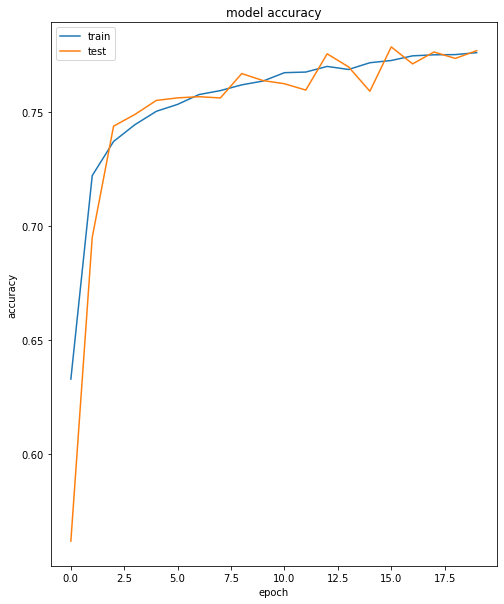

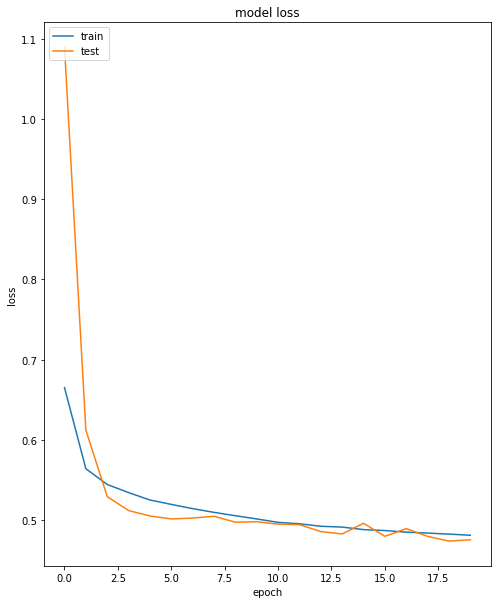

In [164]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Compute FPR + FNR score

In [165]:
# compute FPR + FNR score

# set a threshold to convert sigmoid ouput probablity to binary value {True, False}
nn_y_pred = tf.greater(model.predict(nn_X_valid), 0.5)
# convert tensor of {True, False} binary value to int {1, 0} value
nn_y_pred = nn_y_pred.numpy().astype(int)
valid_score = criterion(nn_y_pred, nn_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.44335784801049566


### Result discussion

The $FPR$ and $FNR$ rate is not the slower of this notebook: **0.44**. Indeed, boosting algorithm suach as ```XGBoost```, ```LightGBM``` and ```CatBoost``` great better with $FPR$ and $FNR$ rate at **0.40** than the neural network. This poor performance can be explained by the fact that the selected architecture may not be the best one available.

## Let's try co generate new features

The objective is to extend the number of characteristics of the training dataset and apply my best model which is the combination of ``XGBoost``, ``LightGBM`` and ``CatBoost`` models in a voting classifier with the same hyperparameters

To do this, it is necessary to create linear combinations between the vectors Z1 and Z2 such as Z1+Z2, Z1-Z2

### Generation of new features for the ``X_dataframe`` training dataset

In [8]:
X_dataframe_enlarged = X_dataframe.copy()

for i in range(X_dataframe_enlarged.shape[1]):
    col_A = X_dataframe_enlarged.iloc[:,i]
    col_B = X_dataframe_enlarged.iloc[:,48+i]
    X_dataframe_enlarged["col_"+str(i)+"minus_col_"+str(48+i)] = col_A - col_B
    X_dataframe_enlarged["col_"+str(i)+"plus_col_"+str(48+i)] = col_A + col_B
    X_dataframe_enlarged["col_"+str(i)+"dot_col_"+str(48+i)] = col_A * col_B
    
X_dataframe_enlarged

0      1      2      3       4       5       6       7    8  \
0       236.031  1.000  0.000  0.000  -2.134  -3.195   1.100  23.831  1.0   
1       228.040  1.000  0.000  0.000  -0.860 -15.950  -1.410  58.040  0.0   
2       158.310  1.000  0.000  0.000  -2.290  -7.680   0.120  22.770  1.0   
3       165.464  0.284  0.000  0.716  38.303 -16.267  -9.469  45.229  1.0   
4       153.727  1.000  0.000  0.000   0.780  -5.169  -0.291  27.574  0.0   
...         ...    ...    ...    ...     ...     ...     ...     ...  ...   
297227   77.865  0.989  0.006  0.004  27.117 -25.148 -19.818  26.619  0.0   
297228  147.250  1.000  0.000  0.000   3.040  -9.620  -2.790  36.990  0.0   
297229  219.495  1.000  0.000  0.000 -31.372  -2.752  -2.153  33.358  1.0   
297230  111.054  1.000  0.000  0.000 -13.329  -5.626   3.282  34.638  0.0   
297231  221.947  1.000  0.000  0.000 -34.777 -15.352   8.289  27.163  1.0   

            9   10   11   12   13     14     15     16     17     18     19  \
0       0.001  1.0  1.0  0.0  0.0  0.000  255.0  255.0  193.0  255.0  160.0   
1       1.000  1.0  1.0  0.0  0.0  0.000  255.0  255.0  255.0  212.0  255.0   
2       0.000  1.0  1.0  0.0  0.0  0.000  255.0  201.0  255.0  248.0    0.0   
3       0.003  1.0  1.0  0.0  0.0  0.001  255.0  150.0   93.0  169.0   32.0   
4       0.001  1.0  1.0  0.0  0.0  0.001  255.0  255.0  218.0  247.0  255.0   
...       ...  ...  ...  ...  ...    ...    ...    ...    ...    ...    ...   
297227  0.002  1.0  1.0  0.0  0.0  0.001  255.0  255.0  195.0  255.0  171.0   
297228  0.000  1.0  1.0  0.0  0.0  0.000  255.0  255.0  255.0  206.0  255.0   
297229  0.001  1.0  0.0  0.0  1.0  0.001  255.0  255.0  255.0  255.0  255.0   
297230  0.001  1.0  1.0  0.0  0.0  0.000  255.0  255.0  179.0  253.0  103.0   
297231  0.001  1.0  0.0  0.0  1.0  0.001  255.0  255.0  173.0  145.0  255.0   

           20     21     22     23     24     25     26     27     28     29  \
0         0.0  217.0   79.0  175.0  194.0  221.0  254.0  255.0  254.0  245.0   
1       255.0  213.0   96.0  172.0  188.0  226.0  254.0  196.0  225.0  210.0   
2       255.0  220.0  236.0  175.0  194.0  202.0  254.0  255.0  254.0  247.0   
3         0.0  110.0    0.0  175.0  171.0  130.0   11.0  221.0  225.0  137.0   
4         0.0  154.0   72.0  175.0  140.0  199.0  171.0  255.0  254.0  145.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
297227    0.0  118.0    0.0  175.0  194.0  220.0  162.0  255.0  254.0    0.0   
297228  255.0  189.0  168.0  175.0  194.0  227.0  254.0  255.0  254.0  242.0   
297229    0.0  110.0  232.0  175.0  177.0  130.0  165.0  255.0  254.0  153.0   
297230    0.0  112.0    0.0  175.0  194.0  152.0  253.0  255.0  254.0  210.0   
297231    0.0  124.0    0.0  175.0  186.0  133.0  217.0  255.0  254.0    0.0   

            30     31      32      33      34     35        36        37  \
0        7.806  4.148  -0.411   2.673   1.451   84.0  0.945000  0.986000   
1        2.570  1.130  -2.610  -4.070  -2.220  121.0  0.823407  0.993560   
2        5.660  1.540  -1.620  -0.060  -0.750   63.0  0.616242  0.985232   
3      -10.177  2.300  57.818   1.508   1.880   56.0  0.897000  0.992000   
4        3.239  2.047   0.166   1.760   1.430   88.0  0.545000  0.628000   
...        ...    ...     ...     ...     ...    ...       ...       ...   
297227  -1.256  2.123  26.403 -30.177 -11.785   80.0  0.892000  0.974000   
297228  -0.810  1.100   5.540  -5.670  -2.530  117.0  0.932584  0.989263   
297229  -8.352  1.735 -34.138   2.945  -2.204   74.0  0.852000  0.586000   
297230  -7.390  1.947 -14.144  -1.181   0.357   87.0  0.910000  0.987000   
297231  -6.255  2.125 -35.505  -2.704   2.327   78.0  0.613000  0.991000   

              38        39        40        41        42        43   44  \
0       0.621000  0.993000  0.686000  0.375000  0.998000  0.801000  0.0   
1       0.918158  0.858533  0.932080  0.649915  0.902721  0.869304  0.0   
2       0.961017  0.995382  0.696401  0.7

### Generation of new features for the ``X_test_dataframe`` test dataset

In [28]:
# Load test data
X_test = np.load("test_data.npy")
X_test_enlarged = X_test.copy()
X_test_dataframe_enlarged =  pd.DataFrame(X_test_enlarged)

for i in range(X_test_dataframe_enlarged.shape[1]):
    col_A = X_test_dataframe_enlarged.iloc[:,i]
    col_B = X_test_dataframe_enlarged.iloc[:,48+i]
    X_test_dataframe_enlarged["col_"+str(i)+"minus_col_"+str(48+i)] = col_A - col_B
    X_test_dataframe_enlarged["col_"+str(i)+"plus_col_"+str(48+i)] = col_A + col_B
    X_test_dataframe_enlarged["col_"+str(i)+"dot_col_"+str(48+i)] = col_A * col_B
    
X_test_dataframe_enlarged

0      1      2      3       4       5       6       7    8  \
0      170.140  1.000  0.000  0.000  -0.000 -11.020  -3.070  32.180  1.0   
1      135.148  0.994  0.006  0.000 -30.023 -15.470   9.360  44.548  0.0   
2      194.070  1.000  0.000  0.000  -0.600 -16.610  -1.080  56.870  1.0   
3      168.489  0.729  0.000  0.271  33.690 -22.828 -14.179  52.387  0.0   
4      101.788  1.000  0.000  0.000  -6.074 -10.998  -0.036  24.359  0.0   
...        ...    ...    ...    ...     ...     ...     ...     ...  ...   
99075  192.900  1.000  0.000  0.000   2.460  -0.190  -1.300  22.700  0.0   
99076  118.393  0.995  0.005  0.000  20.230  -7.639  -3.885  54.905  1.0   
99077  118.303  1.000  0.000  0.000   3.957 -10.470   0.118  41.823  0.0   
99078  201.492  1.000  0.000  0.000   4.239   8.468   1.957  19.072  0.0   
99079  167.230  1.000  0.000  0.000  -2.900  -2.170  -0.080  40.690  0.0   

           9   10   11   12   13     14     15     16     17     18     19  \
0      0.000  1.0  1.0  0.0  0.0  0.000  255.0  255.0  255.0  238.0  255.0   
1      0.001  1.0  1.0  0.0  0.0  0.001  255.0  255.0  162.0  204.0  221.0   
2      0.000  1.0  1.0  0.0  0.0  0.000  255.0  255.0  255.0  230.0  255.0   
3      0.006  1.0  1.0  0.0  0.0  0.003  255.0  255.0  178.0  250.0  255.0   
4      0.001  1.0  1.0  0.0  0.0  0.000  255.0  255.0  200.0  247.0  145.0   
...      ...  ...  ...  ...  ...    ...    ...    ...    ...    ...    ...   
99075  0.000  1.0  1.0  0.0  0.0  0.000  255.0  255.0  255.0  255.0  255.0   
99076  0.048  1.0  1.0  0.0  0.0  0.022  255.0  255.0  225.0  240.0  255.0   
99077  0.002  1.0  1.0  0.0  0.0  0.001  255.0  255.0  240.0  255.0  255.0   
99078  0.002  1.0  1.0  0.0  0.0  0.001  255.0  255.0  233.0  254.0  192.0   
99079  0.000  1.0  1.0  0.0  0.0  0.000  255.0  255.0  255.0  254.0  255.0   

          20     21     22     23     24     25     26     27     28     29  \
0      255.0  220.0  108.0  175.0  193.0  229.0  251.0  255.0  254.0  226.0   
1        0.0  110.0   56.0  175.0  119.0  130.0  254.0  255.0  254.0  140.0   
2      255.0  220.0  113.0  175.0  194.0  230.0  254.0  255.0  254.0  231.0   
3        0.0  115.0    0.0  175.0   21.0  132.0  250.0  255.0  254.0   54.0   
4        0.0  111.0  218.0  175.0  194.0  182.0   11.0  255.0  254.0  190.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
99075  255.0  220.0    0.0  175.0  194.0  229.0  254.0  255.0  254.0  252.0   
99076    0.0  118.0  131.0  175.0  179.0  210.0    0.0  255.0  254.0  238.0   
99077    0.0  194.0    0.0  175.0  168.0  205.0  232.0  255.0  254.0  231.0   
99078    0.0  110.0  255.0  175.0  194.0  169.0    0.0  255.0  254.0  178.0   
99079  255.0  219.0  255.0  151.0  194.0  213.0  254.0  255.0  254.0  235.0   

           30     31      32      33     34     35        36        37  \
0       2.060  1.070  -1.630  -1.530 -0.780  118.0  0.844216  0.997256   
1      -3.518  2.012 -34.138  -2.703  1.829   79.0  0.793000  0.848000   
2       1.310  1.040   0.770   0.020 -1.030  127.0  0.827327  0.987265   
3      -5.432  3.867  39.572 -10.635 -9.740   73.0  0.804000  0.626000   
4       2.879  1.634 -17.699  -0.874 -1.390   84.0  0.844000  0.994000   
...       ...    ...     ...     ...    ...    ...       ...       ...   
99075  12.870  1.380   2.760   1.920  0.870  114.0  0.956066  0.982004   
99076  -4.845  2.147  17.396   2.985  2.943   92.0  0.736000  0.955000   
99077   2.824  2.578   1.343  -3.707  1.650   94.0  0.861000  0.992000   
99078   4.703  1.667   9.097  12.556  0.687   92.0  0.698000  0.986000   
99079   2.840  1.190  -3.160   1.820 -0.820  121.0  0.741879  0.991252   

             38        39        40        41        42        43   44  \
0      0.929671  0.936884  0.752725  0.928838  0.992638  0.912097  0.0   
1      0.918000  0.971000  0.794000  0.429000  0.988000  0.821000  0.0   
2      0.676200  0.852015  0.990901  0.903850  0.947934  0.884600  0.0   
3      0.946000  0.985000  0.

### Voting with enlarged dataframe

#### Split whole dataset

In [11]:
enlarged_voting_gbc_X_train, enlarged_voting_gbc_X_valid, enlarged_voting_gbc_y_train, enlarged_voting_gbc_y_valid = train_test_split(X_dataframe_enlarged, y, test_size=0.2, random_state=57)

#### Define hyperparameters and fit the model

In [15]:
%%time

estimators = [
    ('xgbc', XGBClassifier(booster='gbtree', learning_rate=0.3, 
                     max_depth=6, n_estimators=103, 
                     colsample_bynode=1, colsample_bytree=1,
                     subsample=1, gamma=0, 
                     objective='binary:logistic', random_state=57)),
    
    ('lgbc', LGBMClassifier(objective= 'binary', 
                            n_estimators = 2000, random_state=57)),
    
    ('catgbc', CatBoostClassifier(eval_metric= 'Logloss', iterations= 1500, 
                                  learning_rate= 0.1, subsample= 0.8, random_state=57))
]

voting_clf_enlarged = VotingClassifier(estimators=estimators, voting='hard')

voting_clf_enlarged.fit(enlarged_voting_gbc_X_train, enlarged_voting_gbc_y_train)

[15:27:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6617314	total: 378ms	remaining: 9m 26s
1:	learn: 0.6362425	total: 772ms	remaining: 9m 37s
2:	learn: 0.6163850	total: 1.14s	remaining: 9m 29s
3:	learn: 0.5992620	total: 1.61s	remaining: 10m 3s
4:	learn: 0.5861312	total: 1.95s	remaining: 9m 43s
5:	learn: 0.5744459	total: 2.36s	remaining: 9m 47s
6:	learn: 0.5628752	total: 2.79s	remaining: 9m 56s
7:	learn: 0.5541860	total: 3.12s	remaining: 9m 40s
8:	learn: 0.5469270	total: 3.51s	remaining: 9m 40s
9:	learn: 0.5389828	total: 3.99s	remaining: 9m 54s
10:	learn: 0.5334995	total: 4.33s	remaining: 9m 45s
11:	learn: 0.5277125	total: 4.75s	remaining: 9m 49s
12:	learn: 0.5230033	total: 5.07s	remaining: 9m 39s
13:	learn: 0.5190566	tot

152:	learn: 0.4221675	total: 1m	remaining: 8m 54s
153:	learn: 0.4219942	total: 1m 1s	remaining: 8m 53s
154:	learn: 0.4218227	total: 1m 1s	remaining: 8m 52s
155:	learn: 0.4215723	total: 1m 1s	remaining: 8m 52s
156:	learn: 0.4214042	total: 1m 2s	remaining: 8m 51s
157:	learn: 0.4212629	total: 1m 2s	remaining: 8m 50s
158:	learn: 0.4211334	total: 1m 2s	remaining: 8m 49s
159:	learn: 0.4209981	total: 1m 3s	remaining: 8m 48s
160:	learn: 0.4208118	total: 1m 3s	remaining: 8m 48s
161:	learn: 0.4206860	total: 1m 3s	remaining: 8m 47s
162:	learn: 0.4205417	total: 1m 4s	remaining: 8m 46s
163:	learn: 0.4203711	total: 1m 4s	remaining: 8m 45s
164:	learn: 0.4202379	total: 1m 4s	remaining: 8m 45s
165:	learn: 0.4201213	total: 1m 5s	remaining: 8m 45s
166:	learn: 0.4199984	total: 1m 5s	remaining: 8m 43s
167:	learn: 0.4197993	total: 1m 5s	remaining: 8m 43s
168:	learn: 0.4196187	total: 1m 6s	remaining: 8m 42s
169:	learn: 0.4194897	total: 1m 6s	remaining: 8m 41s
170:	learn: 0.4192968	total: 1m 6s	remaining: 8m 

305:	learn: 0.4050946	total: 1m 57s	remaining: 7m 37s
306:	learn: 0.4050167	total: 1m 57s	remaining: 7m 37s
307:	learn: 0.4049465	total: 1m 58s	remaining: 7m 36s
308:	learn: 0.4048753	total: 1m 58s	remaining: 7m 36s
309:	learn: 0.4047903	total: 1m 58s	remaining: 7m 35s
310:	learn: 0.4046949	total: 1m 59s	remaining: 7m 35s
311:	learn: 0.4045981	total: 1m 59s	remaining: 7m 35s
312:	learn: 0.4045099	total: 1m 59s	remaining: 7m 35s
313:	learn: 0.4044367	total: 2m	remaining: 7m 34s
314:	learn: 0.4043535	total: 2m	remaining: 7m 34s
315:	learn: 0.4042604	total: 2m 1s	remaining: 7m 33s
316:	learn: 0.4041536	total: 2m 1s	remaining: 7m 33s
317:	learn: 0.4040494	total: 2m 2s	remaining: 7m 33s
318:	learn: 0.4039592	total: 2m 2s	remaining: 7m 33s
319:	learn: 0.4038831	total: 2m 2s	remaining: 7m 32s
320:	learn: 0.4037940	total: 2m 3s	remaining: 7m 32s
321:	learn: 0.4037474	total: 2m 3s	remaining: 7m 31s
322:	learn: 0.4036804	total: 2m 3s	remaining: 7m 30s
323:	learn: 0.4036018	total: 2m 4s	remaining

458:	learn: 0.3940305	total: 2m 51s	remaining: 6m 30s
459:	learn: 0.3939758	total: 2m 52s	remaining: 6m 29s
460:	learn: 0.3939195	total: 2m 52s	remaining: 6m 29s
461:	learn: 0.3938541	total: 2m 53s	remaining: 6m 28s
462:	learn: 0.3937989	total: 2m 53s	remaining: 6m 28s
463:	learn: 0.3937171	total: 2m 53s	remaining: 6m 27s
464:	learn: 0.3936925	total: 2m 53s	remaining: 6m 27s
465:	learn: 0.3936311	total: 2m 54s	remaining: 6m 26s
466:	learn: 0.3935761	total: 2m 54s	remaining: 6m 26s
467:	learn: 0.3935134	total: 2m 54s	remaining: 6m 25s
468:	learn: 0.3934297	total: 2m 55s	remaining: 6m 25s
469:	learn: 0.3933559	total: 2m 55s	remaining: 6m 25s
470:	learn: 0.3932857	total: 2m 56s	remaining: 6m 24s
471:	learn: 0.3932372	total: 2m 56s	remaining: 6m 24s
472:	learn: 0.3931632	total: 2m 56s	remaining: 6m 23s
473:	learn: 0.3931151	total: 2m 57s	remaining: 6m 23s
474:	learn: 0.3930412	total: 2m 57s	remaining: 6m 22s
475:	learn: 0.3929982	total: 2m 57s	remaining: 6m 22s
476:	learn: 0.3929393	total:

611:	learn: 0.3850426	total: 3m 46s	remaining: 5m 27s
612:	learn: 0.3849708	total: 3m 46s	remaining: 5m 27s
613:	learn: 0.3849181	total: 3m 46s	remaining: 5m 27s
614:	learn: 0.3848649	total: 3m 47s	remaining: 5m 26s
615:	learn: 0.3848182	total: 3m 47s	remaining: 5m 26s
616:	learn: 0.3847511	total: 3m 47s	remaining: 5m 25s
617:	learn: 0.3847087	total: 3m 48s	remaining: 5m 25s
618:	learn: 0.3846429	total: 3m 48s	remaining: 5m 25s
619:	learn: 0.3845738	total: 3m 48s	remaining: 5m 24s
620:	learn: 0.3845201	total: 3m 49s	remaining: 5m 24s
621:	learn: 0.3845182	total: 3m 49s	remaining: 5m 23s
622:	learn: 0.3844620	total: 3m 49s	remaining: 5m 23s
623:	learn: 0.3844064	total: 3m 50s	remaining: 5m 22s
624:	learn: 0.3843517	total: 3m 50s	remaining: 5m 22s
625:	learn: 0.3843039	total: 3m 50s	remaining: 5m 22s
626:	learn: 0.3842601	total: 3m 51s	remaining: 5m 21s
627:	learn: 0.3842052	total: 3m 51s	remaining: 5m 21s
628:	learn: 0.3841591	total: 3m 51s	remaining: 5m 21s
629:	learn: 0.3841033	total:

765:	learn: 0.3768368	total: 4m 39s	remaining: 4m 28s
766:	learn: 0.3767804	total: 4m 40s	remaining: 4m 27s
767:	learn: 0.3767108	total: 4m 40s	remaining: 4m 27s
768:	learn: 0.3766586	total: 4m 40s	remaining: 4m 26s
769:	learn: 0.3766101	total: 4m 41s	remaining: 4m 26s
770:	learn: 0.3765540	total: 4m 41s	remaining: 4m 26s
771:	learn: 0.3764971	total: 4m 41s	remaining: 4m 25s
772:	learn: 0.3764473	total: 4m 42s	remaining: 4m 25s
773:	learn: 0.3763888	total: 4m 42s	remaining: 4m 24s
774:	learn: 0.3763464	total: 4m 42s	remaining: 4m 24s
775:	learn: 0.3763000	total: 4m 43s	remaining: 4m 24s
776:	learn: 0.3762403	total: 4m 43s	remaining: 4m 23s
777:	learn: 0.3761947	total: 4m 43s	remaining: 4m 23s
778:	learn: 0.3761534	total: 4m 44s	remaining: 4m 22s
779:	learn: 0.3760900	total: 4m 44s	remaining: 4m 22s
780:	learn: 0.3760461	total: 4m 44s	remaining: 4m 22s
781:	learn: 0.3759906	total: 4m 45s	remaining: 4m 21s
782:	learn: 0.3759430	total: 4m 45s	remaining: 4m 21s
783:	learn: 0.3758741	total:

919:	learn: 0.3690537	total: 5m 35s	remaining: 3m 31s
920:	learn: 0.3689911	total: 5m 36s	remaining: 3m 31s
921:	learn: 0.3689333	total: 5m 36s	remaining: 3m 30s
922:	learn: 0.3688838	total: 5m 36s	remaining: 3m 30s
923:	learn: 0.3688307	total: 5m 37s	remaining: 3m 30s
924:	learn: 0.3687781	total: 5m 37s	remaining: 3m 29s
925:	learn: 0.3687256	total: 5m 37s	remaining: 3m 29s
926:	learn: 0.3686854	total: 5m 38s	remaining: 3m 29s
927:	learn: 0.3686365	total: 5m 38s	remaining: 3m 28s
928:	learn: 0.3685766	total: 5m 39s	remaining: 3m 28s
929:	learn: 0.3685128	total: 5m 39s	remaining: 3m 28s
930:	learn: 0.3684588	total: 5m 39s	remaining: 3m 27s
931:	learn: 0.3684119	total: 5m 40s	remaining: 3m 27s
932:	learn: 0.3683651	total: 5m 40s	remaining: 3m 26s
933:	learn: 0.3682940	total: 5m 40s	remaining: 3m 26s
934:	learn: 0.3682240	total: 5m 41s	remaining: 3m 26s
935:	learn: 0.3681605	total: 5m 41s	remaining: 3m 25s
936:	learn: 0.3681042	total: 5m 42s	remaining: 3m 25s
937:	learn: 0.3680487	total:

1071:	learn: 0.3617367	total: 6m 30s	remaining: 2m 35s
1072:	learn: 0.3616912	total: 6m 30s	remaining: 2m 35s
1073:	learn: 0.3616900	total: 6m 31s	remaining: 2m 35s
1074:	learn: 0.3616350	total: 6m 31s	remaining: 2m 34s
1075:	learn: 0.3615742	total: 6m 31s	remaining: 2m 34s
1076:	learn: 0.3615247	total: 6m 32s	remaining: 2m 34s
1077:	learn: 0.3614813	total: 6m 32s	remaining: 2m 33s
1078:	learn: 0.3614332	total: 6m 32s	remaining: 2m 33s
1079:	learn: 0.3613766	total: 6m 33s	remaining: 2m 32s
1080:	learn: 0.3613438	total: 6m 33s	remaining: 2m 32s
1081:	learn: 0.3613033	total: 6m 33s	remaining: 2m 32s
1082:	learn: 0.3612531	total: 6m 34s	remaining: 2m 31s
1083:	learn: 0.3612012	total: 6m 34s	remaining: 2m 31s
1084:	learn: 0.3611513	total: 6m 35s	remaining: 2m 31s
1085:	learn: 0.3611125	total: 6m 35s	remaining: 2m 30s
1086:	learn: 0.3610604	total: 6m 35s	remaining: 2m 30s
1087:	learn: 0.3610281	total: 6m 35s	remaining: 2m 29s
1088:	learn: 0.3609723	total: 6m 36s	remaining: 2m 29s
1089:	lear

1222:	learn: 0.3548266	total: 7m 24s	remaining: 1m 40s
1223:	learn: 0.3547883	total: 7m 25s	remaining: 1m 40s
1224:	learn: 0.3547473	total: 7m 25s	remaining: 1m 39s
1225:	learn: 0.3547098	total: 7m 25s	remaining: 1m 39s
1226:	learn: 0.3546636	total: 7m 26s	remaining: 1m 39s
1227:	learn: 0.3546150	total: 7m 26s	remaining: 1m 38s
1228:	learn: 0.3545614	total: 7m 26s	remaining: 1m 38s
1229:	learn: 0.3545083	total: 7m 27s	remaining: 1m 38s
1230:	learn: 0.3544438	total: 7m 27s	remaining: 1m 37s
1231:	learn: 0.3543934	total: 7m 27s	remaining: 1m 37s
1232:	learn: 0.3543538	total: 7m 28s	remaining: 1m 37s
1233:	learn: 0.3543003	total: 7m 28s	remaining: 1m 36s
1234:	learn: 0.3542527	total: 7m 28s	remaining: 1m 36s
1235:	learn: 0.3542064	total: 7m 29s	remaining: 1m 35s
1236:	learn: 0.3541536	total: 7m 29s	remaining: 1m 35s
1237:	learn: 0.3541176	total: 7m 29s	remaining: 1m 35s
1238:	learn: 0.3540786	total: 7m 30s	remaining: 1m 34s
1239:	learn: 0.3540437	total: 7m 30s	remaining: 1m 34s
1240:	lear

1374:	learn: 0.3480572	total: 8m 18s	remaining: 45.3s
1375:	learn: 0.3480189	total: 8m 18s	remaining: 44.9s
1376:	learn: 0.3479851	total: 8m 18s	remaining: 44.6s
1377:	learn: 0.3479366	total: 8m 19s	remaining: 44.2s
1378:	learn: 0.3478885	total: 8m 19s	remaining: 43.8s
1379:	learn: 0.3478405	total: 8m 19s	remaining: 43.5s
1380:	learn: 0.3477930	total: 8m 20s	remaining: 43.1s
1381:	learn: 0.3477464	total: 8m 20s	remaining: 42.8s
1382:	learn: 0.3477041	total: 8m 21s	remaining: 42.4s
1383:	learn: 0.3476670	total: 8m 21s	remaining: 42s
1384:	learn: 0.3476174	total: 8m 22s	remaining: 41.7s
1385:	learn: 0.3475747	total: 8m 22s	remaining: 41.3s
1386:	learn: 0.3475322	total: 8m 22s	remaining: 41s
1387:	learn: 0.3474887	total: 8m 23s	remaining: 40.6s
1388:	learn: 0.3474365	total: 8m 23s	remaining: 40.2s
1389:	learn: 0.3473993	total: 8m 23s	remaining: 39.9s
1390:	learn: 0.3473450	total: 8m 24s	remaining: 39.5s
1391:	learn: 0.3473089	total: 8m 24s	remaining: 39.1s
1392:	learn: 0.3472756	total: 8m

VotingClassifier(estimators=[('xgbc',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.3,
                                            max_delta_step=None, max_depth=6,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=103, n_jobs=None,
                                            num_parallel_tree=None,
                    

#### Compute FPR + FNR score

In [16]:
enlarged_voting_clf_y_pred = voting_clf_enlarged.predict(enlarged_voting_gbc_X_valid)
valid_score = criterion(enlarged_voting_clf_y_pred, enlarged_voting_gbc_y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.37937935017824587


### Result discussion

The $FPR$ and $FNR$ rate is the lower for this notebook: **0.379**. The voting system provides that encompass Three boosting models train on the enlarged give better performance than ``XGBoost``, ``CatBoost`` and ``LightGBM`` on the binary classification task. We therefore deduce taht the generation of new features seems to improve the performance of the model.

## Fit the best model on the entire dataset

We prepare the submission of the best model by training the model on all the data at our disposal without splitting the dataset. 

The best performing model is a voting model that which includes 3 boosting algorithms 
- ```XGBoost```
- ```LightGBM```
- ```CatBoost```

With a majority voting system

### Fitting the best model

In [18]:
%%time
best_estimators = [
    ('xgbc', XGBClassifier(booster='gbtree', learning_rate=0.3, 
                     max_depth=6, n_estimators=103, 
                     colsample_bynode=1, colsample_bytree=1,
                     subsample=1, gamma=0, 
                     objective='binary:logistic', random_state=57)),
    
    ('lgbc', LGBMClassifier(objective= 'binary', 
                            n_estimators = 2000, random_state=57)),
    
    ('catgbc', CatBoostClassifier(eval_metric= 'Logloss', iterations= 1500, 
                                  learning_rate= 0.1, subsample= 0.8, random_state=57))
]

best_model = VotingClassifier(estimators=best_estimators, voting='hard')

best_model.fit(X_dataframe_enlarged, y)

[15:51:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6611588	total: 446ms	remaining: 11m 8s
1:	learn: 0.6365899	total: 885ms	remaining: 11m 2s
2:	learn: 0.6151279	total: 1.51s	remaining: 12m 34s
3:	learn: 0.5980573	total: 1.95s	remaining: 12m 10s
4:	learn: 0.5829017	total: 2.53s	remaining: 12m 36s
5:	learn: 0.5709179	total: 2.96s	remaining: 12m 16s
6:	learn: 0.5610373	total: 3.36s	remaining: 11m 55s
7:	learn: 0.5529757	total: 3.82s	remaining: 11m 52s
8:	learn: 0.5447953	total: 4.32s	remaining: 11m 54s
9:	learn: 0.5370827	total: 4.84s	remaining: 12m
10:	learn: 0.5314296	total: 5.21s	remaining: 11m 44s
11:	learn: 0.5265824	total: 5.65s	remaining: 11m 40s
12:	learn: 0.5221126	total: 6.17s	remaining: 11m 45s
13:	learn: 0.5171

150:	learn: 0.4234229	total: 1m 7s	remaining: 10m 4s
151:	learn: 0.4232987	total: 1m 8s	remaining: 10m 3s
152:	learn: 0.4231684	total: 1m 8s	remaining: 10m 1s
153:	learn: 0.4229419	total: 1m 8s	remaining: 10m 1s
154:	learn: 0.4228126	total: 1m 9s	remaining: 10m
155:	learn: 0.4226296	total: 1m 9s	remaining: 10m 1s
156:	learn: 0.4224851	total: 1m 10s	remaining: 10m
157:	learn: 0.4223616	total: 1m 10s	remaining: 10m
158:	learn: 0.4221810	total: 1m 11s	remaining: 10m 1s
159:	learn: 0.4220037	total: 1m 11s	remaining: 10m 2s
160:	learn: 0.4218698	total: 1m 12s	remaining: 10m 2s
161:	learn: 0.4217290	total: 1m 12s	remaining: 10m 1s
162:	learn: 0.4215779	total: 1m 13s	remaining: 10m 1s
163:	learn: 0.4214405	total: 1m 13s	remaining: 10m 1s
164:	learn: 0.4212943	total: 1m 14s	remaining: 10m 1s
165:	learn: 0.4211472	total: 1m 14s	remaining: 10m
166:	learn: 0.4209492	total: 1m 15s	remaining: 10m
167:	learn: 0.4208351	total: 1m 15s	remaining: 9m 59s
168:	learn: 0.4207036	total: 1m 16s	remaining: 9m

304:	learn: 0.4075124	total: 2m 15s	remaining: 8m 50s
305:	learn: 0.4074602	total: 2m 15s	remaining: 8m 49s
306:	learn: 0.4073827	total: 2m 16s	remaining: 8m 49s
307:	learn: 0.4073177	total: 2m 16s	remaining: 8m 48s
308:	learn: 0.4072460	total: 2m 17s	remaining: 8m 48s
309:	learn: 0.4071531	total: 2m 17s	remaining: 8m 48s
310:	learn: 0.4070785	total: 2m 18s	remaining: 8m 47s
311:	learn: 0.4070199	total: 2m 18s	remaining: 8m 47s
312:	learn: 0.4069407	total: 2m 18s	remaining: 8m 46s
313:	learn: 0.4068703	total: 2m 19s	remaining: 8m 46s
314:	learn: 0.4067862	total: 2m 19s	remaining: 8m 45s
315:	learn: 0.4067023	total: 2m 20s	remaining: 8m 45s
316:	learn: 0.4066411	total: 2m 20s	remaining: 8m 45s
317:	learn: 0.4065367	total: 2m 21s	remaining: 8m 44s
318:	learn: 0.4064781	total: 2m 21s	remaining: 8m 44s
319:	learn: 0.4064071	total: 2m 22s	remaining: 8m 44s
320:	learn: 0.4063371	total: 2m 22s	remaining: 8m 44s
321:	learn: 0.4062724	total: 2m 23s	remaining: 8m 43s
322:	learn: 0.4062068	total:

457:	learn: 0.3976970	total: 3m 20s	remaining: 7m 37s
458:	learn: 0.3976385	total: 3m 21s	remaining: 7m 36s
459:	learn: 0.3975923	total: 3m 21s	remaining: 7m 36s
460:	learn: 0.3975367	total: 3m 22s	remaining: 7m 35s
461:	learn: 0.3974763	total: 3m 22s	remaining: 7m 34s
462:	learn: 0.3974180	total: 3m 22s	remaining: 7m 34s
463:	learn: 0.3973568	total: 3m 23s	remaining: 7m 33s
464:	learn: 0.3973179	total: 3m 23s	remaining: 7m 33s
465:	learn: 0.3972536	total: 3m 24s	remaining: 7m 32s
466:	learn: 0.3972059	total: 3m 24s	remaining: 7m 32s
467:	learn: 0.3971450	total: 3m 24s	remaining: 7m 31s
468:	learn: 0.3971081	total: 3m 25s	remaining: 7m 31s
469:	learn: 0.3970464	total: 3m 25s	remaining: 7m 30s
470:	learn: 0.3969852	total: 3m 26s	remaining: 7m 30s
471:	learn: 0.3969231	total: 3m 26s	remaining: 7m 29s
472:	learn: 0.3968774	total: 3m 26s	remaining: 7m 29s
473:	learn: 0.3968089	total: 3m 27s	remaining: 7m 29s
474:	learn: 0.3967563	total: 3m 27s	remaining: 7m 28s
475:	learn: 0.3967047	total:

610:	learn: 0.3897119	total: 4m 25s	remaining: 6m 26s
611:	learn: 0.3896663	total: 4m 25s	remaining: 6m 25s
612:	learn: 0.3896176	total: 4m 26s	remaining: 6m 25s
613:	learn: 0.3895583	total: 4m 26s	remaining: 6m 24s
614:	learn: 0.3895095	total: 4m 27s	remaining: 6m 24s
615:	learn: 0.3894500	total: 4m 27s	remaining: 6m 24s
616:	learn: 0.3894055	total: 4m 28s	remaining: 6m 23s
617:	learn: 0.3893559	total: 4m 28s	remaining: 6m 23s
618:	learn: 0.3893242	total: 4m 29s	remaining: 6m 23s
619:	learn: 0.3892753	total: 4m 29s	remaining: 6m 22s
620:	learn: 0.3892306	total: 4m 30s	remaining: 6m 22s
621:	learn: 0.3891813	total: 4m 30s	remaining: 6m 21s
622:	learn: 0.3891348	total: 4m 30s	remaining: 6m 21s
623:	learn: 0.3890774	total: 4m 31s	remaining: 6m 20s
624:	learn: 0.3890275	total: 4m 31s	remaining: 6m 20s
625:	learn: 0.3889754	total: 4m 32s	remaining: 6m 20s
626:	learn: 0.3889686	total: 4m 32s	remaining: 6m 19s
627:	learn: 0.3889187	total: 4m 32s	remaining: 6m 18s
628:	learn: 0.3888695	total:

763:	learn: 0.3827204	total: 5m 34s	remaining: 5m 22s
764:	learn: 0.3827133	total: 5m 35s	remaining: 5m 22s
765:	learn: 0.3826678	total: 5m 35s	remaining: 5m 21s
766:	learn: 0.3826337	total: 5m 36s	remaining: 5m 21s
767:	learn: 0.3825764	total: 5m 36s	remaining: 5m 20s
768:	learn: 0.3825358	total: 5m 36s	remaining: 5m 20s
769:	learn: 0.3824925	total: 5m 37s	remaining: 5m 19s
770:	learn: 0.3824452	total: 5m 37s	remaining: 5m 19s
771:	learn: 0.3823954	total: 5m 38s	remaining: 5m 19s
772:	learn: 0.3823539	total: 5m 38s	remaining: 5m 18s
773:	learn: 0.3823093	total: 5m 39s	remaining: 5m 18s
774:	learn: 0.3822597	total: 5m 39s	remaining: 5m 17s
775:	learn: 0.3822200	total: 5m 39s	remaining: 5m 17s
776:	learn: 0.3821654	total: 5m 40s	remaining: 5m 16s
777:	learn: 0.3821123	total: 5m 40s	remaining: 5m 16s
778:	learn: 0.3820696	total: 5m 41s	remaining: 5m 15s
779:	learn: 0.3820680	total: 5m 41s	remaining: 5m 15s
780:	learn: 0.3820213	total: 5m 42s	remaining: 5m 14s
781:	learn: 0.3819759	total:

916:	learn: 0.3762962	total: 6m 37s	remaining: 4m 12s
917:	learn: 0.3762518	total: 6m 37s	remaining: 4m 12s
918:	learn: 0.3762069	total: 6m 38s	remaining: 4m 11s
919:	learn: 0.3761733	total: 6m 38s	remaining: 4m 11s
920:	learn: 0.3761262	total: 6m 38s	remaining: 4m 10s
921:	learn: 0.3760769	total: 6m 39s	remaining: 4m 10s
922:	learn: 0.3760434	total: 6m 39s	remaining: 4m 9s
923:	learn: 0.3759945	total: 6m 40s	remaining: 4m 9s
924:	learn: 0.3759528	total: 6m 40s	remaining: 4m 8s
925:	learn: 0.3759102	total: 6m 40s	remaining: 4m 8s
926:	learn: 0.3758647	total: 6m 41s	remaining: 4m 8s
927:	learn: 0.3758387	total: 6m 41s	remaining: 4m 7s
928:	learn: 0.3758056	total: 6m 42s	remaining: 4m 7s
929:	learn: 0.3757601	total: 6m 42s	remaining: 4m 6s
930:	learn: 0.3757140	total: 6m 42s	remaining: 4m 6s
931:	learn: 0.3756711	total: 6m 43s	remaining: 4m 5s
932:	learn: 0.3756244	total: 6m 43s	remaining: 4m 5s
933:	learn: 0.3755873	total: 6m 44s	remaining: 4m 4s
934:	learn: 0.3755357	total: 6m 44s	rema

1068:	learn: 0.3700429	total: 7m 39s	remaining: 3m 5s
1069:	learn: 0.3699965	total: 7m 39s	remaining: 3m 4s
1070:	learn: 0.3699636	total: 7m 40s	remaining: 3m 4s
1071:	learn: 0.3699273	total: 7m 40s	remaining: 3m 3s
1072:	learn: 0.3698918	total: 7m 41s	remaining: 3m 3s
1073:	learn: 0.3698537	total: 7m 41s	remaining: 3m 3s
1074:	learn: 0.3698083	total: 7m 41s	remaining: 3m 2s
1075:	learn: 0.3697631	total: 7m 42s	remaining: 3m 2s
1076:	learn: 0.3697269	total: 7m 42s	remaining: 3m 1s
1077:	learn: 0.3696720	total: 7m 43s	remaining: 3m 1s
1078:	learn: 0.3696309	total: 7m 43s	remaining: 3m
1079:	learn: 0.3695920	total: 7m 44s	remaining: 3m
1080:	learn: 0.3695650	total: 7m 44s	remaining: 2m 59s
1081:	learn: 0.3695126	total: 7m 44s	remaining: 2m 59s
1082:	learn: 0.3694802	total: 7m 45s	remaining: 2m 59s
1083:	learn: 0.3694433	total: 7m 45s	remaining: 2m 58s
1084:	learn: 0.3694108	total: 7m 45s	remaining: 2m 58s
1085:	learn: 0.3693710	total: 7m 46s	remaining: 2m 57s
1086:	learn: 0.3693483	total

1219:	learn: 0.3641161	total: 8m 43s	remaining: 2m
1220:	learn: 0.3640872	total: 8m 44s	remaining: 1m 59s
1221:	learn: 0.3640533	total: 8m 44s	remaining: 1m 59s
1222:	learn: 0.3640070	total: 8m 44s	remaining: 1m 58s
1223:	learn: 0.3639650	total: 8m 45s	remaining: 1m 58s
1224:	learn: 0.3639194	total: 8m 45s	remaining: 1m 57s
1225:	learn: 0.3638921	total: 8m 45s	remaining: 1m 57s
1226:	learn: 0.3638524	total: 8m 46s	remaining: 1m 57s
1227:	learn: 0.3638045	total: 8m 46s	remaining: 1m 56s
1228:	learn: 0.3637661	total: 8m 47s	remaining: 1m 56s
1229:	learn: 0.3637137	total: 8m 47s	remaining: 1m 55s
1230:	learn: 0.3636761	total: 8m 47s	remaining: 1m 55s
1231:	learn: 0.3636373	total: 8m 48s	remaining: 1m 54s
1232:	learn: 0.3635932	total: 8m 48s	remaining: 1m 54s
1233:	learn: 0.3635517	total: 8m 49s	remaining: 1m 54s
1234:	learn: 0.3635191	total: 8m 49s	remaining: 1m 53s
1235:	learn: 0.3634958	total: 8m 49s	remaining: 1m 53s
1236:	learn: 0.3634642	total: 8m 50s	remaining: 1m 52s
1237:	learn: 0

1370:	learn: 0.3586746	total: 9m 45s	remaining: 55.1s
1371:	learn: 0.3586368	total: 9m 45s	remaining: 54.7s
1372:	learn: 0.3586023	total: 9m 46s	remaining: 54.2s
1373:	learn: 0.3585692	total: 9m 46s	remaining: 53.8s
1374:	learn: 0.3585375	total: 9m 47s	remaining: 53.4s
1375:	learn: 0.3585054	total: 9m 47s	remaining: 52.9s
1376:	learn: 0.3584781	total: 9m 47s	remaining: 52.5s
1377:	learn: 0.3584406	total: 9m 48s	remaining: 52.1s
1378:	learn: 0.3584071	total: 9m 48s	remaining: 51.7s
1379:	learn: 0.3583676	total: 9m 49s	remaining: 51.2s
1380:	learn: 0.3583360	total: 9m 49s	remaining: 50.8s
1381:	learn: 0.3583001	total: 9m 50s	remaining: 50.4s
1382:	learn: 0.3582651	total: 9m 50s	remaining: 50s
1383:	learn: 0.3582274	total: 9m 50s	remaining: 49.5s
1384:	learn: 0.3581811	total: 9m 51s	remaining: 49.1s
1385:	learn: 0.3581368	total: 9m 51s	remaining: 48.7s
1386:	learn: 0.3580953	total: 9m 52s	remaining: 48.2s
1387:	learn: 0.3580574	total: 9m 52s	remaining: 47.8s
1388:	learn: 0.3580153	total: 

VotingClassifier(estimators=[('xgbc',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.3,
                                            max_delta_step=None, max_depth=6,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=103, n_jobs=None,
                                            num_parallel_tree=None,
                    

### Make the prediction

We prepare the submission of the model to the data challenge site. We save the model predictions in a text file that will be uploaded on the data challenge website

We make the prediction on the testing dataframe enlarged ``X_test_dataframe_enlarged``

In [29]:
# Classify the provided test data
y_test = best_model.predict(X_test_dataframe_enlarged).astype(np.int8)
np.savetxt('enlarged_voting_y_test_challenge_student_V2.txt', y_test, fmt='%i' , delimiter=',')

## Results Summary

| Model | Feature Engineering | Hard Voting | Soft Voting |Score FNR+FPR rate (Valid test) | 1-(FNR+FPR) (Valid Test) |
|-----------|-----------|-----------|-----------|-----------|-----------|
| Adaboost (baseline) | Features Selection | No | No | 0.52 | 0.48 |
| Gradient Boosting | Features Selection | No | No | 0.54 | 0.46 |
| XGBoost  | Features Selection | No | No | 0.45 | 0.55 |
| XGBoost  | Initial features | No | No | 0.40 | 0.60 |
| LightGBM | Initial features | No | No | 0.39 | 0.61 |
| CatBoost  | Initial features | No | No | 0.387 | 0.613 |
| XGBoost + LightGBM + CatBoost | Initial features | Yes | No | 0.382 | 0.618 |
| XGBoost + LightGBM + CatBoost | Initial features | No | Yes | 0.384 | 0.616 |
| XGBoost + LightGBM + CatBoost | Enlarged features | Yes | No | 0.379 | 0.621 |
| Neural Network | Initial features | No | No | 0.44 | 0.56 |

# Conclusion



For this data challenge I followed the following classic machine learning steps: 

**1/ Data investigation**

**2/ Data preprocessing**
    - drop duplicate elements
    - convert type of columns
    
**3/ Features selection** 
    - select the best features to simplify the classifiction task
    
**4/ Apply Machine learning algorithms**

**5/ Apply a neural network**

**6/ Generate new features**

**7/ Fit the best model**

**8/ Predict the label with the best model**
 
We could see that the features selection did not have the expected effect, since when I train a model on the whole dataset without going through the feature selection step, it gives better results as we could see with the model ```XGBoost```and the others boosting models.

Overall, the boosting models provide the best performance. The best performing boosting model for this data challenge seems to be the CatBoost algorithm. But I managed to improve the performance by doing a majority vote between ```XGBoost```, ```LightGBM```, ```CatBoost```

In addition, I managed to further improve the performance of my model by creating new features via linear combinations between features. Extending the number of explicative variables of the input dataset seems to improve the performance of the model

Moreover Recently, deep learning models are state-of-the-art models for image classification tasks, so one could easily deduce that neural networks are the best performing model for this data challenge. However, it seems that this is not the case, as the neural network I implemented does not produce better performance than the boosting models.

Through this data challenge, I realized that refining the hyperparameters of machine learning models is not an easy thing. However, when hyperparameters are well chosen, they usually lead to better performing models. Also, it was noticed that boosting models are better when they work together thanks to and when they are combined with a majority voting system.